In [1]:
# load all fxns and data
# %matplotlib inline

from opconNosepokeFunctions import *
from supplementaryFunctions import *
from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
import statsmodels.formula.api as smf

toneStartMarker = 23
trialStartMarker = 81
trialHitMarker = 51
trialMissMarker = 86
trialUnrewMarker = 87
sessionStartMarker = 61 
rewardProbMarker = 83
trialProbMarker = 88
list_sessionMarker = [12, 13]
sessdf = pd.read_csv('L:/4portProb_processed/sessdf.csv')
sessdf.drop(columns = 'Unnamed: 0', inplace = True)

In [2]:
def data_prep(dataset, hist = 20, trialsinsess=75, task = 'unstr', head = False):
    dataset = dataset.groupby(['animal','session']).filter(lambda x: x.reward.size >= trialsinsess)
#     dataset['valid'] = np.zeros(len(dataset))
#     dataset['valid'] = dataset['valid'].where(dataset['port'].isin([4.0]), 1)
#     dataset = dataset[dataset['valid']==1.0]
    dataset['choice_t0'] = dataset.port.values
    for i in range(1,hist): 
        dataset['choice_t'+str(i)] = dataset.groupby(['animal','session']).port.shift(i)
        dataset['shift_t'+str(i-1)] = dataset['choice_t'+str(i)]==dataset['choice_t'+str(i-1)]
        dataset['shift_t'+str(i-1)] = dataset['shift_t'+str(i-1)].replace({True: 0, False: 1})
        dataset['reward_t'+str(i)] = dataset.groupby(['animal','session']).reward.shift(i)
        dataset['reward_t'+str(i)] = dataset['reward_t'+str(i)].replace({0:-1})
#         dataset['choice_t'+str(i)] = dataset['choice_t'+str(i)].replace({1:'a', 2:'b', 3:'c', 4:'d'})
    dataset = dataset.dropna()
    if head == True:
        dataset = dataset.groupby(['animal','session']).head(trialsinsess)

    return dataset

In [ ]:
mask = (~sessdf.duplicated(subset = ['trialstart', 'eptime'])) & (~sessdf.task.isin(['dms', 'dls', 'sham',
                                                                                     'ds', 'dms_str', 'dls_str']))
sessdf_prep = data_prep(sessdf[mask], hist = 6, trialsinsess = 100, head= True)
# ds_prep = data_prep(sessdf[sessdf.task =='ds'], hist = 6, trialsinsess = 50, head = True)
# dms_prep = data_prep(sessdf[sessdf.task =='dms'], hist = 6, trialsinsess = 50, head = True)
strdf_prep = data_prep(sessdf[(sessdf.task =='str') & mask], hist = 6, trialsinsess = 50, head = True)
unstrdf_prep = data_prep(sessdf[(sessdf.task =='unstr') & mask], hist = 6, trialsinsess = 50, head = True)
les_prep = data_prep(sessdf[sessdf.task.isin(['dms', 'dls', 'ds'])], hist = 6, trialsinsess = 50, head = True)
# dls_prep = data_prep(sessdf[sessdf.task =='dls'], hist = 6, trialsinsess = 50, head = True)
# simdf_prep = data_prep(sim_qldf, hist = 6, trialsinsess = 50, head= True)
# sessdf_prep.animal.unique(), simdf_prep.animal.unique()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from pandas.api.types import CategoricalDtype
catdtype = CategoricalDtype(categories=np.arange(1,5), ordered = False)

# lesion category 
les = 'dls'
res = pd.DataFrame()

# which animals, dataframes to select
# if les == 'dls':
#     animal, dfs, cond = ['Blissey', 'Darkrai'], [simdf_prep, sessdf_prep, dls_prep], ['sim', 'pre', 'dls']
# elif les == 'ds':
#     animal, dfs, cond = ['Chikorita', 'Eevee'], [simdf_prep, sessdf_prep, ds_prep], ['sim', 'pre', 'ds']
# else:
#     animal, dfs, cond = ['Hoppip', 'Kirlia'], [simdf_prep, sessdf_prep, dms_prep], ['sim', 'pre', 'dms']

animal = ['Blissey', 'Chikorita', 'Darkrai', 'Eevee', 'Hoppip', 'Kirlia']
# dfs = [sessdf_prep[sessdf_prep.shift_t0==1], les_prep[les_prep.shift_t0==1], simdf_prep[simdf_prep.shift_t0==1]]
dfs = [sessdf_prep, les_prep]
cond = ['pre', 'les']

# animal = ['test05022023', 'Blissey', 'Chikorita', 'Darkrai', 'Eevee']
# dfs = [strdf_prep, unstrdf_prep, simdf_prep]
# cond = ['str', 'unstr', 'sim']
# n = ['choice_t1_1*reward_t1_1', 'choice_t1_2*reward_t1_1', 'choice_t1_3*reward_t1_1', 'choice_t1_4*reward_t1_1',
#  'choice_t1_1*reward_t1_-1', 'choice_t1_2*reward_t1_-1', 'choice_t1_3*reward_t1_-1','choice_t1_4*reward_t1_-1',
#  'choice_t2_1*reward_t2_1', 'choice_t2_2*reward_t2_1','choice_t2_3*reward_t2_1','choice_t2_4*reward_t2_1',
#  'choice_t2_1*reward_t2_-1', 'choice_t2_2*reward_t2_-1','choice_t2_3*reward_t2_-1','choice_t2_4*reward_t2_-1',
#  'choice_t3_1*reward_t3_1', 'choice_t3_2*reward_t3_1','choice_t3_3*reward_t3_1','choice_t3_4*reward_t3_1',
#  'choice_t3_1*reward_t3_-1','choice_t3_2*reward_t3_-1','choice_t3_3*reward_t3_-1','choice_t3_4*reward_t3_-1']

crs = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [1,-1] for j in range(1,5) ]
rs = [f'reward_t{i}_{j}' for i in range(1,6) for j in [1, -1]]
cs = [f'choice_t{i}_{j}' for i in range(1,6) for j in range(1,5)]

# define model vars
x_cols = ['choice_t1', 'choice_t2', 'choice_t3','choice_t4', 'choice_t5',
          'reward_t1', 'reward_t2', 'reward_t3', 'reward_t4', 'reward_t5']
dumm = ['choice_t1', 'choice_t2', 'choice_t3', 'choice_t4', 'choice_t5']
y_cols = 'shift_t0'
# store in list then convert to df
for i, dat in enumerate(dfs):    
    for an in animal:
        y = pd.Series(dat.groupby('animal').get_group(an)[y_cols])
        choice_cols = pd.get_dummies(dat.groupby('animal')
                                     .get_group(an)[['choice_t'+str(i) for i in range(1,6)]].astype(catdtype),
                                     drop_first = False)
        rew_cols = pd.get_dummies(dat.groupby('animal')
                                     .get_group(an)[['reward_t'+str(i) for i in range(1,6)]].astype(int),
                                     drop_first = False, columns = ['reward_t'+str(i) for i in range(1,6)])
        X_temp = pd.concat([choice_cols, rew_cols], axis = 1)
        # choice only model
#         X = pd.DataFrame(np.c_[X_temp['choice_t1_1'], 
#                   X_temp['choice_t1_2'],
#                   X_temp['choice_t1_3'],
#                   X_temp['choice_t1_4'],
#                   X_temp['choice_t2_1'], 
#                   X_temp['choice_t2_2'],
#                   X_temp['choice_t2_3'],
#                   X_temp['choice_t2_4'],
#                   X_temp['choice_t3_1'], 
#                   X_temp['choice_t3_2'],
#                   X_temp['choice_t3_3'],
#                   X_temp['choice_t3_4']], columns = n)
        X = pd.DataFrame(np.c_[X_temp[cs], X_temp[rs],
          X_temp['choice_t1_1']*X_temp['reward_t1_1'], 
          X_temp['choice_t1_2']*X_temp['reward_t1_1'],
          X_temp['choice_t1_3']*X_temp['reward_t1_1'],
          X_temp['choice_t1_4']*X_temp['reward_t1_1'],
          X_temp['choice_t1_1']*X_temp['reward_t1_-1'], 
          X_temp['choice_t1_2']*X_temp['reward_t1_-1'],
          X_temp['choice_t1_3']*X_temp['reward_t1_-1'],
          X_temp['choice_t1_4']*X_temp['reward_t1_-1'],
          X_temp['choice_t2_1']*X_temp['reward_t2_1'], 
          X_temp['choice_t2_2']*X_temp['reward_t2_1'],
          X_temp['choice_t2_3']*X_temp['reward_t2_1'],
          X_temp['choice_t2_4']*X_temp['reward_t2_1'],
          X_temp['choice_t2_1']*X_temp['reward_t2_-1'], 
          X_temp['choice_t2_2']*X_temp['reward_t2_-1'],
          X_temp['choice_t2_3']*X_temp['reward_t2_-1'],
          X_temp['choice_t2_4']*X_temp['reward_t2_-1'],
          X_temp['choice_t3_1']*X_temp['reward_t3_1'], 
          X_temp['choice_t3_2']*X_temp['reward_t3_1'],
          X_temp['choice_t3_3']*X_temp['reward_t3_1'],
          X_temp['choice_t3_4']*X_temp['reward_t3_1'],
          X_temp['choice_t3_1']*X_temp['reward_t3_-1'], 
          X_temp['choice_t3_2']*X_temp['reward_t3_-1'],
          X_temp['choice_t3_3']*X_temp['reward_t3_-1'],
          X_temp['choice_t3_4']*X_temp['reward_t3_-1'],
          X_temp['choice_t4_1']*X_temp['reward_t4_1'], 
          X_temp['choice_t4_2']*X_temp['reward_t4_1'],
          X_temp['choice_t4_3']*X_temp['reward_t4_1'],
          X_temp['choice_t4_4']*X_temp['reward_t4_1'],
          X_temp['choice_t4_1']*X_temp['reward_t4_-1'], 
          X_temp['choice_t4_2']*X_temp['reward_t4_-1'],
          X_temp['choice_t4_3']*X_temp['reward_t4_-1'],
          X_temp['choice_t4_4']*X_temp['reward_t4_-1'],
          X_temp['choice_t5_1']*X_temp['reward_t5_1'], 
          X_temp['choice_t5_2']*X_temp['reward_t5_1'],
          X_temp['choice_t5_3']*X_temp['reward_t5_1'],
          X_temp['choice_t5_4']*X_temp['reward_t5_1'],
          X_temp['choice_t5_1']*X_temp['reward_t5_-1'], 
          X_temp['choice_t5_2']*X_temp['reward_t5_-1'],
          X_temp['choice_t5_3']*X_temp['reward_t5_-1'],
          X_temp['choice_t5_4']*X_temp['reward_t5_-1']], columns = cs+rs+crs)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
        
        lr = LogisticRegression(multi_class='ovr',
                                penalty = 'l2',
                                random_state = 42, fit_intercept = False)
        lr.fit(X_train, y_train)

        cols = lr.feature_names_in_
#         ind = lr.classes_
        ind = [1.0]
        
        score = lr.score(X_test, y_test)

        y_pred_proba = lr.predict_proba(X_train)

#         ll_null = log_loss(y_train, [calc_prob(y_train)]*len(y_train), labels = [1,2,3,4])
#         ll_model = log_loss(y_train, y_pred_proba, labels = [1,2,3,4])

        ll_null = log_loss(y_train, [calc_prob(y_train)]*len(y_train))
        ll_model = log_loss(y_train, y_pred_proba)

        pseudo_r2 = (ll_null - ll_model) / ll_null
        print(round(pseudo_r2, 5), round(score, 5), an, cond[i]+dat[dat.animal==an].task.unique()[0])
        temp_res = pd.concat([pd.DataFrame(lr.coef_, columns = cols, index = ind),
#                               pd.Series(lr.intercept_, index = ind, name = 'intercept'),
                              pd.Series(an, index = ind, name = 'animal'),
                              pd.Series(cond[i]+dat[dat.animal==an].task.unique()[0], index = ind, name = 'task'), 
                             pd.Series(score, index = ind, name = 'acc'),
                             pd.Series(pseudo_r2, index = ind, name = 'prsq')],
                             axis = 1)
        res = pd.concat([temp_res, res])

c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.14323 0.77008 Blissey preunstr


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.21133 0.89316 Chikorita preunstr


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.18175 0.78738 Darkrai preunstr


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.12267 0.88357 Eevee preunstr


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.15925 0.86752 Hoppip preunstr


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.15279 0.88863 Kirlia preunstr
0.12845 0.82363 Blissey lesdls
0.18913 0.77672 Chikorita lesds


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.13264 0.70985 Darkrai lesdls
0.21079 0.83582 Eevee lesds
0.1818 0.87748 Hoppip lesdms
0.13141 0.81429 Kirlia lesdms


c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [5]:
# getting together different conditions - log reg for when switch
%matplotlib qt
int_terms = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [-1,1] for j in range(1,5)]
fig =plt.figure(figsize = (7,4))
ind = 1
an_avg = {}
colors ={'str':'#408ec6', 'preunstr':'#7a2048', 'simunstr':'k', 'lesdls':'xkcd:gold',
         'lesdms':'xkcd:red', 'sham':'b', 'lesds':'xkcd:orange'}

for rew in [-1, 1]:
    for task, dat in res.groupby('task'):
        temp2 = []
        ax = plt.subplot(1,2, ind)
        for an in dat.animal.unique():
            temp = []
            for j in range(1,5):
#                 temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[1.0, [f'choice_t{t}_{j}*reward_t{t}_{rew}' for t in range(1,6)]]))
                temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[1.0, [f'reward_t{t}_{rew}' for t in range(1,6)]]))
            same=np.mean(temp, axis = 0)
            temp2.append(same)
            an_avg[(an, 'same', task, rew)] = same
            ax.plot(np.arange(1,6), same, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.plot(np.arange(1,6), np.mean(temp2, axis = 0), colors[task], label = task)
#         ax.legend()
        ax.set_title(f'{task}, r = {rew}')

#         ax.set_ylim(-0.25, 0.25)
    ind+=1

plt.suptitle('Choice only coefficients')
fig.supxlabel('Trial lag')
fig.supylabel('Coefficient average')
plt.legend()
sns.despine()
plt.tight_layout()

In [9]:
# getting together different conditions - where switch plotter, choice only coefs
%matplotlib qt
int_terms = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [-1,1] for j in range(1,5)]
fig =plt.figure(figsize = (20,10))
ind = 1
an_avg = {}
colors ={'str':'#408ec6', 'preunstr':'#7a2048', 'simunstr':'k', 'lesdls':'xkcd:gold',
         'lesdms':'xkcd:red', 'sham':'b', 'lesds':'xkcd:orange'}
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:
        temp2 = []
        ax = plt.subplot(4, 10, ind)
        for an in dat.animal.unique():
            temp = []
            for j in range(1,5):
                temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                     .loc[j, [f'choice_t{t}_{j}' for t in range(1,6)]]))
            same=np.mean(temp, axis = 0)
            temp2.append(same)
            an_avg[(an, 'same', task, rew)] = same
            ax.plot(np.arange(1,6), same, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
#         ax.legend()
        ind+=1
        ax.set_title(f'{task}, r = {rew}, dis = 0')

#         ax.set_ylim(-0.25, 0.25)
    
select = [[1,2], [2,1], [2,3], [3,2], [3,4], [4,3]]
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:
      
        ax = plt.subplot(4, 10, ind)
        temp2 = []
        for an in dat.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an) & (res.task == task)]
                                     .loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
            diff1=np.mean(temp, axis = 0)
            temp2.append(diff1)
            an_avg[(an, 'diff1', task, rew)] = diff1
            ax.plot(np.arange(1,6), diff1, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, r = {rew}, dis = 1')
#         ax.set_ylim(-0.25, 0.25)
        ind+=1
select = [[1,3], [2,4], [3,1], [4,2]]
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:
        ax = plt.subplot(4, 10, ind)
        temp2 = []
        for an in dat.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                     .loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
            diff2=np.mean(temp, axis = 0)
            temp2.append(diff2)
            an_avg[(an, 'diff2', task, rew)] = diff2            
            ax.plot(np.arange(1,6), diff2,alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, r = {rew}, dis = 2')
#         ax.set_ylim(-0.25, 0.25)
#         ax.legend()
        ind+=1
select = [[1,4], [4,1]]
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:  
        ax = plt.subplot(4, 10, ind)
        temp2 = []
        for an in dat.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                     .loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
            diff3=np.mean(temp, axis = 0)
            temp2.append(diff3)
            an_avg[(an, 'diff3', task, rew)] = diff3
            ax.plot(np.arange(1,6), diff3, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, r = {rew}, dis = 3')
#         ax.set_ylim(-0.25, 0.25)
#         ax.legend()
        ind+=1
plt.suptitle('Choice only coefficients - Training on switch data')
fig.supxlabel('Trial lag')
fig.supylabel('Coefficient average')
plt.legend()
sns.despine()
plt.tight_layout()
# l = range(1,40,2)
# for i in l:
#     ax = plt.subplot(4, 10, i)
#     ax.set_facecolor('xkcd:light pink')
# l = np.arange(11,21)
# for i in l:
#     ax = plt.subplot(4, 10, i)
#     ax.set_ylim(-0.2, 0.2)

KeyError: 2

In [11]:
# getting together different conditions - where switch plotter, interaction only coefs
%matplotlib qt
int_terms = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [-1,1] for j in range(1,5)]
fig =plt.figure(figsize = (20,10))
ind = 1
an_avg = {}
colors ={'str':'#408ec6', 'preunstr':'#7a2048', 'simunstr':'k', 'lesdls':'xkcd:gold',
         'lesdms':'xkcd:red', 'sham':'b', 'lesds':'xkcd:orange'}
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:
        temp2 = []
        ax = plt.subplot(4, 10, ind)
        for an in dat.animal.unique():
            temp = []
            for j in range(1,5):
                temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                     .loc[j, [f'choice_t{t}_{j}*reward_t{t}_{rew}' for t in range(1,6)]]))
            same=np.mean(temp, axis = 0)
            temp2.append(same)
            an_avg[(an, 'same', task, rew)] = same
            ax.plot(np.arange(1,6), same, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
#         ax.legend()
        ind+=1
        ax.set_title(f'{task}, r = {rew}, dis = 0')

#         ax.set_ylim(-0.25, 0.25)
    
select = [[1,2], [2,1], [2,3], [3,2], [3,4], [4,3]]
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:
      
        ax = plt.subplot(4, 10, ind)
        temp2 = []
        for an in dat.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an) & (res.task == task)]
                                     .loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff1=np.mean(temp, axis = 0)
            temp2.append(diff1)
            an_avg[(an, 'diff1', task, rew)] = diff1
            ax.plot(np.arange(1,6), diff1, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, r = {rew}, dis = 1')
#         ax.set_ylim(-0.25, 0.25)
        ind+=1
select = [[1,3], [2,4], [3,1], [4,2]]
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:
        ax = plt.subplot(4, 10, ind)
        temp2 = []
        for an in dat.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                     .loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff2=np.mean(temp, axis = 0)
            temp2.append(diff2)
            an_avg[(an, 'diff2', task, rew)] = diff2            
            ax.plot(np.arange(1,6), diff2,alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, r = {rew}, dis = 2')
#         ax.set_ylim(-0.25, 0.25)
#         ax.legend()
        ind+=1
select = [[1,4], [4,1]]
for task, dat in res.groupby('task'):
    for rew in [-1, 1]:  
        ax = plt.subplot(4, 10, ind)
        temp2 = []
        for an in dat.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                     .loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff3=np.mean(temp, axis = 0)
            temp2.append(diff3)
            an_avg[(an, 'diff3', task, rew)] = diff3
            ax.plot(np.arange(1,6), diff3, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
#             ax.set_xlabel('Trial lag')
#             ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, r = {rew}, dis = 3')
#         ax.set_ylim(-0.25, 0.25)
#         ax.legend()
        ind+=1
plt.suptitle('Interactions only coefficients - Training on switch data')
fig.supxlabel('Trial lag')
fig.supylabel('Coefficient average')
plt.legend()
sns.despine()
plt.tight_layout()
# l = range(1,40,2)
# for i in l:
#     ax = plt.subplot(4, 10, i)
#     ax.set_facecolor('xkcd:light pink')
# l = np.arange(11,21)
# for i in l:
#     ax = plt.subplot(4, 10, i)
#     ax.set_ylim(-0.2, 0.2)

In [776]:
# getting together different conditions
%matplotlib qt
int_terms = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [-1,1] for j in range(1,5)]
plt.figure(figsize = (20,10))
ind = 1
an_avg = {}
colors ={'str':'#408ec6', 'preunstr':'#7a2048', 'simunstr':'k', 'lesdls':'xkcd:gold',
         'lesdms':'xkcd:red', 'sham':'b', 'lesds':'xkcd:orange'}
for task in cond:
    for rew in [-1, 1]:
    
        ax = plt.subplot(4, 6, ind)
        temp2 = []
        for an in res.animal.unique():
            temp = []
            for j in range(1,5):
                temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[j, [f'choice_t{t}_{j}*reward_t{t}_{rew}' for t in range(1,6)]]))
            same=np.mean(temp, axis = 0)
            temp2.append(same)
            an_avg[(an, 'same', task, rew)] = same
            ax.plot(np.arange(1,6), same, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
            ax.set_xlabel('Trial lag')
            ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6),np.mean(temp2, axis = 0), color=colors[task], label = task)
#         ax.legend()
        ind+=1
        ax.set_title(f'{task}, reward = {rew}, distance = 0')
#         ax.set_ylim(-0.25, 0.25)
    
select = [[1,2], [2,1], [2,3], [3,2], [3,4], [4,3]]
for task in cond:
    for rew in [-1, 1]:
      
        ax = plt.subplot(4, 6, ind)
        temp2 = []
        for an in res.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff1=np.mean(temp, axis = 0)
            temp2.append(diff1)
            an_avg[(an, 'diff1', task, rew)] = diff1
            ax.plot(np.arange(1,6), diff1, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
            ax.set_xlabel('Trial lag')
            ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, reward = {rew}, distance = 1')
#         ax.set_ylim(-0.25, 0.25)
        ind+=1
select = [[1,3], [2,4], [3,1], [4,2]]
for task in cond:
    for rew in [-1, 1]:
        ax = plt.subplot(4, 6, ind)
        temp2 = []
        for an in res.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff2=np.mean(temp, axis = 0)
            temp2.append(diff2)
            an_avg[(an, 'diff2', task, rew)] = diff2            
            ax.plot(np.arange(1,6), diff2,alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
            ax.set_xlabel('Trial lag')
            ax.set_ylabel('Coefficient average')
        
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, reward = {rew}, distance = 2')
#         ax.set_ylim(-0.25, 0.25)
#         ax.legend()
        ind+=1
select = [[1,4], [4,1]]
for task in cond:
    for rew in [-1, 1]:  
        ax = plt.subplot(4, 6, ind)
        temp2 = []
        for an in res.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff3=np.mean(temp, axis = 0)
            temp2.append(diff3)
            an_avg[(an, 'diff3', task, rew)] = diff3
            ax.plot(np.arange(1,6), diff3, alpha = 0.1)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
            ax.set_xlabel('Trial lag')
            ax.set_ylabel('Coefficient average')
        ax.bar(np.arange(1,6), np.mean(temp2, axis = 0), color=colors[task], label = task)
        ax.set_title(f'{task}, reward = {rew}, distance = 3')
#         ax.set_ylim(-0.25, 0.25)
#         ax.legend()
        ind+=1
plt.suptitle('Interactions only coefficients')
plt.legend()
sns.despine()
plt.tight_layout()

KeyError: 1

In [555]:
# for interaction only terms - same vs different
int_terms = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [-1,1] for j in range(1,5)]
plt.figure(figsize = (15,6))
ind = 1
an_avg = {}
for task in cond:
    for rew in [-1, 1]:
        ax = plt.subplot(2, 6, ind)
        temp2 = []
        for an in res.animal.unique():
            temp = []
            for j in range(1,5):
                temp.append(np.array(res[(res.animal==an)& (res.task == task)][int_terms].loc[j, [f'choice_t{t}_{j}*reward_t{t}_{rew}' for t in range(1,6)]]))
            same=np.mean(temp, axis = 0)
            temp2.append(same)
            an_avg[(an, 'same', task, rew)] = same
            ax.plot(np.arange(1,6), same, label = an, alpha = 0.2)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
            ax.set_xlabel('Trial lag')
            ax.set_ylabel('Coefficient average')
        ax.plot(np.arange(1,6),np.mean(temp2, axis = 0), 'k')
        ind+=1
        ax.set_title(f'{task}, reward = {rew}, distance = 0')
select = [[1,2], [2,1], [2,3], [3,2], [3,4], [4,3], [1,3], [2,4], [3,1], [4,2], [1,4], [4,1]]
for task in cond:
    for rew in [-1, 1]:
        ax = plt.subplot(2, 6, ind)
        temp2 = []
        for an in res.animal.unique():
            temp = []
            for i in select:
                temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[i[0],[f'choice_t{t}_{i[1]}*reward_t{t}_{rew}' for t in range(1,6)]]))
            diff=np.mean(temp, axis = 0)
            temp2.append(diff)
            an_avg[(an, 'diff', task, rew)] = diff
            ax.plot(np.arange(1,6), diff, label = an, alpha = 0.2)
            ax.axhline(0, color = 'k', linestyle = 'dotted')
            ax.set_xticks(np.arange(1,6))
            ax.set_xlabel('Trial lag')
            ax.set_ylabel('Coefficient average')
        ax.plot(np.arange(1,6),np.mean(temp2, axis = 0), 'k')
        ind+=1
        ax.set_title(f'{task}, reward = {rew}, distance = 1, 2, 3')
plt.suptitle('Interactions only coefficients')
sns.despine()
plt.tight_layout()

KeyError: 1

In [493]:
# plot for choice only coefs - same vs different
plt.figure(figsize = (10,10))
ind = 1
an_avg_cs = {}
for task in cond:
    ax = plt.subplot(2, 3, ind)
    temp2 = []
    for an in res.animal.unique():
        temp = []
        for j in range(1,5):
            temp.append(np.array(res[(res.animal==an)& (res.task == task)][cs].loc[j, [f'choice_t{t}_{j}' for t in range(1,6)]]))
        same=np.mean(temp, axis = 0)
        temp2.append(same)
        an_avg_cs[(an, 'same', task)] = same
        ax.plot(np.arange(1,6), same, label = an, alpha = 0.2)
        ax.axhline(0, color = 'k', linestyle = 'dotted')
        ax.set_xticks(np.arange(1,6))
        ax.set_xlabel('Trial lag')
        ax.set_ylabel('Coefficient average')
    ax.plot(np.arange(1,6),np.mean(temp2, axis = 0), 'k')
    ind+=1
    ax.set_title(f'{task}, distance = 0')
select = [[1,2], [2,1], [2,3], [3,2], [3,4], [4,3], [1,3], [2,4], [3,1], [4,2], [1,4], [4,1]]
for task in cond:

    ax = plt.subplot(2, 3, ind)
    temp2 = []
    for an in res.animal.unique():
        temp = []
        for i in select:
            temp.append(np.array(res[(res.animal==an)& (res.task == task)].loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
        diff=np.mean(temp, axis = 0)
        temp2.append(diff)
        an_avg_cs[(an, 'diff', task)] = diff
        ax.plot(np.arange(1,6), diff, label = an, alpha = 0.2)
        ax.axhline(0, color = 'k', linestyle = 'dotted')
        ax.set_xticks(np.arange(1,6))
        ax.set_xlabel('Trial lag')
        ax.set_ylabel('Coefficient average')
    ax.plot(np.arange(1,6),np.mean(temp2, axis = 0), 'k')
    ind+=1
    ax.set_title(f'{task}, distance = 1, 2, 3')
plt.suptitle('Choice only coefficients')
sns.despine()
plt.tight_layout()

In [492]:
# choice only coef plot - separate plots for dist 1, 2, 3
plt.figure(figsize = (10,10))
ind = 1
an_avg = {}
for task in cond:
    ax = plt.subplot(4, 3, ind)
    temp2 = []
    for an in res.animal.unique():
        temp = []
        for j in range(1,5):
            temp.append(np.array(res[(res.animal==an)& (res.task == task)][cs]
                                 .loc[j, [f'choice_t{t}_{j}' for t in range(1,6)]]))
        same=np.mean(temp, axis = 0)
        temp2.append(same)
        an_avg[(an, 'same', task, rew)] = same
        ax.plot(np.arange(1,6), same, label = an, alpha = 0.2)
        ax.axhline(0, color = 'k', linestyle = 'dotted')
        ax.set_xticks(np.arange(1,6))
        ax.set_xlabel('Trial lag')
        ax.set_ylabel('Coefficient average')
    ax.plot(np.arange(1,6), np.mean(temp2, axis = 0), 'k')
    ind+=1
    ax.set_title(f'{task}, distance = 0')
select = [[1,2], [2,1], [2,3], [3,2], [3,4], [4,3]]
for task in cond:
    temp2 = []
    ax = plt.subplot(4, 3, ind)
    for an in res.animal.unique():
        temp = []
        for i in select:
            temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                 .loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
        diff1=np.mean(temp, axis = 0)
        temp2.append(diff1)
        an_avg[(an, 'diff1', task, rew)] = diff1
        ax.plot(np.arange(1,6), diff1, label = an, alpha = 0.2)
        ax.axhline(0, color = 'k', linestyle = 'dotted')
        ax.set_xticks(np.arange(1,6))
        ax.set_xlabel('Trial lag')
        ax.set_ylabel('Coefficient average')
    ax.plot(np.arange(1,6), np.mean(temp2, axis = 0), 'k')
    ind+=1
    ax.set_title(f'{task}, distance = 1')
select = [[1,3], [2,4], [3,1], [4,2]]
for task in cond:
    ax = plt.subplot(4, 3, ind)
    temp2 = []
    for an in res.animal.unique():
        temp = []
        for i in select:
            temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                 .loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
        diff2=np.mean(temp, axis = 0)
        temp2.append(diff2)
        an_avg[(an, 'diff2', task, rew)] = diff2            
        ax.plot(np.arange(1,6), diff2, label = an, alpha = 0.2)
        ax.axhline(0, color = 'k', linestyle = 'dotted')
        ax.set_xticks(np.arange(1,6))
        ax.set_xlabel('Trial lag')
        ax.set_ylabel('Coefficient average')
    ax.plot(np.arange(1,6), np.mean(temp2, axis = 0), 'k')
    ind+=1
    ax.set_title(f'{task}, distance = 2')
select = [[1,4], [4,1]]
for task in cond:
    ax = plt.subplot(4, 3, ind)
    temp2 = []
    for an in res.animal.unique():
        temp = []
        for i in select:
            temp.append(np.array(res[(res.animal==an)& (res.task == task)]
                                 .loc[i[0],[f'choice_t{t}_{i[1]}' for t in range(1,6)]]))
        diff3=np.mean(temp, axis = 0)
        temp2.append(diff3)
        an_avg[(an, 'diff3', task, rew)] = diff3
        ax.plot(np.arange(1,6), diff3, label = an, alpha = 0.2)
        ax.axhline(0, color = 'k', linestyle = 'dotted')
        ax.set_xticks(np.arange(1,6))
        ax.set_xlabel('Trial lag')
        ax.set_ylabel('Coefficient average')
    ax.plot(np.arange(1,6), np.mean(temp2, axis = 0), 'k')
    ind+=1
    ax.set_title(f'{task}, distance = 3')
plt.suptitle('Choice only coefficients')
# plt.legend()
sns.despine()
plt.tight_layout()

In [42]:
plt.figure()
for an in res.animal.unique():
    ind = 1
    for k in [-1,1]:
        x = []
        ax = plt.subplot(1,2,ind)
        x.append([np.mean(res[(res.animal==an)& (res.task == 'str')][[f'choice_t{t}_{j}*reward_t{t}_{k}' for j in range(1,5)]]) for t in range(1,6)])
        ax.plot(np.arange(1,6),np.array(x).T, label = an)
        ax.set_title(f'Reward = {k}')
        ax.legend()
        ax.set_xlabel('Trial lag')
        ax.set_xticks(np.arange(1,6))
        ind +=1
plt.suptitle('task = str')
sns.despine()
plt.tight_layout()

In [7]:
select = [f'choice_t1_{i}*reward_t1_1' for i in range(1,5)]
for an, _ in res.groupby('animal'):
    dg = pd.DataFrame()
    plt.figure(figsize = (10,10))
    plt.suptitle(an)
    for task in cond:
        for t in range(1,6):
            select=[f'choice_t{t}_{i}*reward_t{t}_1' for i in range(1,5)]
            ser = pd.Series(res[(res.task==task)& (res.animal==an)][select].T.mean(), name = str(t)+'r')
            dg = pd.concat([dg,ser], axis = 1)
        for t in range(1,6):
            select=[f'choice_t{t}_{i}*reward_t{t}_-1' for i in range(1,5)]
            ser = pd.Series(res[(res.task==task)& (res.animal==an)][select].T.mean(), name = str(t)+'nr')
            dg = pd.concat([dg,ser], axis = 1)
    ax = plt.subplot(221)
    sns.heatmap(dg.iloc[:,:5].T, cmap = 'mako', annot = True, fmt = '.2f')
    ax = plt.subplot(222)
    sns.heatmap(dg.iloc[:,5:10].T, cmap = 'mako', annot = True, fmt = '.2f')
    ax = plt.subplot(223)
    sns.heatmap(dg.iloc[:,10:15].T, cmap = 'mako', annot = True, fmt = '.2f')
    ax = plt.subplot(224)
    sns.heatmap(dg.iloc[:,15:].T, cmap = 'mako', annot = True, fmt = '.2f')

In [389]:
pn = 1
# cols = [f'choice_t{i}_{j}' for i in range(1,4) for j in range(4,0, -1)][::-1]
cols = [f'choice_t{i}_{j}*reward_t{i}_{k}' for i in range(1,6) for k in [1] for j in range(4,0, -1)][::-1]
plt.figure(figsize = (20, 15))
for task, dat in res.groupby('task'):
    for animal, dat2 in dat.groupby('animal'):
#         if (task == 'pre'):
        print(task, animal)
        ax = plt.subplot(2, 5, pn)
        sns.heatmap(dat2[cols].T,
                    ax = ax,
                    vmin = -1.1,
                    vmax = +1.2,
                    center = 0,
                    yticklabels = [fr'$a_{{{j}}}*r_{{({k}, t-{i})}}$' for i in [1] for k in [-1] for j in range(4,0, -1)][::-1],
#                     yticklabels = [fr'$a_{{({j}, t-{i})}}$' for i in range(1,4) for j in range(4,0, -1)][::-1],
                    xticklabels = [fr'$a_{{({i}, t)}}$' for i in range(1,5)],
                    cmap = 'PiYG')
        pn +=1
        score = round(dat2.groupby(['task', 'animal']).get_group((task, animal)).prsq.unique()[0], 2)
        ax.set_title(f'{animal}, {task}, prsq = {score}')
plt.tight_layout()

dls Blissey
dls Darkrai
pre Blissey
pre Darkrai
sim Blissey
sim Darkrai


In [ ]:
# interactions only model
n = ['choice_t1_1*reward_t1_1', 'choice_t1_2*reward_t1_1', 'choice_t1_3*reward_t1_1', 'choice_t1_4*reward_t1_1',
 'choice_t1_1*reward_t1_-1', 'choice_t1_2*reward_t1_-1', 'choice_t1_3*reward_t1_-1','choice_t1_4*reward_t1_-1',
 'choice_t2_1*reward_t2_1', 'choice_t2_2*reward_t2_1','choice_t2_3*reward_t2_1','choice_t2_4*reward_t2_1',
 'choice_t2_1*reward_t2_-1', 'choice_t2_2*reward_t2_-1','choice_t2_3*reward_t2_-1','choice_t2_4*reward_t2_-1',
 'choice_t3_1*reward_t3_1', 'choice_t3_2*reward_t3_1','choice_t3_3*reward_t3_1','choice_t3_4*reward_t3_1',
 'choice_t3_1*reward_t3_-1','choice_t3_2*reward_t3_-1','choice_t3_3*reward_t3_-1','choice_t3_4*reward_t3_-1']
X = pd.DataFrame(np.c_[X_temp['choice_t1_1']*X_temp['reward_t1_1'], 
          X_temp['choice_t1_2']*X_temp['reward_t1_1'],
          X_temp['choice_t1_3']*X_temp['reward_t1_1'],
          X_temp['choice_t1_4']*X_temp['reward_t1_1'],
          X_temp['choice_t1_1']*X_temp['reward_t1_-1'],
          X_temp['choice_t1_2']*X_temp['reward_t1_-1'],
          X_temp['choice_t1_3']*X_temp['reward_t1_-1'],
          X_temp['choice_t1_4']*X_temp['reward_t1_-1'],
          X_temp['choice_t2_1']*X_temp['reward_t2_1'], 
          X_temp['choice_t2_2']*X_temp['reward_t2_1'],
          X_temp['choice_t2_3']*X_temp['reward_t2_1'],
          X_temp['choice_t2_4']*X_temp['reward_t2_1'],
          X_temp['choice_t2_1']*X_temp['reward_t2_-1'],
          X_temp['choice_t2_2']*X_temp['reward_t2_-1'],
          X_temp['choice_t2_3']*X_temp['reward_t2_-1'],
          X_temp['choice_t2_4']*X_temp['reward_t2_-1'],
          X_temp['choice_t3_1']*X_temp['reward_t3_1'], 
          X_temp['choice_t3_2']*X_temp['reward_t3_1'],
          X_temp['choice_t3_3']*X_temp['reward_t3_1'],
          X_temp['choice_t3_4']*X_temp['reward_t3_1'],
          X_temp['choice_t3_1']*X_temp['reward_t3_-1'],
          X_temp['choice_t3_2']*X_temp['reward_t3_-1'],
          X_temp['choice_t3_3']*X_temp['reward_t3_-1'],
          X_temp['choice_t3_4']*X_temp['reward_t3_-1']], columns = n)

In [ ]:
# choice only model



In [156]:
# fix hist 
hist = 4
les = 'dls'

# make formula using hist 
formula = 'choice_t0 ~ (choice_t1:C(reward_t1)'
for i in range(2,hist):
    formula+='+(choice_t'+str(i)+')+'#+':reward_t'+str(i)+')+'
    formula = formula[:-1]
print(formula)

# which animals to select
if les == 'dls': an = sessdf_prep.animal.isin(['Blissey', 'Darkrai'])
else: an = sessdf_prep.animal.isin(['Chikorita', 'Eevee'])

# store params of mnlogit/log reg    
paramsdf = pd.DataFrame()

# mnlogit/log reg
for animal, dataset in sessdf_prep[an].groupby('animal'):
    # mnlogit - did nnot use newton solver because the hessian for dms model is singular
    model = smf.mnlogit(formula = formula, data = dataset).fit(method = 'bfgs', disp = False)
    simmodel = smf.mnlogit(formula = formula, data = simdf_prep.groupby('animal').get_group(animal)).fit(method = 'bfgs',disp = False)
    dlsmodel = smf.mnlogit(formula = formula, data = dls_prep.groupby('animal').get_group(animal)).fit(method = 'bfgs')
#     dmsmodel = smf.mnlogit(formula = formula, data = dms_prep.groupby('animal').get_group(animal)).fit(method = 'bfgs')
    prsq_l = [model.prsquared, simmodel.prsquared, dlsmodel.prsquared]
    
    # glm model 
#     model = smf.glm(formula = formula, data = dataset, family = sm.families.Binomial()).fit(disp = False)
#     simmodel = smf.glm(formula = formula, data = simdf_prep.groupby('animal').get_group(animal),
#                        family = sm.families.Binomial()).fit(disp = False)
#     dlsmodel = smf.glm(formula = formula, data = dls_prep.groupby('animal').get_group(animal),
#                        family = sm.families.Binomial()).fit(disp = False)
#     prsq_l = [model.pseudo_rsquared('mcf'), simmodel.pseudo_rsquared(kind = 'mcf'), dlsmodel.pseudo_rsquared(kind = 'mcf')]
    
    # save data for mnlogit
    tempdf = pd.concat([model.params.rename(columns = {0: 'pred2',
                                                     1: 'pred3',
                                                     2: 'pred4'}),
                      simmodel.params.rename(columns = {0: 'pred2_sim',
                                                        1: 'pred3_sim',
                                                        2: 'pred4_sim'}),
#                       dmsmodel.params.rename(columns = {0: 'pred1_dms',
#                                                         1: 'pred2_dms',
#                                                         2: 'pred3_dms'}),
                        dlsmodel.params.rename(columns = {0: 'pred1_dls',
                                                        1: 'pred2_dls',
                                                        2: 'pred3_dls'}),
                        pd.Series([animal for i in range(len(model.params))],
                                  index = model.params.index).rename('animal'),
                       pd.Series([prsq_l[0] for i in range(len(model.params))],
                                 index = model.params.index).rename('prsq_pre'),
                        pd.Series([prsq_l[1] for i in range(len(model.params))],
                                  index = model.params.index).rename('prsq_sim'),
                        pd.Series([prsq_l[2] for i in range(len(model.params))],
                                  index = model.params.index).rename(f'prsq_{les}')],
                       axis = 1)
    paramsdf = pd.concat([paramsdf, tempdf])

    # save data for glm
#     tempdf = pd.concat([pd.Series([animal for i in range(len(model.params))],
#                                   index = model.params.index).rename('animal'),
#                         pd.Series([prsq_l[0] for i in range(len(model.params))],
#                                   index = model.params.index).rename('prsq_pre'),
#                         pd.Series([prsq_l[1] for i in range(len(model.params))],
#                                   index = model.params.index).rename('prsq_sim'),
#                         pd.Series([prsq_l[2] for i in range(len(model.params))],
#                                   index = model.params.index).rename('prsq_dls'),
#                         model.params.rename('pre'), simmodel.params.rename('sim'), dlsmodel.params.rename('dls')], axis = 1)
#     paramsdf = pd.concat([paramsdf, tempdf])
    
#     ax = plt.subplot(3,4, plotnum)
#     ax.bar(model.model.exog_names, model.params, yerr = model.bse, label = 'Animal', color = '#f57e7e', width = 0.4)
#     ax.bar(np.arange(len(model2.model.exog_names))+0.4, model2.params, yerr = model2.bse, label = 'Sim', color = '#315f72',
#            width = 0.4)
#     sns.despine()
#     ax.set_xticks(ticks = np.arange(len(model2.model.exog_names))+0.4,
#                   labels =[i.split('[')[0] for i in model.model.exog_names],
#                   rotation= 90)
#     ax.set_ylabel('Coeff')
#     ax.set_title(animal)
#     plotnum+=1
# plt.suptitle('GLM predicting switches')
# plt.legend()
# plt.tight_layout()

choice_t0 ~ (choice_t1)+(choice_t2)+(choice_t3)


C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\scipy\optimize\_optimize.py:1359: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.445954
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\scipy\optimize\_optimize.py:1359: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\dlab\miniforge3\envs\rishika\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.789268
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


In [80]:
sim_qldf['choice_t1'] = sim_qldf.groupby(['animal','session#']).port.shift(-1)
sim_qldf['shift_t0'] = (sim_qldf['choice_t1']==sim_qldf['port']).replace({True: 0, False: 1})

In [81]:
# full tm - all trials 
ind = 1
trialsinsess = 150
fig = plt.figure(figsize = (10,10))
# mask_common0 = (sim_qldf.task.isin(['sham']))
mat = 0
tempdf = sim_qldf.groupby(['animal','session#']).filter(lambda x: x.reward.size >= trialsinsess).groupby(['animal','session#']).head(trialsinsess)
for animal, group in tempdf[tempdf.shift_t0==1].groupby('animal'):
    mask_common0 = (~sim_qldf.task.isin(['dms','dls', 'sham', 'str']))
    ax = plt.subplot(4,3, ind)
#     if animal == 'test05022023':
#         group = group.loc[~(sim_qldf.groupby('animal').get_group('test05022023').duplicated(subset = ['trialstart', 'eptime'],
#                                                                                           keep = False))]
#         sns.heatmap(pd.crosstab(group.loc[mask_common0, 'port'],
#                                 group.loc[mask_common0, 'choice_t1'],
#                                 normalize = 'index',
#                                 dropna = False),
#                     ax = ax, cmap = 'BuPu', annot = True, fmt = '.2f',
#                    xticklabels = np.arange(1,5), yticklabels = np.arange(1,5))
#     else:
    sns.heatmap(pd.crosstab(group.loc[mask_common0, 'port'],
                            group.loc[mask_common0, 'choice_t1'],
                            normalize = 'index',
                            dropna = False),
                ax = ax, cmap = 'Greens',
                annot = True, fmt = '.2f',
                xticklabels = np.arange(1,5), yticklabels = np.arange(1,5))
    mat += pd.crosstab(group.loc[mask_common0, 'port'],
                            group.loc[mask_common0, 'choice_t1'],
                            normalize = 'index',
                            dropna = False)
    ax.set_title(animal+' - all transitions')
    ind+=1
plt.suptitle('Simulations', fontsize = 16)    
plt.tight_layout()
# plt.savefig('C:/Users/dlab/rishika_sim/plots/20231210/tm_sim_switch.png', dpi = 300)

In [85]:
sns.heatmap(mat/11, annot = True, fmt = '.2f', cmap = 'BuGn', xticklabels = np.arange(1,5), yticklabels = np.arange(1,5))
plt.xlabel('Choice at t+1')
plt.ylabel('Choice at t')
plt.title('Choice at switches - Simulation data')

Text(0.5, 1.0, 'Choice at switches - Simulation data')

In [823]:
pn = 1
regex_l = ['pred.$', f'pred._{les}']
# construct a matrix using these regex booleans?
temp = []
for i in range(3,0,-1):
    for j in range(2, 5):
        for k in [1]:
            temp += [f"C(choice_t{i})[T.{j}.0]:C(reward_t{i})[{k}.0]"]
            
order = ['C(reward_t3)[T.1.0]','C(reward_t2)[T.1.0]', 'C(reward_t1)[T.1.0]']+temp
cols = [f'pred{i}_sim' for i in range(1,4)]+[f'pred{i}' for i in range(1,4)]+[f'pred{i}_{les}' for i in range(1,4)]+['animal']+['prsq_pre', f'prsq_{les}', 'prsq_sim']
mask_l = [paramsdf[cols].columns.str.contains(f'pred{i}+') for i in range(1,4)]
cmap = sns.diverging_palette(h_neg = 200, h_pos = 344, as_cmap = True, l=70, sep = 1, s = 100)
plt.figure(figsize = (10,10))

for mask in regex_l:
    mask = paramsdf[cols].columns.str.contains(mask)
    for animal, par in paramsdf[cols].groupby('animal'):
        ax = plt.subplot(2, 2, pn)

        vmin, vmax = -2, +4
        sns.heatmap(par.drop(index = 'Intercept').loc[order, mask],
                    cmap = 'PiYG', center =0, vmin = vmin, vmax = vmax)
        
        ax.set_title(f'{animal}, ps$R^{2}$ pre = {round(par.prsq_pre.unique()[0], 3)}, ps$R^{2}$ post = {round(par.prsq_dls.unique()[0], 3)}')
        pn+=1
plt.tight_layout()

In [29]:
################################## simulated q learning
# info
arms = 4
params = [(0.1, 0.1)]
gamma = 0.5
mask = (~sessdf.duplicated(subset = ['trialstart', 'eptime'])) & (~sessdf.task.isin(['dms', 'dls', 'ds', 'str', 'dms_str', 'dls_str']))
sim_qldf_list = []
rp_list = []

# reward prob generator
def fxn_str(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75/2
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
    return gx

def fxn_unstr(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75/2
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
    gx = np.random.permutation(gx)
    return gx

def rewarding(prob, reward_val):
    temp = reward_val
    rand = np.random.uniform(0, 1)
    return temp if rand <= prob else -1

# epsilon greedy action selection
def epsilon_greedy(eps, actions, n_arms, value): 
    randn = np.random.uniform(0,1)
    if randn <= eps:
        action = np.random.randint(1, n_arms+1)
    else:
        action = np.random.choice((np.where(value == np.amax(value))[0])+1)
    return action, 1

for paramset in params:  
    alpha, tau = paramset
    
    for (animal, task), dataset in sessdf[mask].groupby(['animal','task']):
        q = np.zeros(arms)
        if 'unstr' in task:
            
            for sessnum, group in enumerate(range(1000)):#dataset.groupby('session#'):
                
                rp = fxn_unstr(np.random.choice(np.arange(1,5)), arms)

                for ind, trial in enumerate(range(150)):#group.iterrows():
#                     softmax prob of choosing actions
                    invtemp=1/tau
                    P = np.exp(invtemp*(q))
                    P = P/ np.sum(P)
                    
                    # epsilon greedy 
#                     eps = tau
#                     randn = np.random.uniform(0,1)
#                     if randn<=eps: a = np.random.randint(arms)
#                     else: a = np.random.choice((np.where(q == np.amax(q))[0]))

                    # which action on this trial (softmax)
                    a_ind = np.random.multinomial(1, P)
                    a = range(arms)[a_ind.nonzero()[0][0]]

                    # probability of each action on this trial
                    p = P[a]

                    # rewarded?
                    r = rewarding(rp[a], 1)

                    # compute q value
                    q[a] = q[a] + alpha*(r - q[a])
                    
                    # devalue other arms
#                     q[:int(a)] = gamma*q[:int(a)]
#                     q[int(a)+1:] = gamma*q[int(a)+1:]
                    
                    # store everything
                    sim_qldf_list.append([animal, task, alpha, tau, sessnum, rp[a], ind, a + 1, r, q[a]])
                    rp_list.append(rp)
                    
#         else:
            
#             for sessnum, group in dataset.groupby('session#'):
# #                 q = np.zeros(arms)
#                 p = np.zeros(group.shape[0])
#                 rp = fxn_str(np.random.choice(np.arange(1,5)), arms)

#                 for ind, trial in group.iterrows():
#                     # softmax prob of choosing actions
#                     invtemp=1/tau
#                     P = np.exp(invtemp*(q))
#                     P = P/ np.sum(P)

#                     # which action on this trial
#                     a_ind = np.random.multinomial(1, P)
#                     a = range(arms)[a_ind.nonzero()[0][0]]

#                     # probability of each action on this trial
#                     p = P[a]

#                     # rewarded?
#                     r = rewarding(rp[a], 1)

#                     # compute q value
#                     q[a] = q[a] + alpha*(r - q[a])
                    
#                     # devalue other arms
# #                     q[:int(a)] = gamma*q[:int(a)]
# #                     q[int(a)+1:] = gamma*q[int(a)+1:]
                    
#                     # store everything
#                     sim_qldf_list.append([animal, task, alpha, tau, sessnum, rp[a], ind, a + 1, r, q[a]])
#                     rp_list.append(rp)
        print('iter done,', paramset, task, animal)
sim_qldf = pd.DataFrame(sim_qldf_list, columns=['animal', 'task', 'alpha',
                                                'tau', 'session#', 'rewprob', 
                                                'trial#', 'port', 'reward', 'qvalue'])
sim_qldf['rewprobfull'] = rp_list
sim_qldf['rewprobfull'] = sim_qldf['rewprobfull']*100
sim_qldf.to_csv('L:/4portProb_processed/sim_qldf.csv')

iter done, (0.1, 0.1) unstr Blissey
iter done, (0.1, 0.1) unstr Chikorita
iter done, (0.1, 0.1) unstr Darkrai
iter done, (0.1, 0.1) unstr Eevee
iter done, (0.1, 0.1) unstr Goldeen
iter done, (0.1, 0.1) unstr Hoppip
iter done, (0.1, 0.1) unstr Inkay
iter done, (0.1, 0.1) unstr Jirachi
iter done, (0.1, 0.1) unstr Kirlia
iter done, (0.1, 0.1) unstr Mesprit
iter done, (0.1, 0.1) unstr Oddish
iter done, (0.1, 0.1) sham test05022023
iter done, (0.1, 0.1) sham_str test05022023
iter done, (0.1, 0.1) unstr test05022023


In [8]:
sim_qldf['choice_t1'] = sim_qldf.groupby(['animal','session#']).port.shift(-1)
sim_qldf['choice_t2'] = sim_qldf.groupby(['animal','session#']).port.shift(-2)
sim_qldf['shift_t0'] = (sim_qldf['choice_t1']==sim_qldf['port']).replace({True: 0, False: 1})
sim_qldf['shift_t1'] = (sim_qldf['choice_t2']==sim_qldf['port']).replace({True: 0, False: 1})

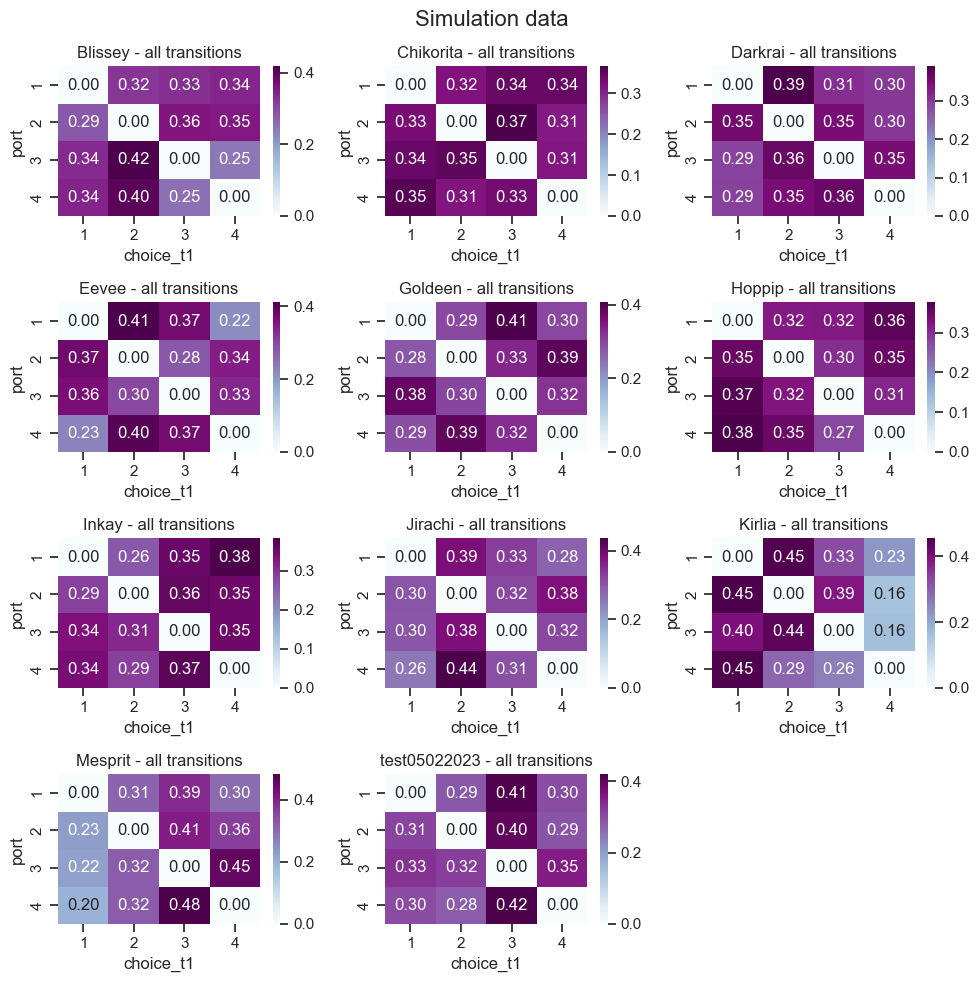

In [11]:
# full tm - all trials 
ind = 1
trialsinsess = 150
fig = plt.figure(figsize = (10,10))
mat = 0
# mask_common0 = (sessdf.task.isin(['sham']))
tempdf = sim_qldf.groupby(['animal','session#']).filter(lambda x: x.reward.size >= trialsinsess).groupby(['animal','session#']).head(trialsinsess)
for animal, group in tempdf[tempdf.shift_t0==1].groupby('animal'):
    mask_common0 = (~sessdf.task.isin(['dms','dls', 'sham', 'str', 'dms_str', 'dls_str']))
    ax = plt.subplot(4,3, ind)
    if animal == 'test05022023':
#         group = group.loc[~(sessdf.groupby('animal').get_group('test05022023').duplicated(subset = ['trialstart', 'eptime'],
#                                                                                           keep = False))]
        sns.heatmap(pd.crosstab(group.loc[mask_common0, 'port'],
                                group.loc[mask_common0, 'choice_t1'],
                                normalize = 'index',
                                dropna = False),
                    ax = ax, cmap = 'BuPu', annot = True, fmt = '.2f',
                   xticklabels = np.arange(1,5), yticklabels = np.arange(1,5))
        mat+=pd.crosstab(group.loc[mask_common0, 'port'],
                                group.loc[mask_common0, 'choice_t1'],
                                normalize = 'index',
                                dropna = False)
    else:
        sns.heatmap(pd.crosstab(group.loc[mask_common0, 'port'],
                                group.loc[mask_common0, 'choice_t1'],
                                normalize = 'index',
                                dropna = False),
                    ax = ax, cmap = 'BuPu',
                    annot = True, fmt = '.2f',
                    xticklabels = np.arange(1,5), yticklabels = np.arange(1,5))
#         if animal in fish:
        mat+=pd.crosstab(group.loc[mask_common0, 'port'],
                                group.loc[mask_common0, 'choice_t1'],
                                normalize = 'index',
                                dropna = False)
    ax.set_title(animal+' - all transitions')
    ind+=1 
plt.suptitle('Simulation data', fontsize = 16)    
plt.tight_layout()
# plt.savefig('C:/Users/dlab/rishika_sim/plots/20231210/tm_all_noswitch.png', dpi = 300)

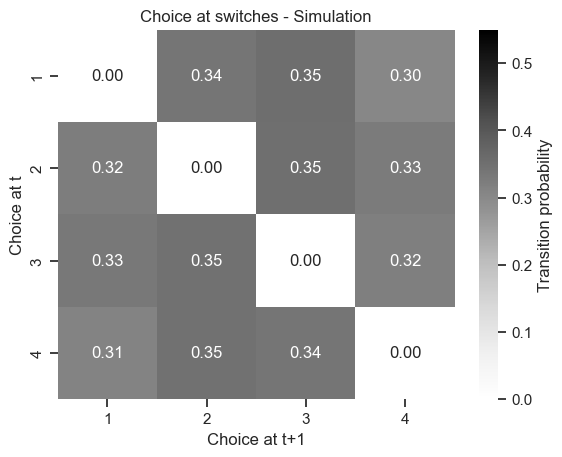

In [17]:
sns.heatmap(mat/11, annot = True, fmt = '.2f', cmap = 'Greys', xticklabels = np.arange(1,5),
            yticklabels = np.arange(1,5), vmin = 0, vmax = 0.55, cbar_kws={'label': 'Transition probability'})
plt.xlabel('Choice at t+1')
plt.ylabel('Choice at t')
plt.title('Choice at switches - Simulation')
plt.savefig('C:/Users/dlab/OneDrive - Indian Institute of Science/Drawings/plots/15012024/tm_sim.svg', dpi = 600)

In [469]:
#################################### regret ######################################
# set_cwd('/home/rishika/sim/')
window = 7
trialsinsess = 150
fig = plt.figure(figsize=(10,10))
sim_qldf['regret'] = abs(sim_qldf['rewprob']*100 - 80)
reg_mean_dict = {}
# rem_les = sessdf[~(sessdf.task.isin(['dms', 'dls', 'sham']))]

colors ={'str':'#408ec6', 'unstr':'#7a2048', 'dls':'xkcd:gold', 'dms':'r', 'sham':'b'} 
for i in ['unstr', 'str']:

    for ind, (animal, group) in enumerate(sim_qldf[sim_qldf.animal!='Fennekin'].groupby('animal')):
        ax = plt.subplot(4, 3, ind+1)
        
        # remove duplicates
#         if animal == 'test05022023':
#             group = group.loc[~(sessdf.groupby('animal').get_group('test05022023')
#                                       .duplicated(subset = 'trialstart', keep = False))]
        # filter by sessions>= length
        filtered = (group[group.task.isin([i])]
                    .groupby('session#')).filter(lambda x: x.reward.size >= trialsinsess)

        # take only those sessions
        filtered = filtered.groupby('session#').head(trialsinsess)
        
        if filtered.empty==True:
            continue
            
        # convert to numpy array
        g = filtered.groupby('session#').cumcount()
        L = np.array(filtered.set_index(['session#',g])
               .unstack(fill_value=0)
               .stack().groupby(level=0)
               .apply(lambda x: x.regret.values.tolist())
               .tolist())
        
        # mean
        reg_mean = np.mean(L, axis=0)
        reg_mean_dict[animal, i] = reg_mean
        ax.plot(reg_mean, label = i, c = colors[i])
        ax.set_title(animal)
        ax.legend()
        ax.set_xlabel('Trial')

sns.despine()
fig.supylabel('Regret, averaged across sessions')
plt.tight_layout()

In [11]:
def gen_model(dataset, hist = 5, formula_type = 'c', coef = False):
    
    # check which formula type and generate formula:
    if hist>=2:
        if formula_type == 'c':
            formula = 'choice_t0 ~ C(choice_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'r':
            formula = 'choice_t0 ~ C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'int':
            formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
            for i in range(2, hist):
                formula+='+C(choice_t'+str(i)+'):C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'cr':
            formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')*C(reward_t'+str(i)+')+'
                formula = formula[:-1]            
    else:
        if formula_type == 'c': formula = 'choice_t0 ~ C(choice_t1)'
        elif formula_type == 'r': formula = 'choice_t0 ~ C(reward_t1)'
        elif formula_type == 'int': formula = 'choice_t0 ~ C(choice_t1):C(reward_t1)'
        elif formula_type == 'cr': formula = 'choice_t0 ~ C(choice_t1)*C(reward_t1)'
            
    # generate model of given hist
    model = smf.mnlogit(formula = formula, data = dataset).fit(method = 'lbfgs', maxiter = 100, disp = False)
    
    # pack scores 
    scores = (model.aic, model.bic, model.prsquared)
    if coef == True:
        coef = model.params
        coef_names = model.params.index
        return model, scores, coef, coef_names
    return model, scores

def mnlogit_runner(dataset, hist = 5, formula_type = 'c'):
    aic_hist, bic_hist, prsquared_hist = [], [], []
    
    for i in range(hist):
        model, scores = gen_model(dataset, i, formula_type)
        aic, bic, prsquared = scores
        aic_hist.append(aic)
        bic_hist.append(bic)
        prsquared_hist.append(prsquared)
    scores_hist = (aic_hist, bic_hist, prsquared_hist)
    return scores_hist

In [5]:
import numpy as np
import pandas as pd
def gen_qvalues(dataset, params, arms = 4):
    dataset['all_p_qvalue_v'] = np.zeros(dataset.shape[0])
    dataset['all_p_qvalue_b'] = np.zeros(dataset.shape[0])
    dataset['all_qvalue'] = np.zeros(dataset.shape[0])
    dataset[['all_p_qvalue_v', 'all_p_qvalue_b', 'all_qvalue']]=dataset[['all_p_qvalue_v', 'all_p_qvalue_b', 'all_qvalue']].astype('object')

    alpha, tau, bias_arm1, bias_arm2, bias_arm3, bias_arm4 = params

    ll_b, ll_v = 0, 0
    p1, p = 0, 0
    q = np.zeros(arms)

    for sessnum, group in dataset.groupby('session#'):
        q = np.zeros(arms)
        for ind, trial in group.iterrows():

            #bias = [bias_arm1, bias_arm2, bias_arm3, bias_arm4] 
            bias = np.array([bias_arm1, bias_arm2, bias_arm3, bias_arm4]) 

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+bias))
            P = P/ np.sum(P)
            P1 = np.exp(invtemp*q)
            P1 = P1/ np.sum(P1)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p = np.append(p, P[index])
            p1 = np.append(p1, P1[index])
            dataset['all_p_qvalue_v'].loc[ind] = list(P1)
            dataset['all_p_qvalue_b'].loc[ind] = list(P)

            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            dataset['all_qvalue'].loc[ind] = list(q)

    ll_b += np.nansum(np.log(p[1:]))
    ll_v += np.nansum(np.log(p1[1:]))

    return dataset, ll_v, ll_b

In [7]:
################################### for running switch prediction glms
def gen_model_logit(dataset, hist = 5, formula_type = 'c'):
    
    # check which formula type and generate formula:
    if hist>=2:
        if formula_type == 'c':
            formula = 'shift_t0 ~ C(choice_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'r':
            formula = 'shift_t0 ~ C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'int':
            formula = 'shift_t0 ~ C(choice_t1):C(reward_t1)'
            for i in range(2, hist):
                formula+='+C(choice_t'+str(i)+'):C(reward_t'+str(i)+')+'
                formula = formula[:-1]

        elif formula_type == 'cr':
            formula = 'shift_t0 ~ C(choice_t1)*C(reward_t1)'
            for i in range(2,hist):
                formula+='+C(choice_t'+str(i)+')*C(reward_t'+str(i)+')+'
                formula = formula[:-1]            
    else:
        if formula_type == 'c': formula = 'shift_t0 ~ C(choice_t1)'
        elif formula_type == 'r': formula = 'shift_t0 ~ C(reward_t1)'
        elif formula_type == 'int': formula = 'shift_t0 ~ C(choice_t1):C(reward_t1)'
        elif formula_type == 'cr': formula = 'shift_t0 ~ C(choice_t1)*C(reward_t1)'
            
    # generate model of given hist
    model = smf.glm(formula = formula, data = dataset, family = sm.families.Binomial()).fit(maxiter = 100)
    
    # pack scores 
    scores = (model.aic, model.bic_llf, model.pseudo_rsquared(kind = 'mcf'))
    
    return model, scores

def switchglm_runner(dataset, hist = 5, formula_type = 'c'):
    aic_hist, bic_hist, prsquared_hist = [], [], []
    for i in range(hist):
        model, scores = gen_model_logit(dataset, i, formula_type)
        aic, bic, prsquared = scores
        aic_hist.append(aic)
        bic_hist.append(bic)
        prsquared_hist.append(prsquared)
    scores_hist = (aic_hist, bic_hist, prsquared_hist)
    return scores_hist

In [16]:
##################################### model_eval with modifications for glm
arms = 4
from sklearn.metrics import accuracy_score, balanced_accuracy_score, multilabel_confusion_matrix
def model_eval(model, dataset, categories = np.arange(1, 1+arms), prediction_of = 'choice_t0', return_shiftcm = False):
    
    # this takes the last model i.e. 20 trial history by default
    predictions = model.predict(dataset)
    if len(dataset[prediction_of].unique())>2:
        predicted=[np.sort(dataset[prediction_of].unique())[np.asarray(predictions).argmax(1)[i]] for i in range(len(predictions))]
        p = [predictions.loc[r,:][np.asarray(predictions).argmax(1)[ind]] for ind, r in enumerate(predictions.index)]
    else: 
        predicted = [0 if x < 0.5 else 1 for x in predictions]
        p = predictions

    dataset['predicted'] = pd.Categorical(predicted, categories = categories)
    dataset['p_predicted'] = p
    dataset['predicted_t1'] = pd.Categorical(predicted, categories = categories).shift(1)
    dataset['pred_shift_t0'] = (dataset['predicted']==dataset['predicted_t1']).replace({True: 0, False: 1})
    
    # cm, accuracy
    cm = multilabel_confusion_matrix(dataset[prediction_of], dataset.predicted)
    if len(dataset[prediction_of].unique())>2:
        accuracy = accuracy_score(dataset[prediction_of], dataset.predicted)
    else:
        accuracy = accuracy_score(dataset[dataset.shift_t0==1][prediction_of], dataset[dataset.shift_t0==1].predicted)
    full_cm = pd.crosstab(dataset[prediction_of], dataset.predicted, normalize = 'index', dropna = False)
    if return_shiftcm == True:
        shift_cm = pd.crosstab(dataset.shift_t0,
                              dataset.pred_shift_t0,
                              normalize = 'index',
                              dropna = False)
        return cm, accuracy, full_cm, shift_cm
    # generate a plot of predictions
    #################################
    return cm, accuracy, full_cm

In [14]:
def score_plot(scores, title = ['AIC', 'BIC', 'Pseudo-R squared']):
    
    # returns best model based on bic
    if np.isnan(np.array(scores[1])).all()==True: best_model = 1 
    else: best_model = 1+np.where(scores[1]==np.nanmin(scores[1]))[0][0]
    return best_model

In [565]:
############################### predicting when animal is going to switch - glm

# do: for all datasets
set_cwd('/home/rishika/sim/')
from regressionFunctions import score_plot

# which animals can be used
animal_ref = {'Box1':'test05022023',
              'Box2':'Blissey',
              'Box3':'Chikorita',
              'Box4':'Darkrai',
              'Box5':'Eevee',
              'Box7':'Hoppip',
              'Box8':'Inkay',
              'Box9':'Jirachi',
              'Box10':'Kirlia'}

# which dictionaries of data to use
# all_dicts = [str_sess_dict, new_unstr_sess_dict, old_unstr_sess_dict, dms_unstr_sess_dict]
# prefixes = ['str', 'new_unstr', 'old_unstr', 'dms_unstr']

# how much history
hist = 10

# data saving
switchglmdf = pd.DataFrame()

# go through the dataset dict
pd.options.mode.chained_assignment = None

for animal, dataset in full_df.groupby('animal'):
    
    # generate models and scores of each trial history - train on 2 datasets - full, switchonly
#     halfswitch = dataset.groupby('shift_t0').sample(n = dataset.shift_t0.value_counts().min()).sort_values(by = 'trial#')
    switchonly = dataset[dataset.shift_t0==1]
    
    model_name = ['Choice', 'Reward', 'Interactions', 'Full']
    scores_full = np.array([switchglm_runner(dataset, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_switchonly = np.array([switchglm_runner(switchonly, hist, i) for i in ['c', 'r', 'int', 'cr']])
    
#         # get the best trial history from bic scores
#     best_ln = [score_plot(i) for i in scores]
#     best_len_c, best_len_r, best_len_int, best_len_cr = best_ln

#     # regenerate best model with length of cr model
#     best_models = [gen_model_logit(dataset, best_ln[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
#     best_model_c, best_model_r, best_model_int, best_model_cr = best_models

#     # evaluate model on full dataset - model_eval(model, testing dataset)
    kwargs = {'categories':[0,1], 'return_shiftcm':False, 'prediction_of':'shift_t0'}
    
    # get the best trial history from bic scores
    best_ln = [score_plot(i) for i in scores_full]
    best_ln_switchonly = [score_plot(i) for i in scores_switchonly]
    
    # store best trial history separately for each model
    best_len_c, best_len_r, best_len_int, best_len_cr = best_ln
    best_len_c_switchonly, best_len_r_switchonly, best_len_int_switchonly, best_len_cr_switchonly = best_ln_switchonly
#     best_len_c_halfswitch, best_len_r_halfswitch, best_len_int_halfswitch, best_len_cr_halfswitch = best_ln_halfswitch
    
    # regenerate best model
    best_models = [gen_model_logit(dataset, best_ln[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_switchonly = [gen_model_logit(switchonly, best_ln_switchonly[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
#     best_models_halfswitch = [gen_model(halfswitch, best_ln_halfswitch[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    
    # unpack best models by category
    best_model_c, best_model_r, best_model_int, best_model_cr = best_models
#     best_model_c_halfswitch, best_model_r_halfswitch, best_model_int_halfswitch, best_model_cr_halfswitch = best_models_halfswitch
    best_model_c_switchonly, best_model_r_switchonly, best_model_int_switchonly, best_model_cr_switchonly = best_models_switchonly

    # evaluate model on full dataset - model_eval(model, testing dataset)
    # training full, prediction full and plot full and switchonly
    print()
    cm_c, accuracy_c, full_cm_c= model_eval(best_model_c[0], dataset, **kwargs)
    cm_r, accuracy_r, full_cm_r = model_eval(best_model_r[0], dataset, **kwargs)
    cm_int, accuracy_int, full_cm_int = model_eval(best_model_int[0], dataset, **kwargs)
    cm_cr, accuracy_cr, full_cm_cr = model_eval(best_model_cr[0], dataset, **kwargs)
    baccuracy_c = np.diag(full_cm_c).mean()
    baccuracy_r = np.diag(full_cm_r).mean()
    baccuracy_int = np.diag(full_cm_int).mean()
    baccuracy_cr = np.diag(full_cm_cr).mean()
    
    # training full, prediction switchonly
    _, accuracy_c_test_switchonly, full_cm_c_test_switchonly = model_eval(best_model_c[0], switchonly, **kwargs)
    _, accuracy_r_test_switchonly, full_cm_r_test_switchonly = model_eval(best_model_r[0], switchonly, **kwargs)
    _, accuracy_int_test_switchonly, full_cm_int_test_switchonly = model_eval(best_model_int[0], switchonly, **kwargs)
    _, accuracy_cr_test_switchonly, full_cm_cr_test_switchonly = model_eval(best_model_cr[0], switchonly, **kwargs)
    baccuracy_c_test_switchonly = np.diag(full_cm_c_test_switchonly).mean()
    baccuracy_r_test_switchonly = np.diag(full_cm_r_test_switchonly).mean()
    baccuracy_int_test_switchonly = np.diag(full_cm_int_test_switchonly).mean()
    baccuracy_cr_test_switchonly = np.diag(full_cm_cr_test_switchonly).mean()
    
    # training switchonly, prediction full
    _, accuracy_c_switchonly, full_cm_c_switchonly = model_eval(best_model_c_switchonly[0], switchonly, **kwargs)
    _, accuracy_r_switchonly, full_cm_r_switchonly = model_eval(best_model_r_switchonly[0], switchonly, **kwargs)
    _, accuracy_int_switchonly, full_cm_int_switchonly = model_eval(best_model_int_switchonly[0], switchonly, **kwargs)
    _, accuracy_cr_switchonly, full_cm_cr_switchonly = model_eval(best_model_cr_switchonly[0], switchonly, **kwargs)
    baccuracy_c_switchonly = np.diag(full_cm_c_switchonly).mean()
    baccuracy_r_switchonly = np.diag(full_cm_r_switchonly).mean()
    baccuracy_int_switchonly = np.diag(full_cm_int_switchonly).mean()
    baccuracy_cr_switchonly = np.diag(full_cm_cr_switchonly).mean()
    
    # training switchonly, prediction switchonly
    _, accuracy_c_switchonly_test_switchonly, full_cm_c_switchonly_test_switchonly = model_eval(best_model_c_switchonly[0], switchonly, **kwargs)
    _, accuracy_r_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly = model_eval(best_model_r_switchonly[0], switchonly, **kwargs)
    _, accuracy_int_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly = model_eval(best_model_int_switchonly[0], switchonly, **kwargs)
    _, accuracy_cr_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly = model_eval(best_model_cr_switchonly[0], switchonly, **kwargs)
    baccuracy_c_switchonly_test_switchonly = np.diag(full_cm_c_switchonly_test_switchonly).mean()
    baccuracy_r_switchonly_test_switchonly = np.diag(full_cm_r_switchonly_test_switchonly).mean()
    baccuracy_int_switchonly_test_switchonly = np.diag(full_cm_int_switchonly_test_switchonly).mean()
    baccuracy_cr_switchonly_test_switchonly = np.diag(full_cm_cr_switchonly_test_switchonly).mean()
    
    # scores plot
    fig, ax = plt.subplots(scores.shape[0], scores.shape[1], figsize = (10,10))
    title = ['AIC', 'BIC', 'Pseudo R squared']
    color = ['b', 'r', 'g']
    # returns score plot 
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            ax[i, j].plot(np.arange(1, len(scores[i, j])+1), scores[i,j], c = color[j])
            ax[i, j].set_title(title[j])
            ax[i, j].set_xlabel('Trial history')
            ax[i, j].set_xlim(1,len(scores[i,j])+1)
    #             best_model = 1+np.where(scores[i,j]==min(scores[i,j]))[0][0]
    #         ax[i, j].axvline(best_model, color='r')
        ax2 = ax[i,j].twinx()
        ax2.set_ylabel(f'{model_name[i]} model')
        ax2.set_yticks([])

    sns.despine()
    plt.suptitle('Model Scores')
    plt.tight_layout()
#         plt.savefig(f'plots/10102023/{prefix}model_scores_switch_{animal}.png', dpi = 300)

     # draw confusion matrices for testing on full dataset
    cms = np.array([cm_c, cm_r, cm_int, cm_cr])

    fname = 'full'
    title = '- Testing all choices'
    fig, ax = plt.subplots(nrows = cms.shape[0], ncols = cms.shape[1], sharex = True, sharey = True, figsize = (7,7))
    row = 0

    for cm in cms:
        for i in range(len(cm)):
            sns.heatmap(row_norm(cm[i,:,:]), annot = True, cmap = 'Greys', fmt = '.2',
                        linewidth = .5,
                        cbar = False, ax = ax[row,i])
#                 ax[row,i].set_title(f'Port {i+1}')
            ax[row,i].tick_params(left=False, bottom=False, right = False)

        ax2 = ax[row,i].twinx()
        ax2.set_ylabel(f'{model_name[row]} model')
        ax2.set_yticks([])
        ax[row,i].tick_params(left = False)
        row+=1
    fig.supxlabel('predicted')
    fig.supylabel('actual')
    plt.suptitle(f'Confusion matrices {title}')
    sns.despine(fig = fig, bottom = True, left = True)
    plt.tight_layout()
#         plt.savefig(f'plots/10102023/{prefix}cm_{animal}_train_switch_{fname}.png', dpi = 300)


    # plot full conf matrix 
    full_cm = (full_cm_c, full_cm_r, full_cm_int, full_cm_cr)

    fig = plt.figure(figsize=(8,7))
    plotnum = 1
    for cm in full_cm:
        ax = plt.subplot(2,2,plotnum)
        sns.heatmap(cm, annot = True, cmap = 'Greys', fmt = '.2',
                    linewidth = .7,
                    cbar = False, vmin = 0, vmax = 1)
        ax.set_ylabel('actual')
        ax.set_xlabel('predicted')
        ax.tick_params(axis='both', which='both', length=0)
        plt.yticks(rotation = 0)

        ax2 = ax.twinx()
        ax2.set_ylabel(f'{model_name[plotnum-1]} model')
        ax2.set_yticks([])
        plotnum+=1
        sns.despine(left = True, bottom = True)

    plt.suptitle('Confusion matrices for models')

    counts = list(dataset.groupby('shift_t0').shift_t0.count())
    for i in range(len(counts)):
        ax.text(2.5, ax.get_yticks()[i], counts[i])
    plt.tight_layout()
#         plt.savefig(f'plots/10102023/{prefix}fullcm_{animal}_train_switch_{fname}.png', dpi = 300)

    # saving
    # store data in a df
    ddict = [
        {'model':'choice', 'animal':animal,'train_on':'full', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull, 'bal_accuracy':baccuracy_c},
    {'model':'reward', 'animal':animal,'train_on':'full', 'best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r,'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r},
    {'model':'interactions', 'animal':animal, 'train_on':'full','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull, 'bal_accuracy':baccuracy_int},
    {'model':'full', 'animal':animal, 'train_on':'full','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr},
    {'model':'choice', 'animal':animal, 'train_on':'full','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_test_switchonly, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull,'bal_accuracy':baccuracy_c_test_switchonly},
    {'model':'reward', 'animal':animal,'train_on':'full', 'best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_test_switchonly, 'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r_test_switchonly},
    {'model':'interactions', 'animal':animal,'train_on':'full', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_test_switchonly, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull,'bal_accuracy':baccuracy_int_test_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'full', 'best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_test_switchonly, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr_test_switchonly},
#     {'model':'choice', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_halfswitch, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch},
#     {'model':'reward', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_halfswitch, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull,'bal_accuracy':baccuracy_r_halfswitch},
#     {'model':'interactions', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_halfswitch, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch},
#     {'model':'full', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_halfswitch, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull, 'bal_accuracy':baccuracy_cr_halfswitch},
#     {'model':'choice', 'animal':animal,'train_on':'halfswitch', 'best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_halfswitch_test_switchonly, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch_test_switchonly},
#     {'model':'reward', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_halfswitch_test_switchonly, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull, 'bal_accuracy':baccuracy_r_halfswitch_test_switchonly},
#     {'model':'interactions', 'animal':animal,'train_on':'halfswitch', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_halfswitch_test_switchonly, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch_test_switchonly},
#     {'model':'full', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_halfswitch_test_switchonly, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull,'bal_accuracy':baccuracy_cr_halfswitch_test_switchonly},
    {'model':'choice', 'animal':animal, 'train_on':'switchonly', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly},
    {'model':'reward', 'animal':animal, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly},
    {'model':'interactions', 'animal':animal, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly},
    {'model':'choice', 'animal':animal, 'train_on':'switchonly','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_switchonly_test_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly_test_switchonly},
    {'model':'reward', 'animal':animal, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_switchonly_test_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly_test_switchonly},
    {'model':'interactions', 'animal':animal, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_switchonly_test_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly_test_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_switchonly_test_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly_test_switchonly}]

    switchglmdf = pd.concat([switchglmdf,pd.DataFrame(ddict)], ignore_index = True)
    plt.close()
pd.options.mode.chained_assignment = 'warn'

In [143]:
############################################ making dfs for full datasets
# which animals can be used
animal_ref = {'Box1':'test05022023',
              'Box2':'Blissey',
              'Box3':'Chikorita',
              'Box4':'Darkrai',
              'Box5':'Eevee',
              'Box7':'Hoppip',
              'Box8':'Inkay',
              'Box9':'Jirachi',
              'Box10':'Kirlia'}

# which dictionaries of data to use
all_dicts = [str_sess_dict, new_unstr_sess_dict, old_unstr_sess_dict, dms_unstr_sess_dict]
prefixes = ['str', 'new_unstr', 'old_unstr', 'dms_unstr']
full_df = pd.DataFrame()

for k, dictionary in enumerate(all_dicts):
    prefix = prefixes[k]
    
    for key in dictionary.keys():

        sessdf = dictionary[key]
        # prep dataset with trial history 
        dataset = data_prep(sessdf, hist = 10, trialsinsess = 75, head = True)
        
        # animal name
        if dictionary==dms_unstr_sess_dict: animal = key
        else: 
            try: 
                animal = [animal_ref[s] for s in list(animal_ref.keys()) if key.split('/')[-1] in s][0]
            except IndexError:
                break
        print(key, animal, prefix)
        dataset['animal'] = animal
        dataset['task'] = prefix
        full_df = pd.concat([full_df, dataset], ignore_index = True)
dms_df = full_df[full_df.task == 'dms_unstr']
full_df = full_df[full_df.task != 'dms_unstr']

/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 str
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey str
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita str
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai str
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee str
/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee new_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box1 test05022023 old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box2 Blissey old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box3 Chikorita old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box4 Darkrai old_unstr
/home/rishika/sim/NAS_rishika/4portProb/Box5 Eevee old_unstr
Eevee Eevee dms_unstr
Chikorita Chikorita dms_unstr


/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishik

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/m

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/rishika/minicon

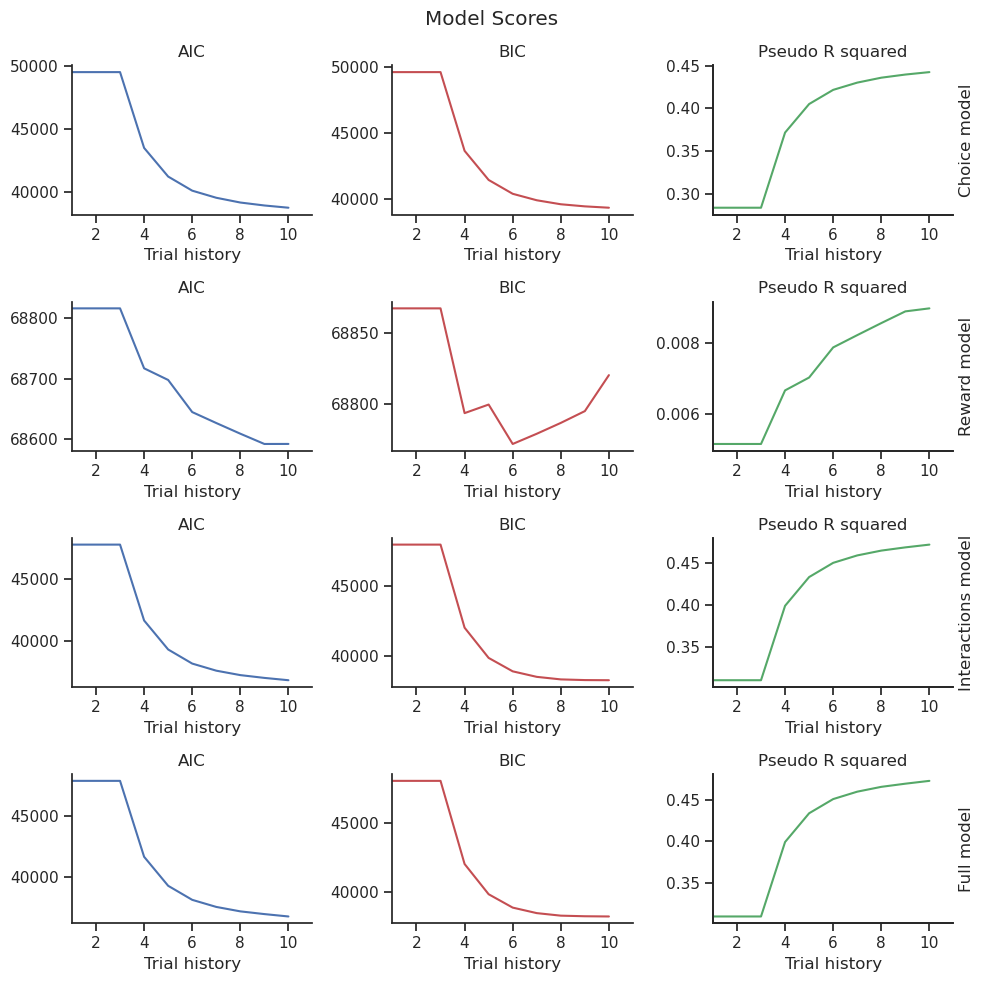

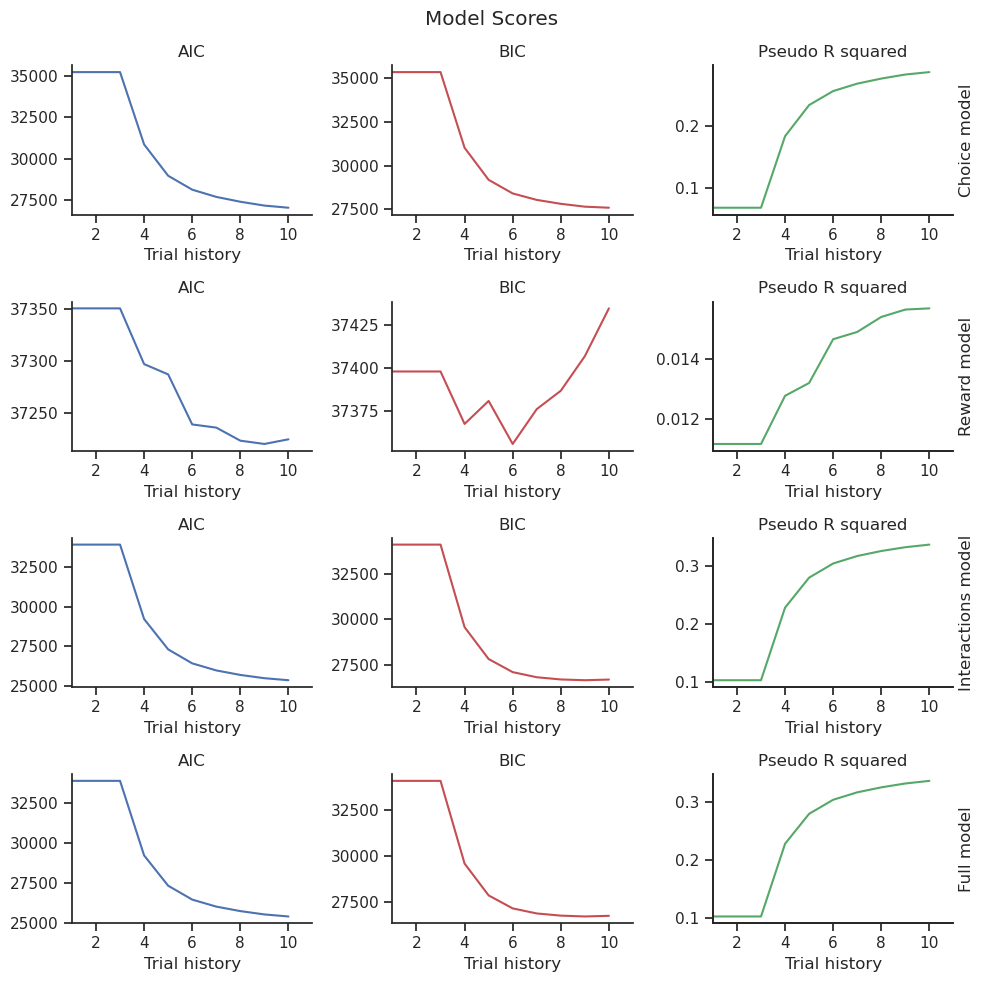

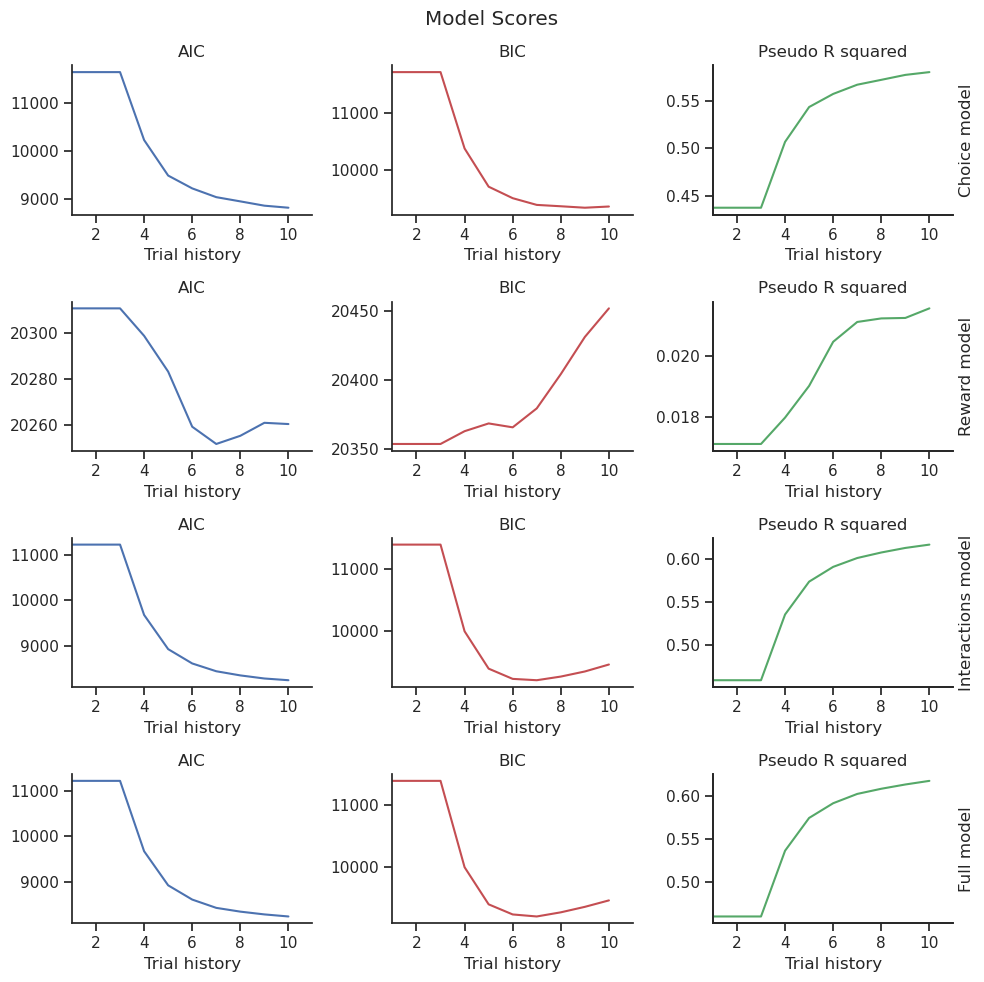

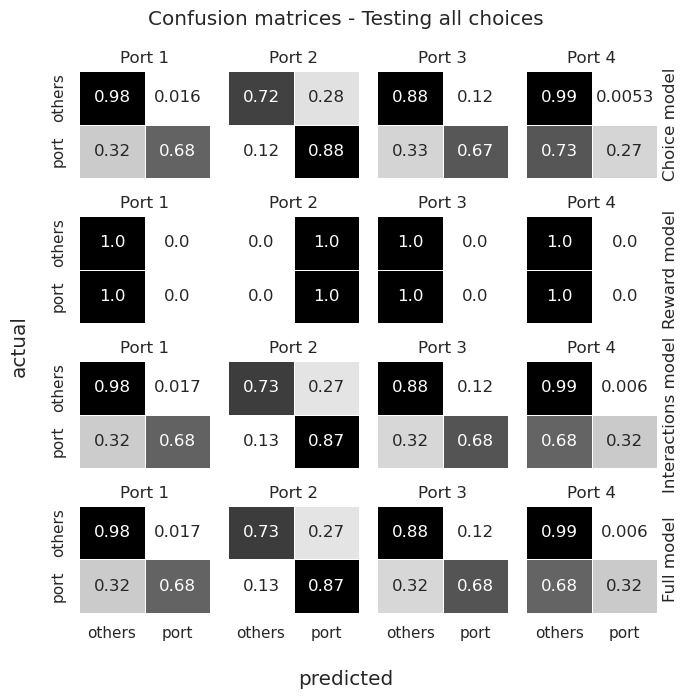

<Figure size 800x700 with 0 Axes>

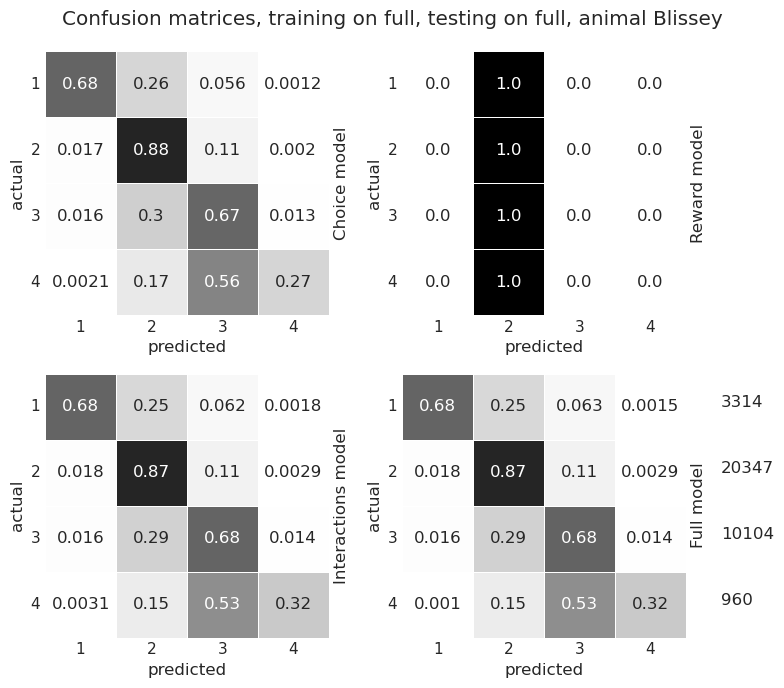

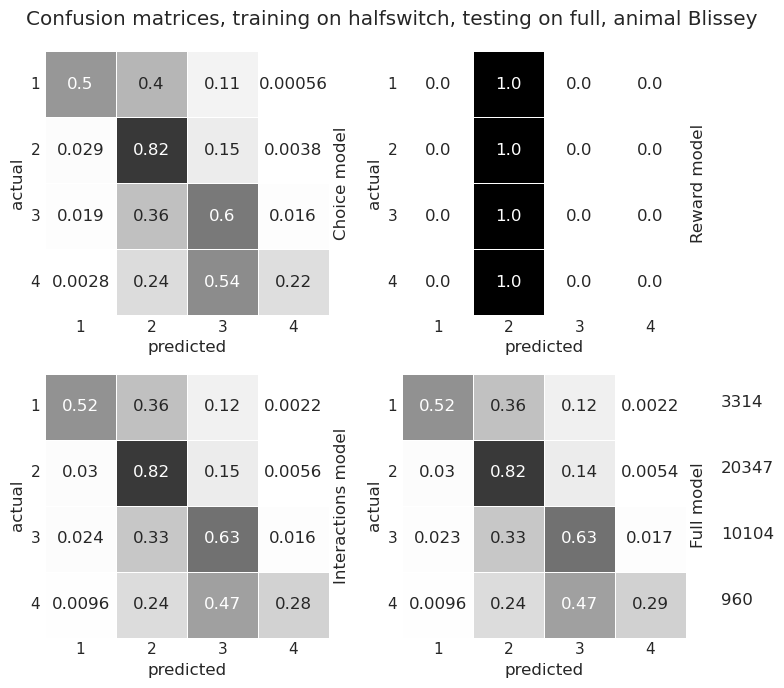

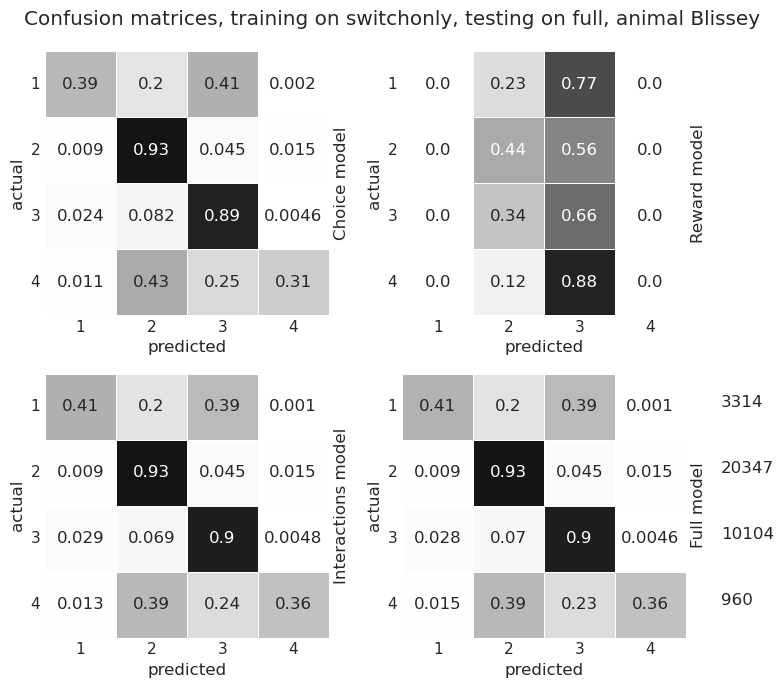

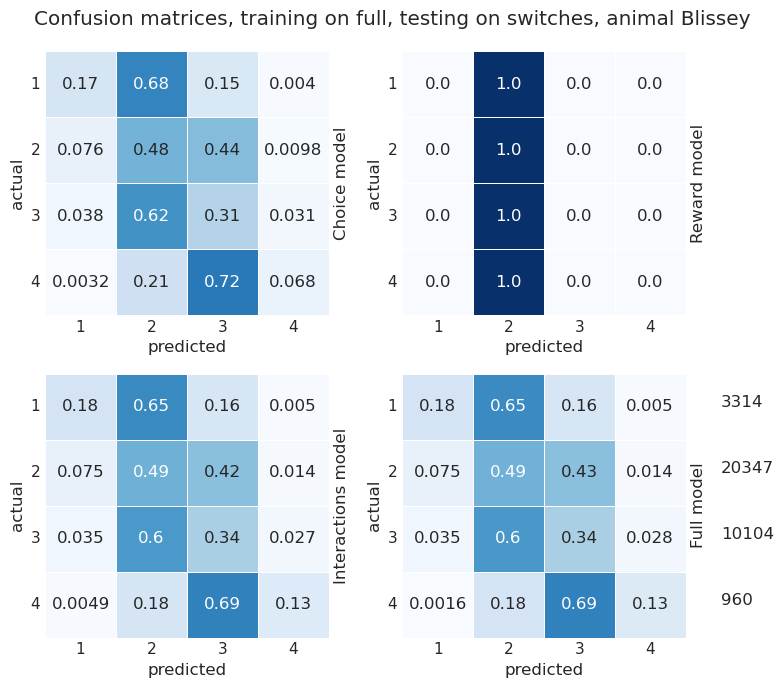

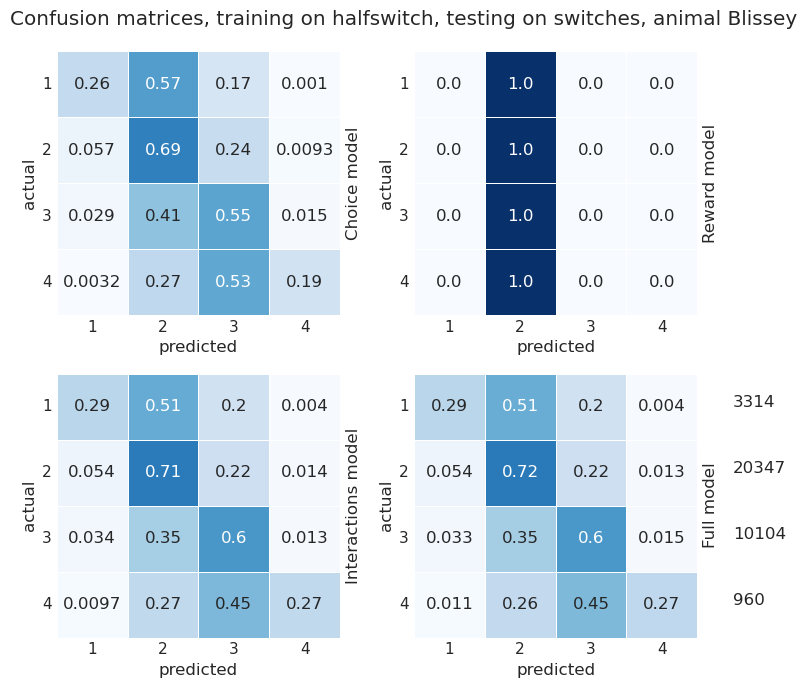

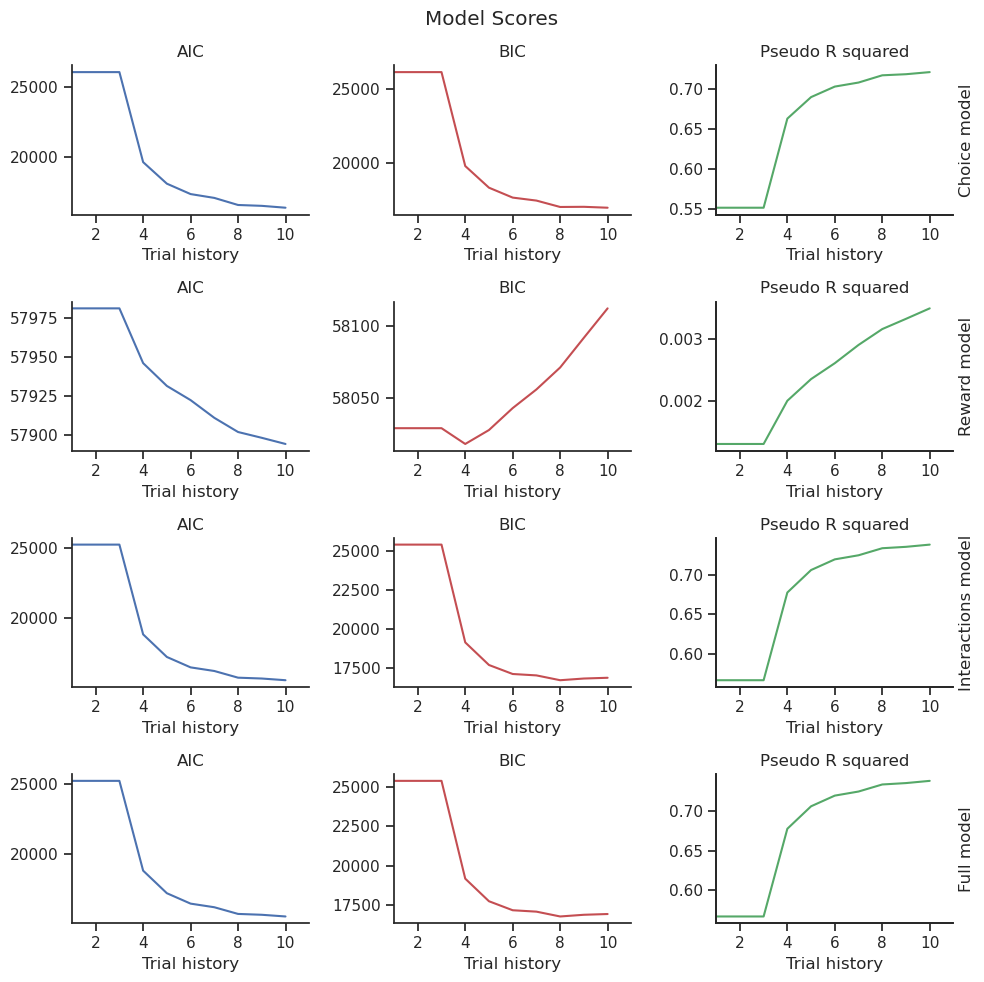

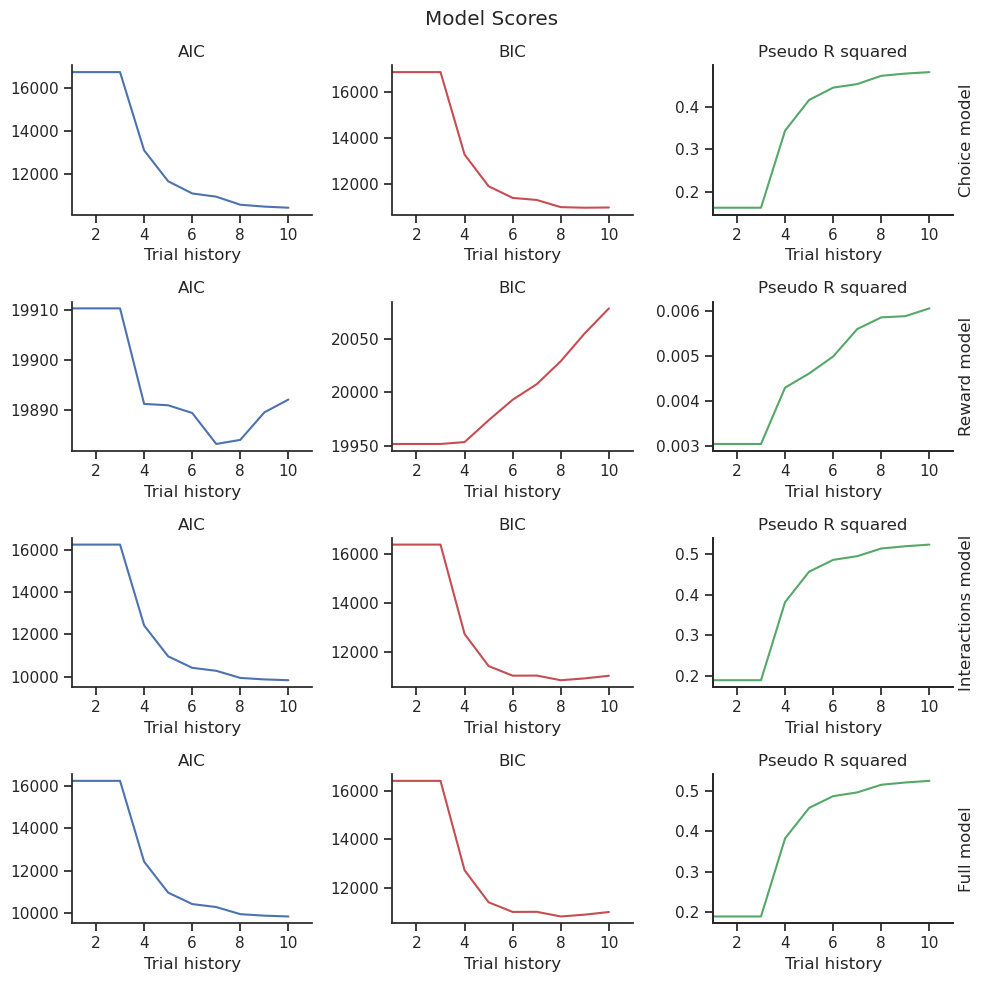

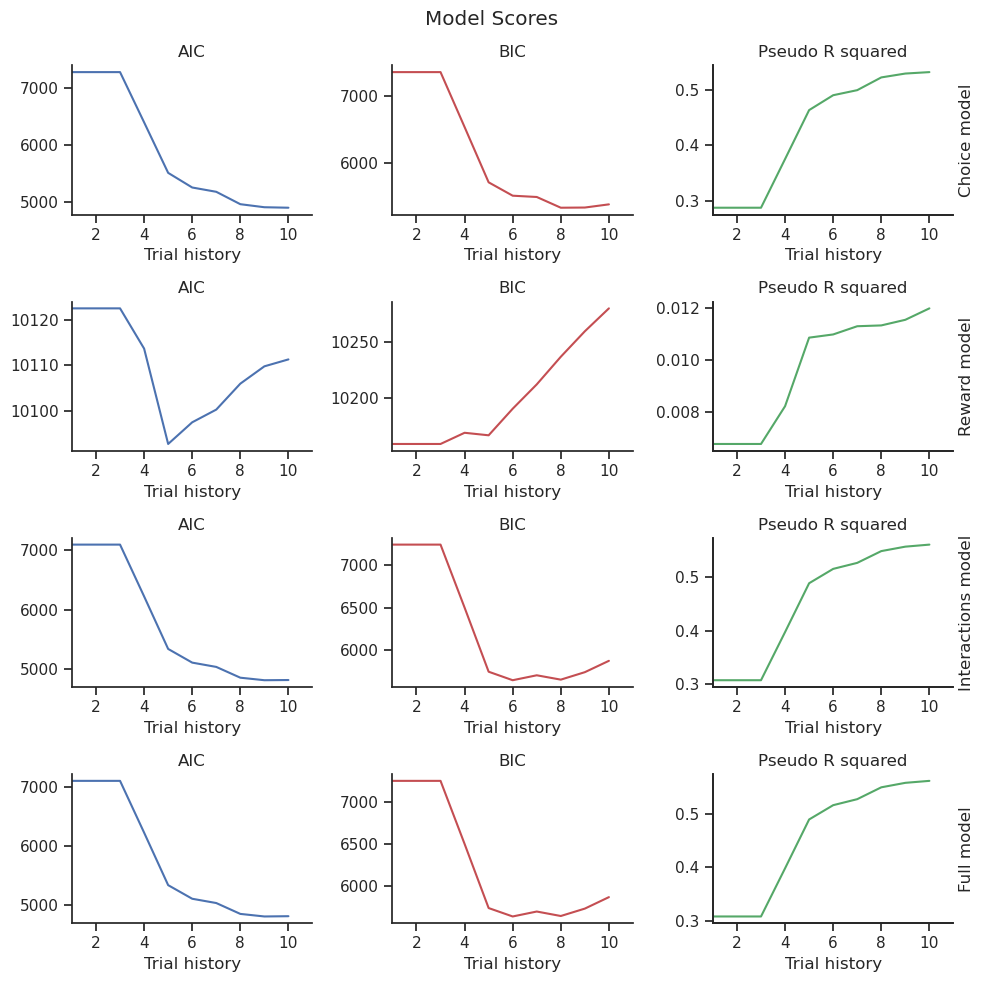

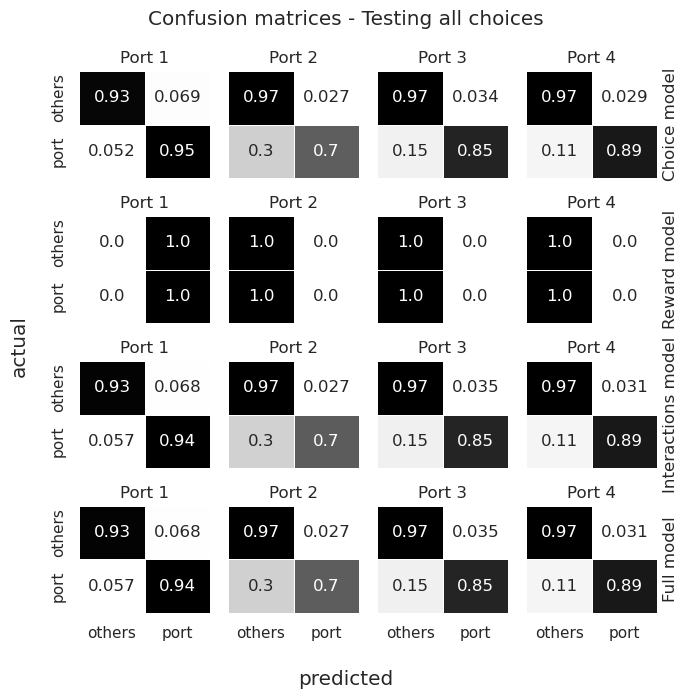

<Figure size 800x700 with 0 Axes>

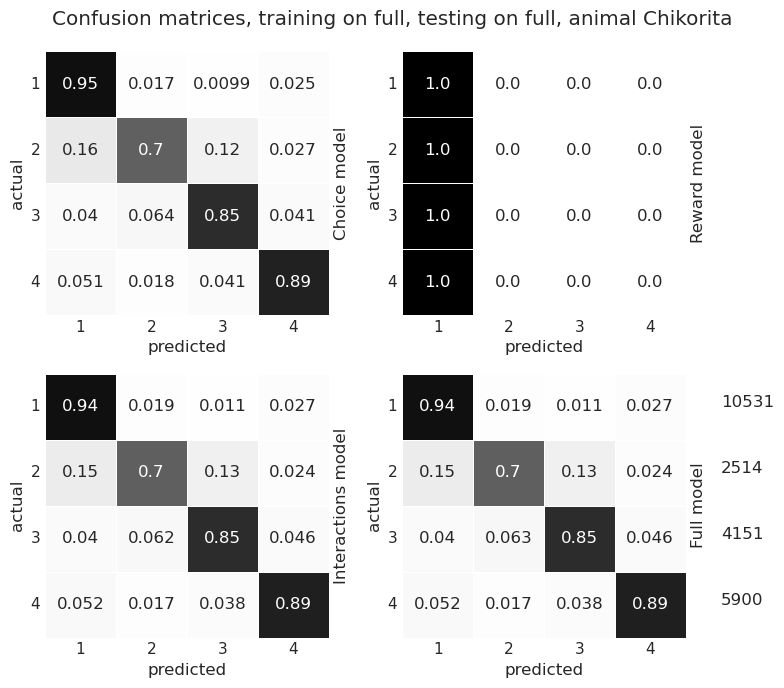

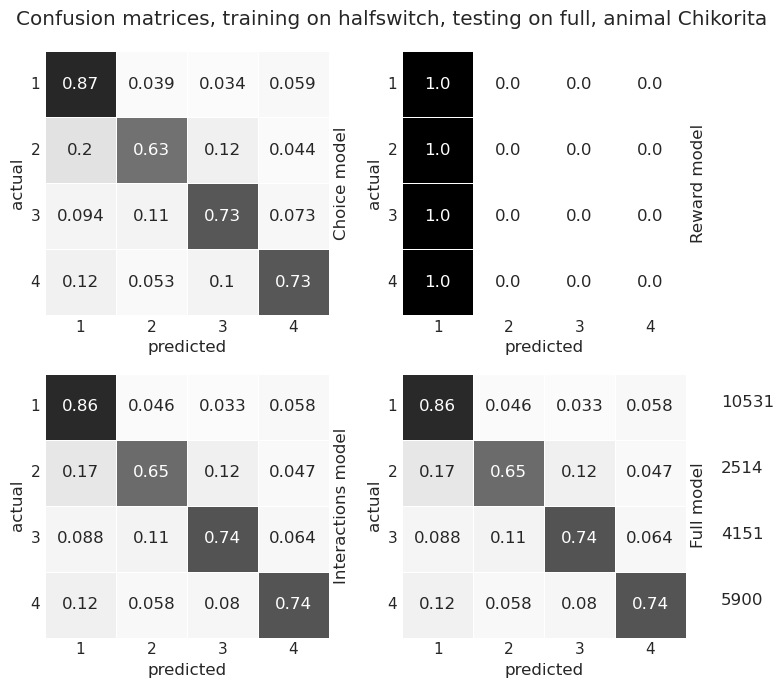

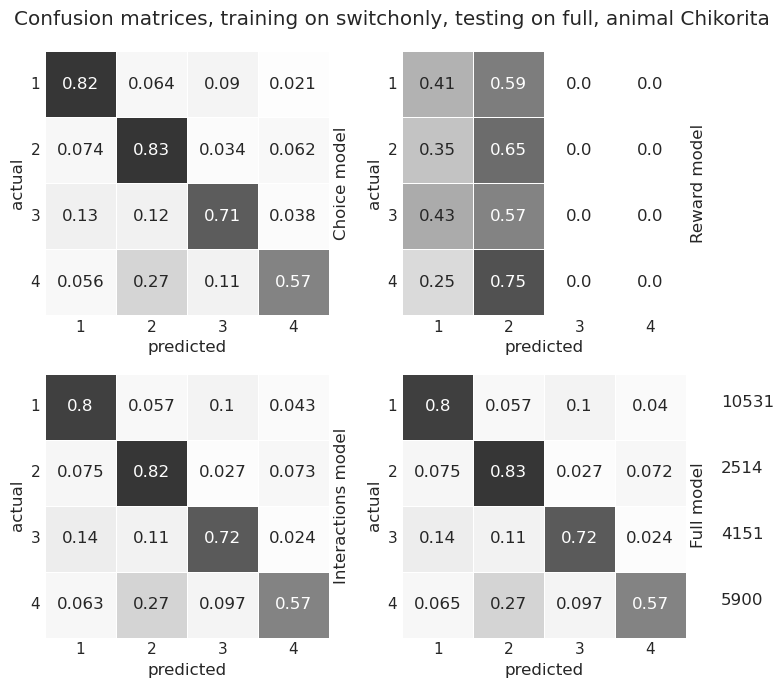

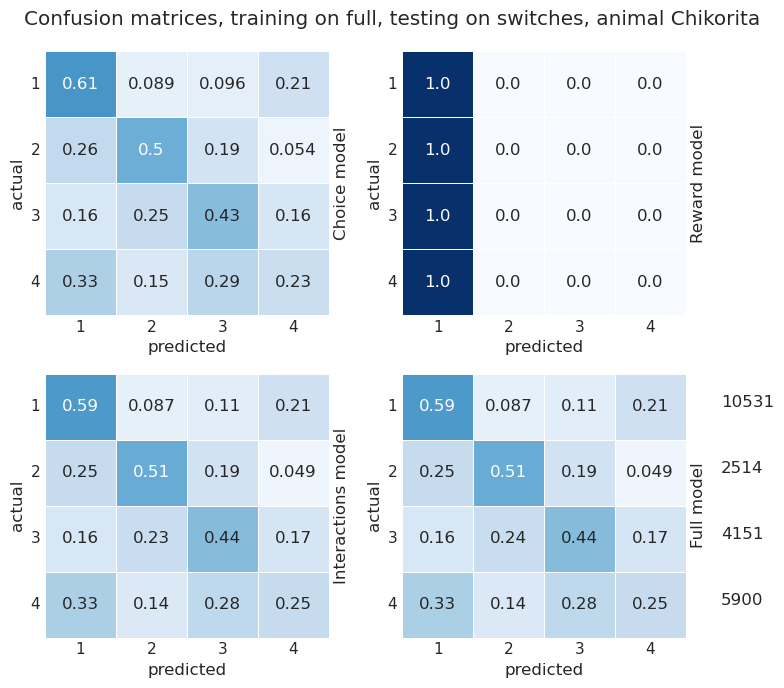

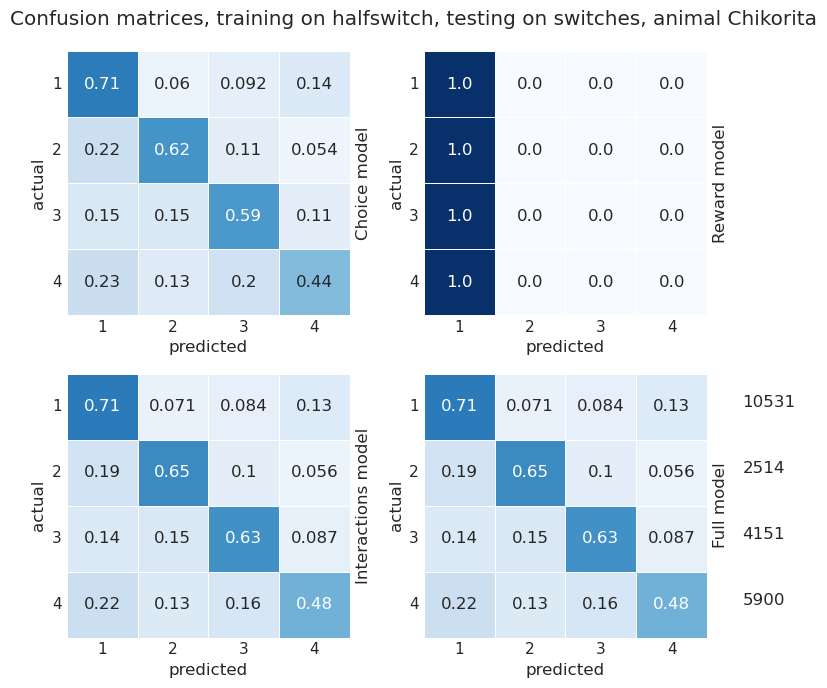

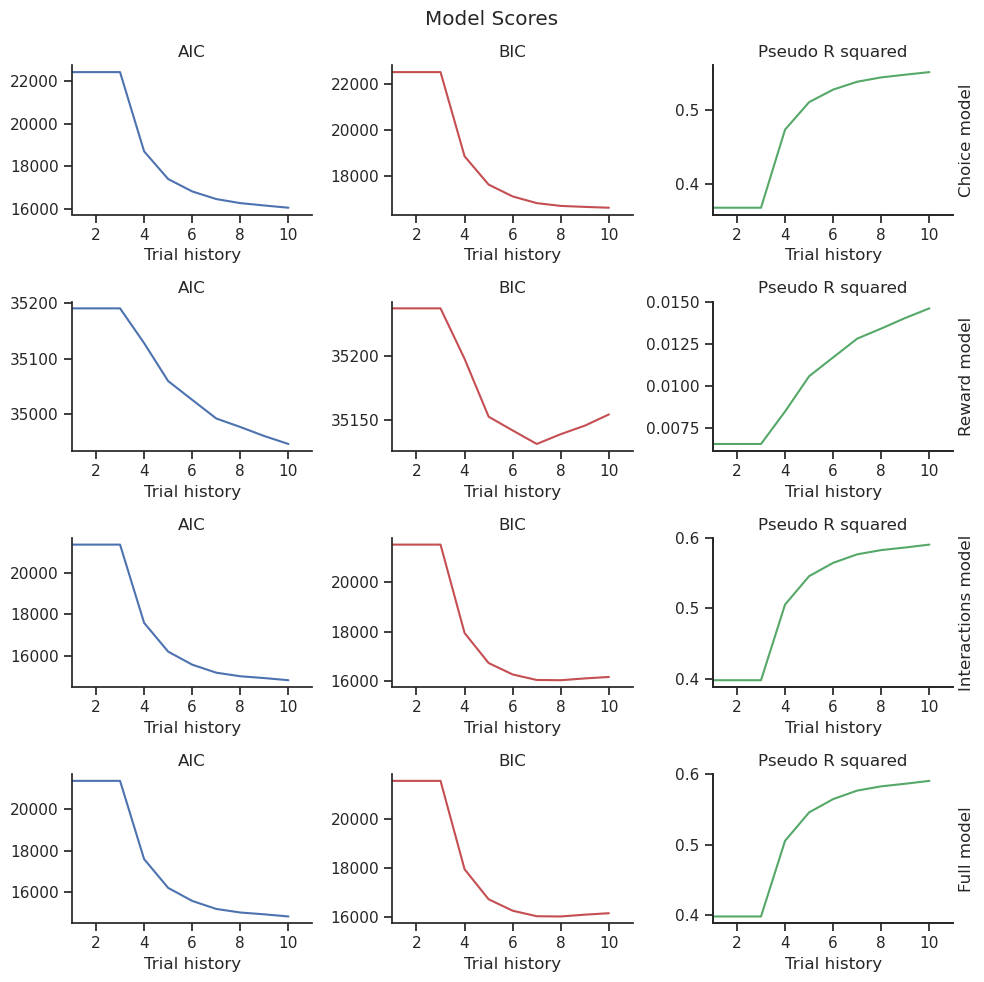

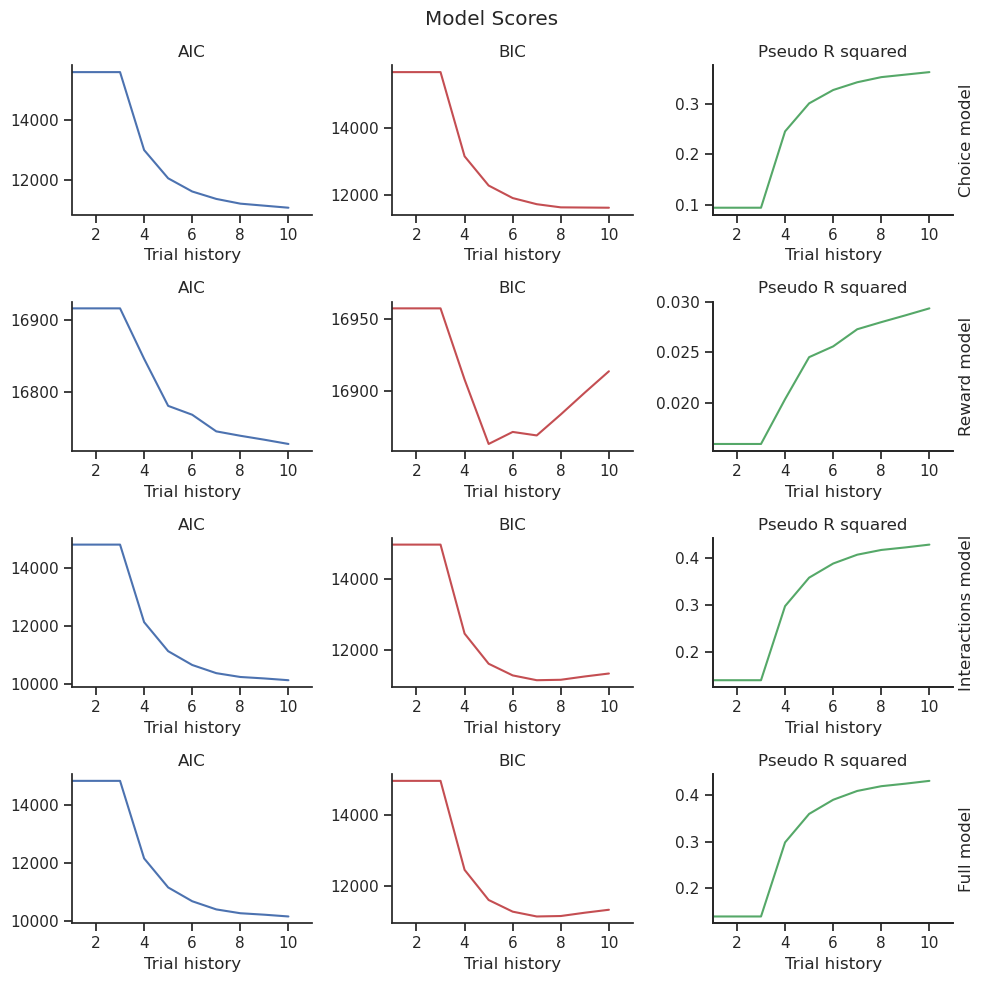

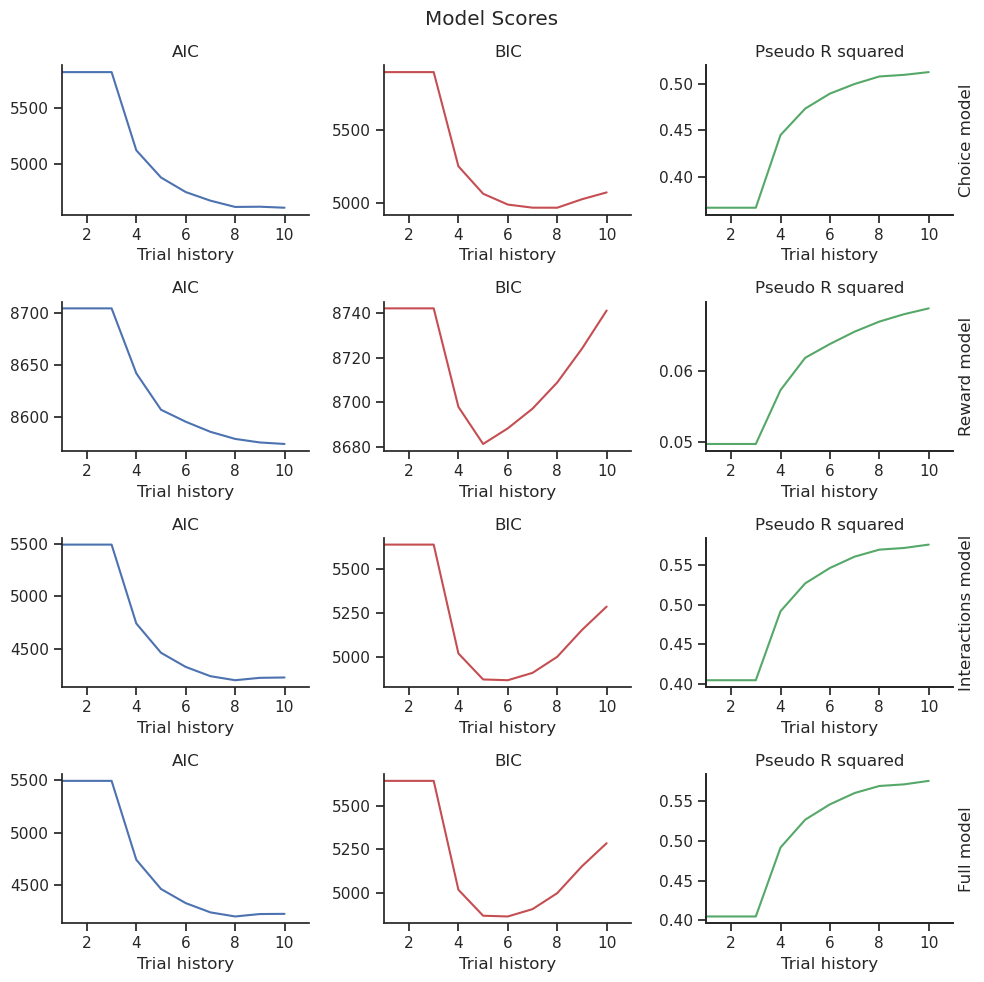

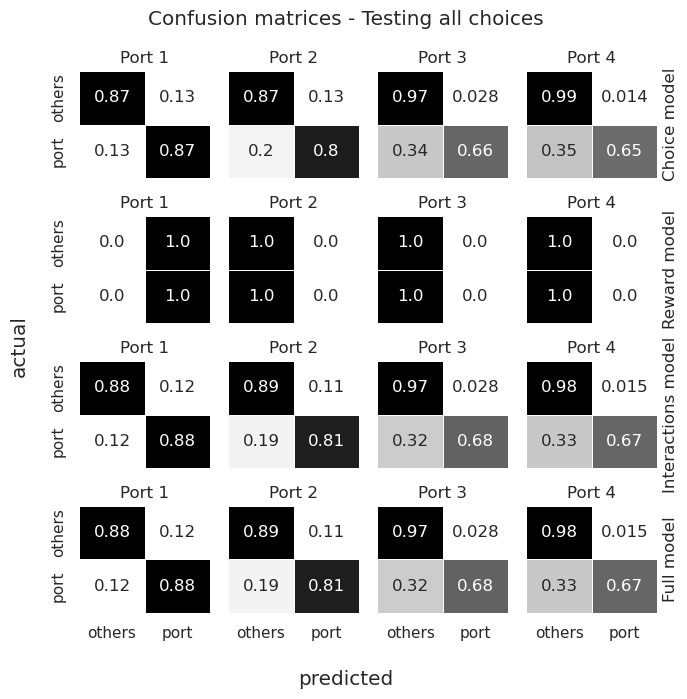

<Figure size 800x700 with 0 Axes>

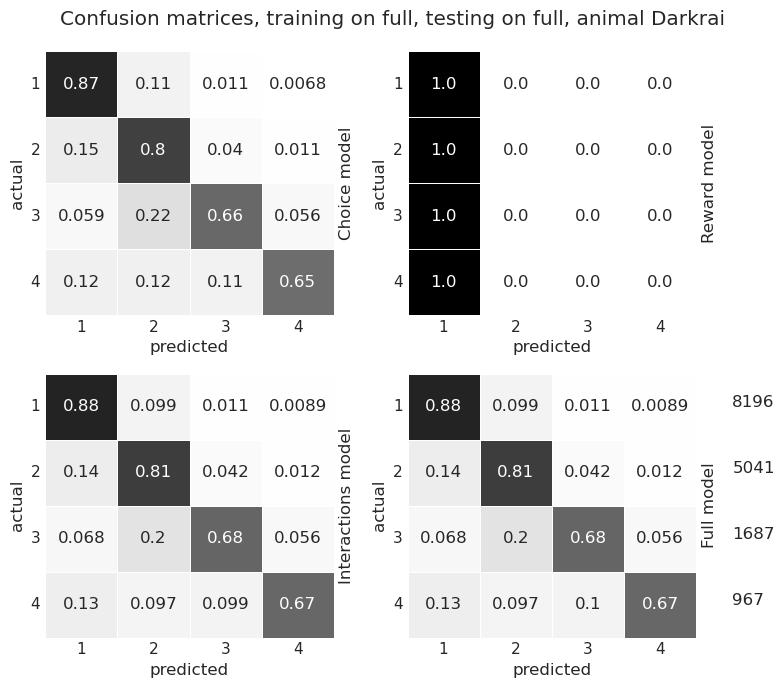

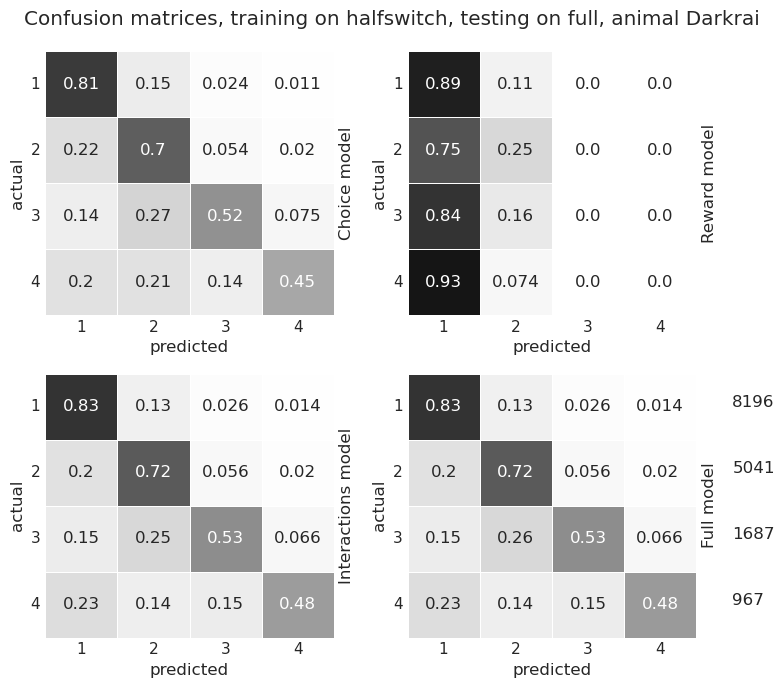

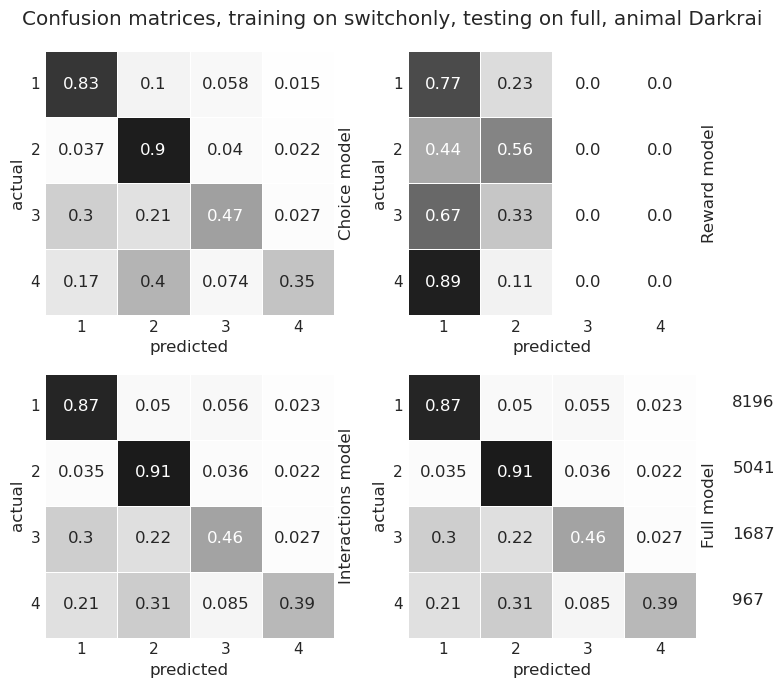

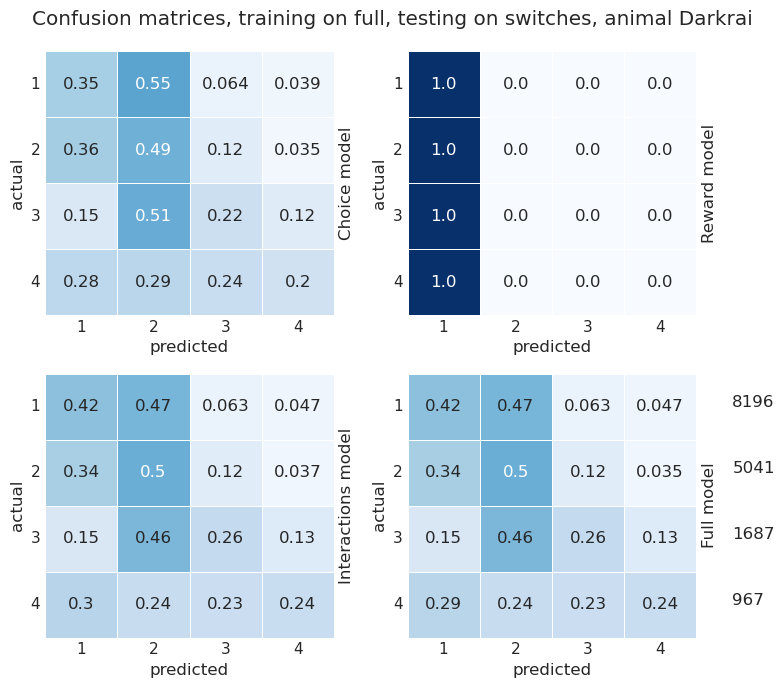

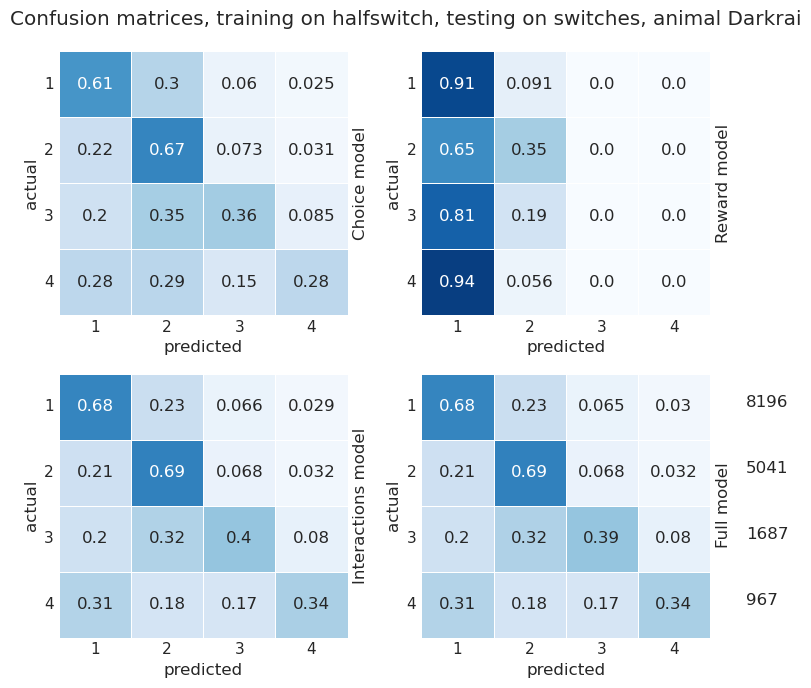

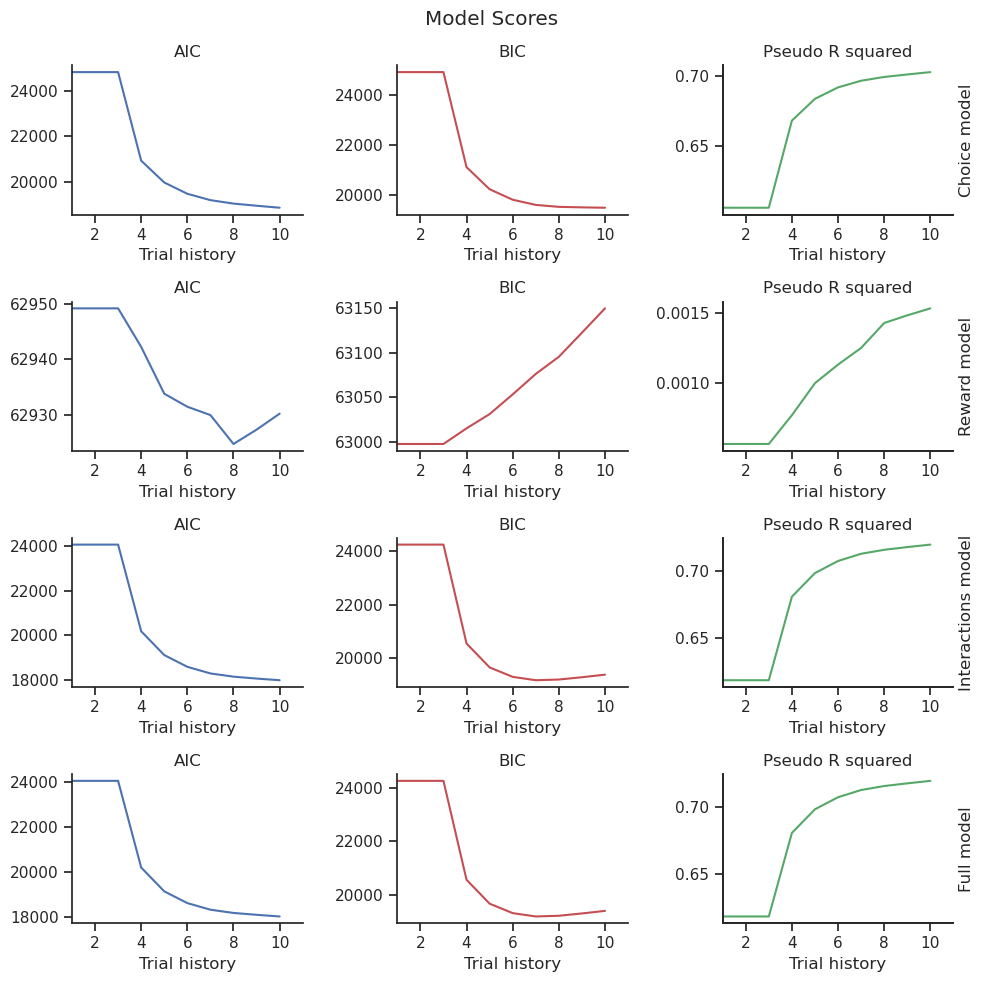

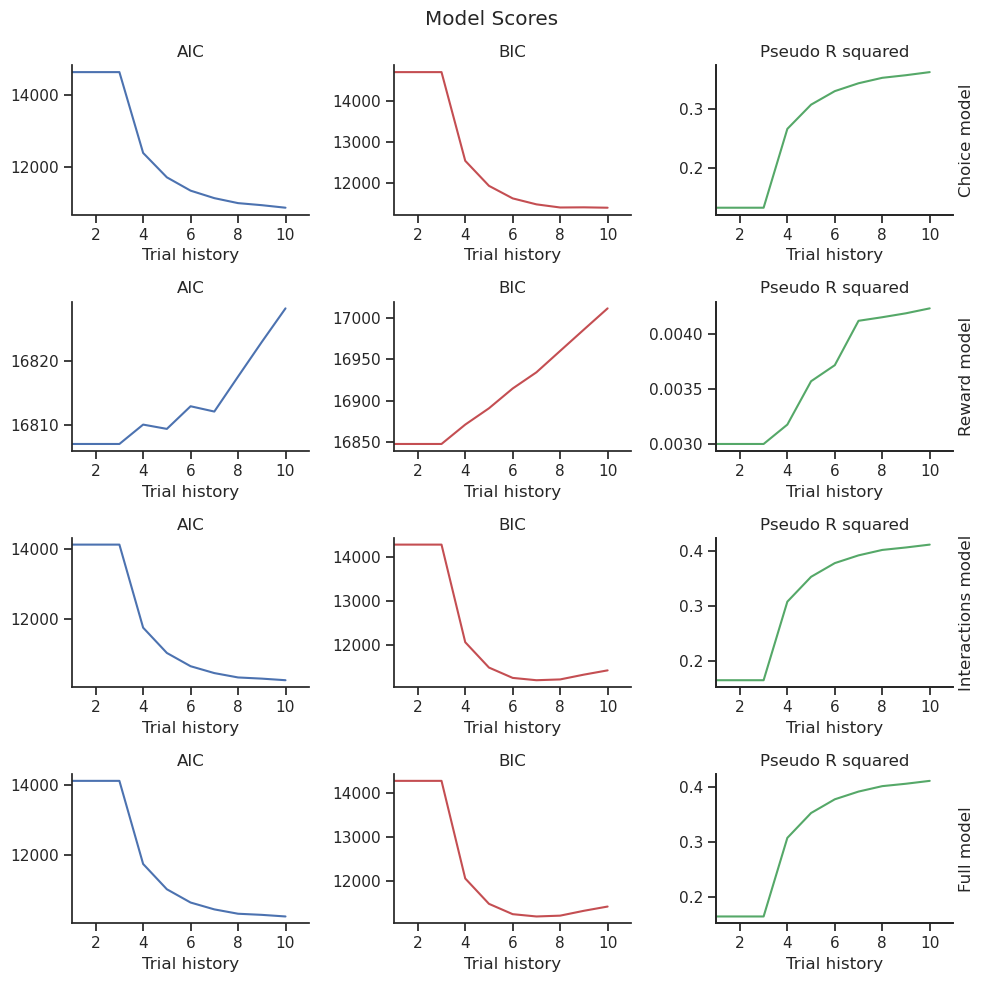

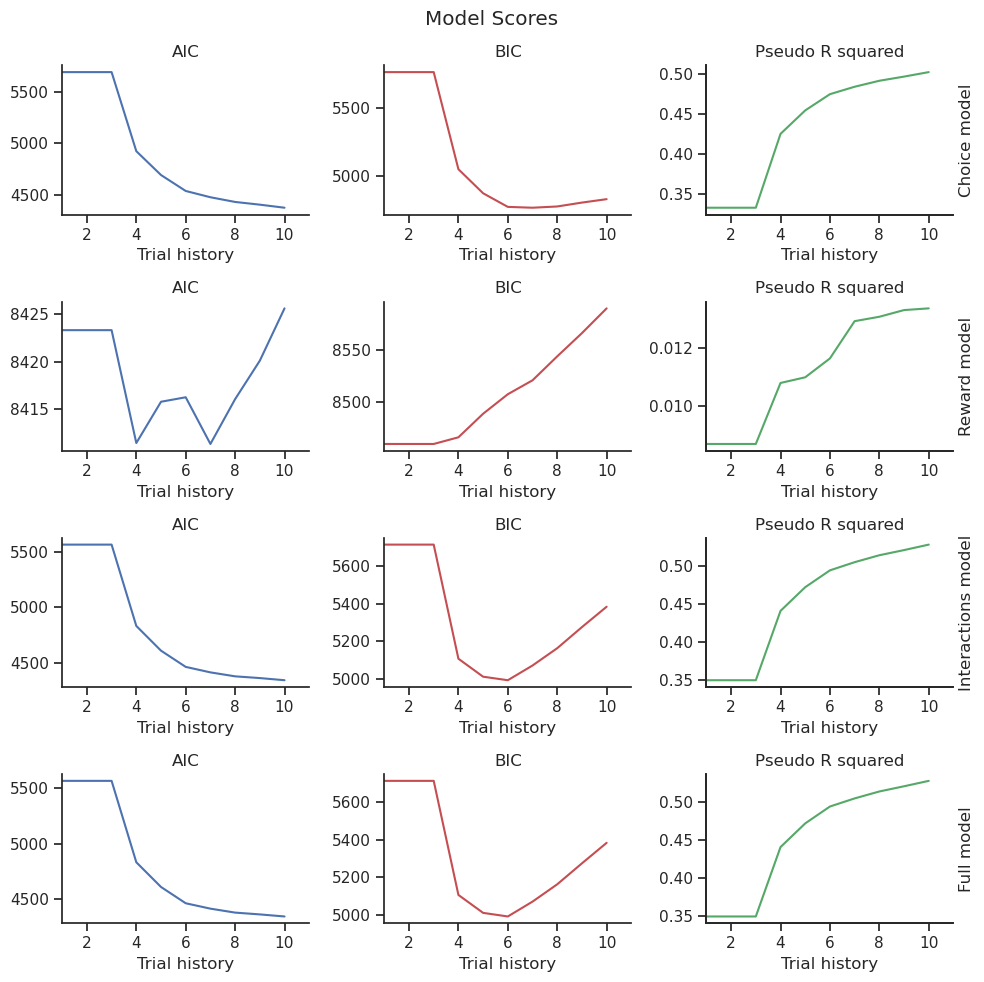

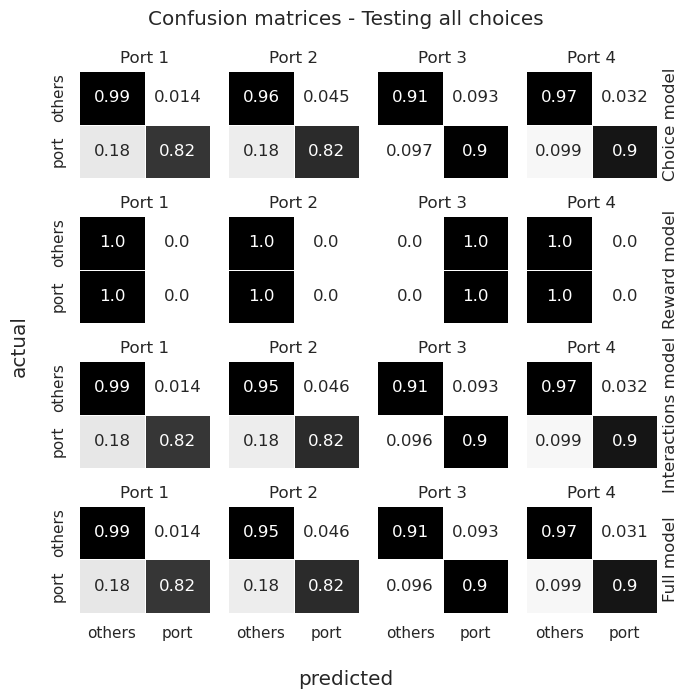

<Figure size 800x700 with 0 Axes>

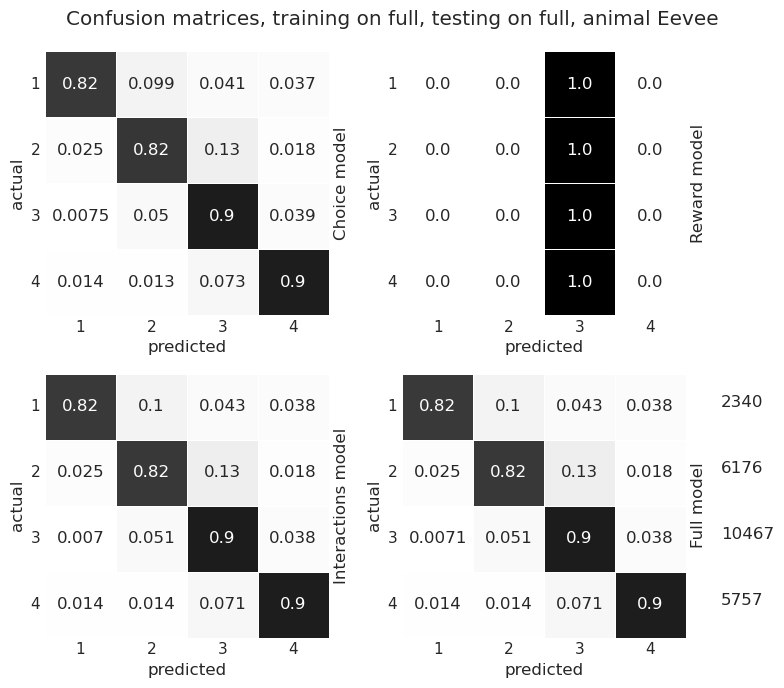

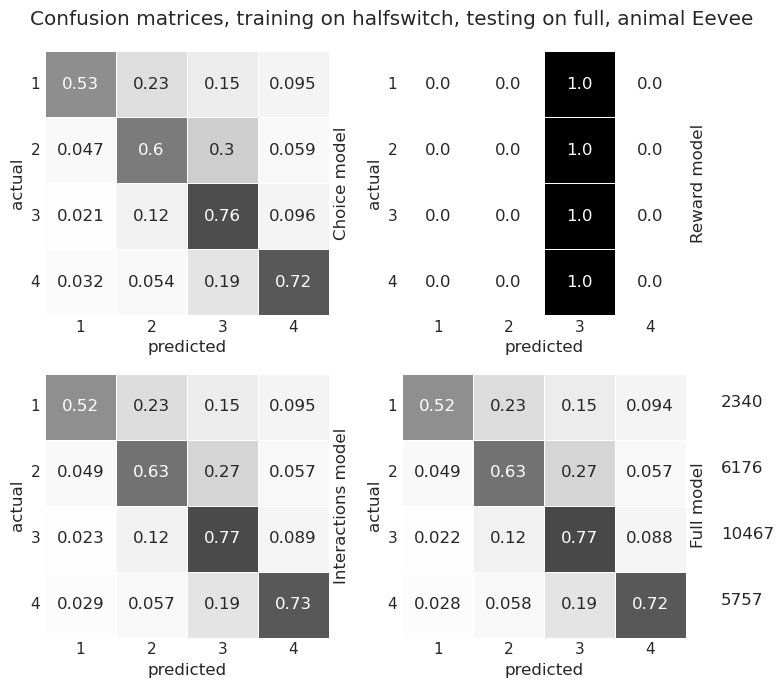

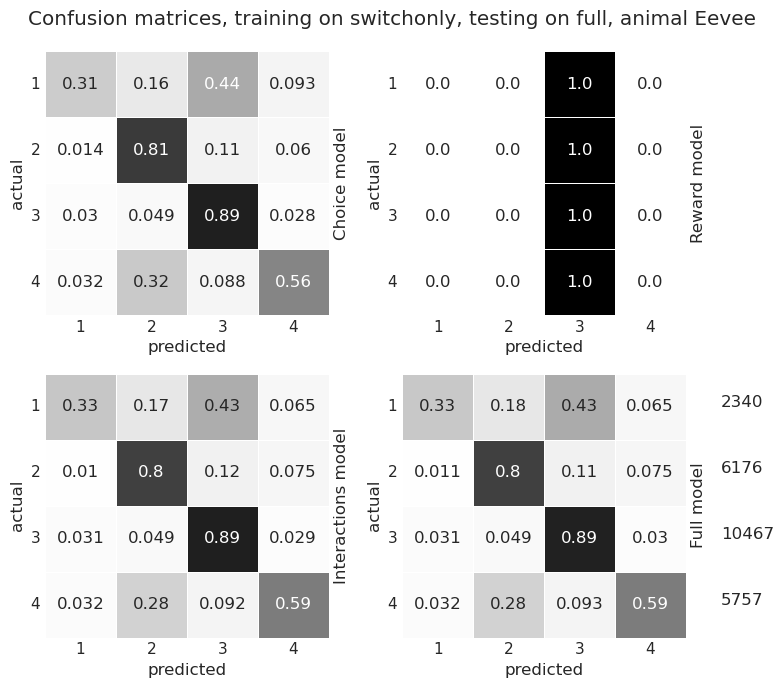

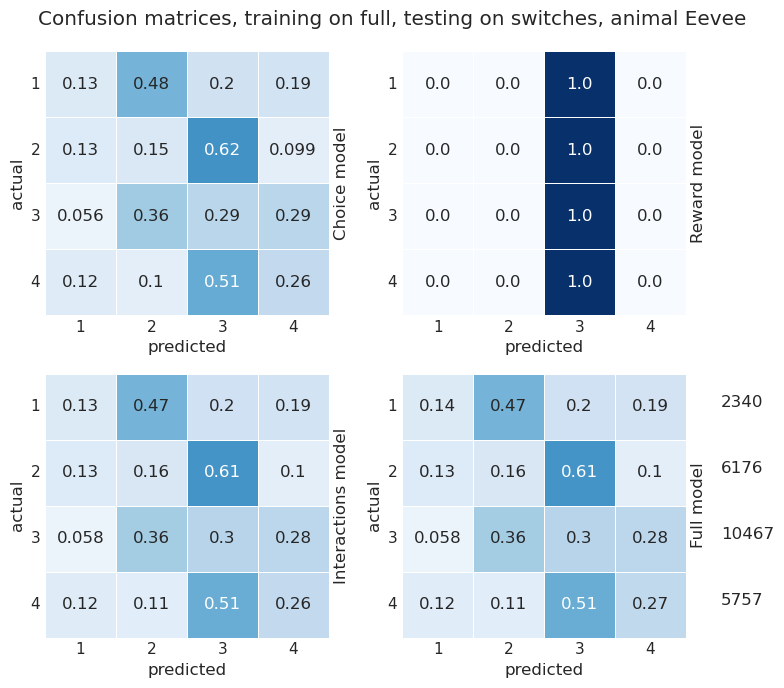

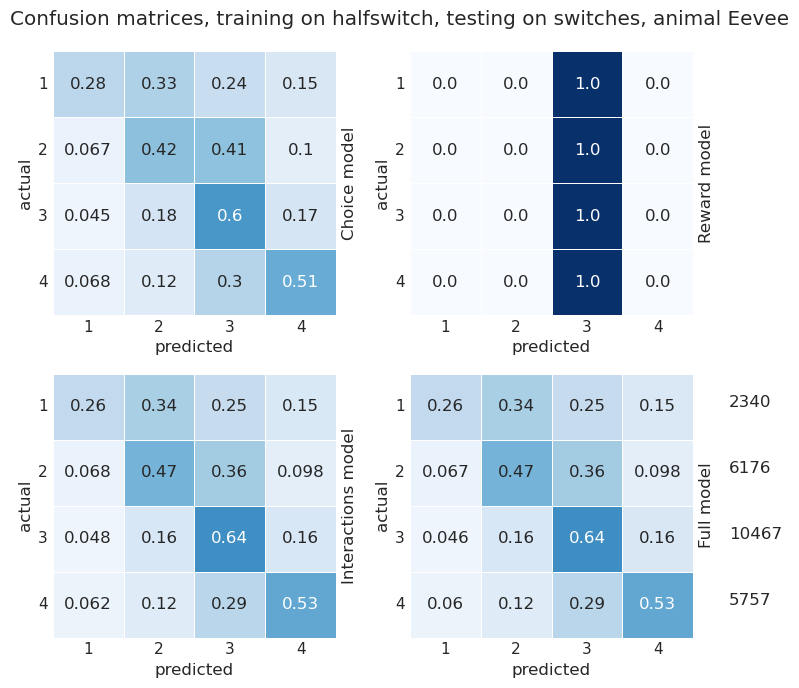

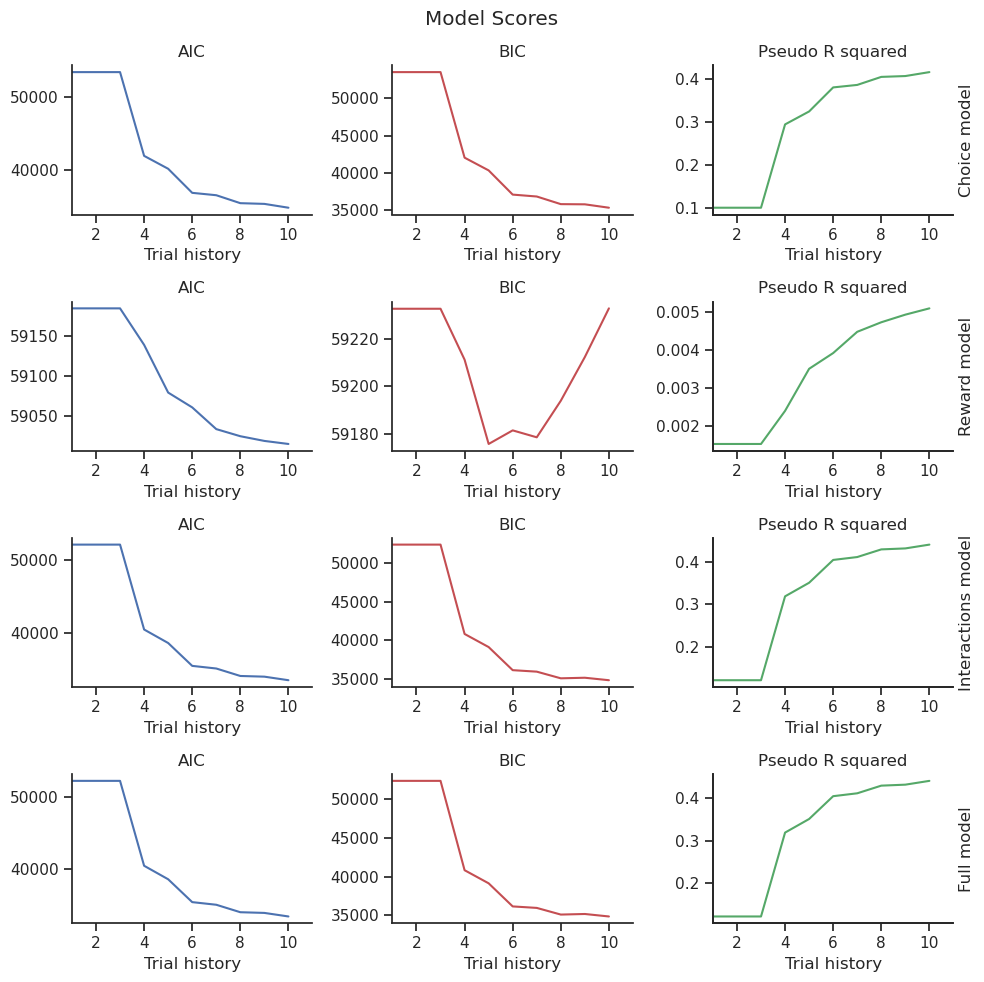

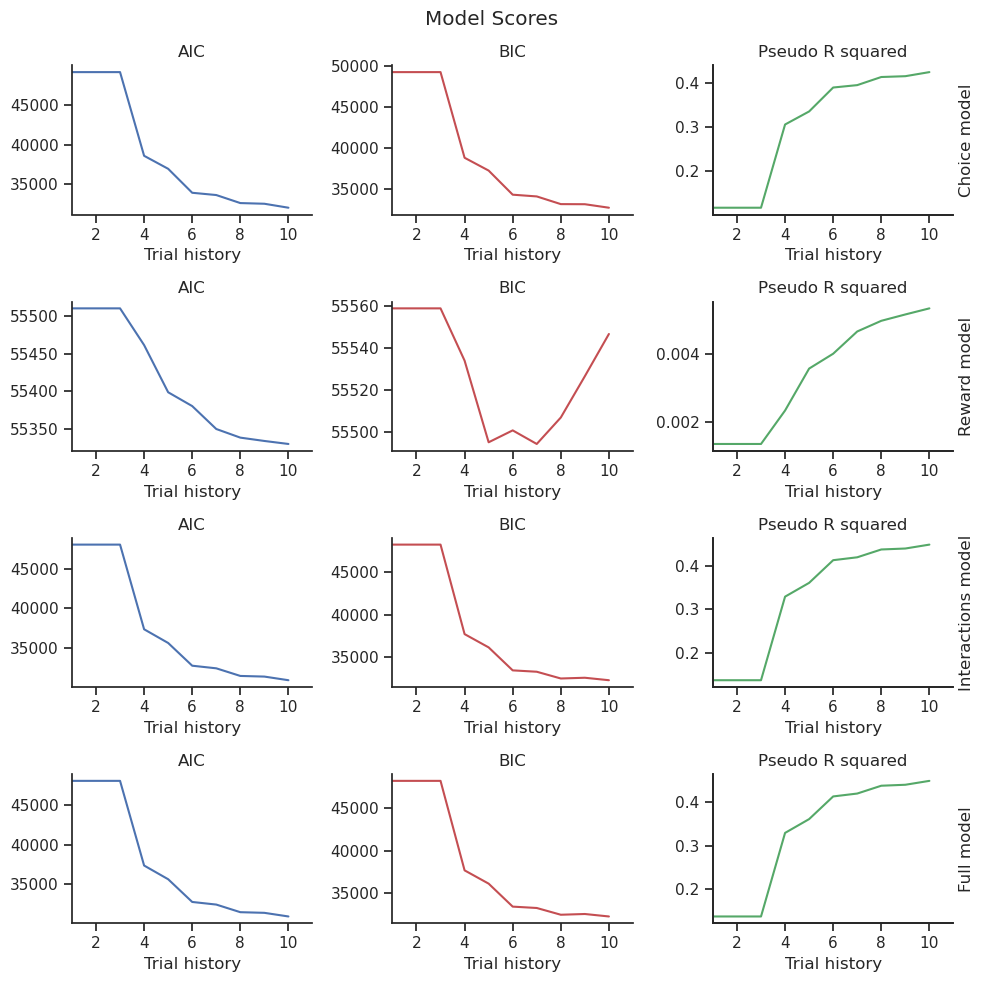

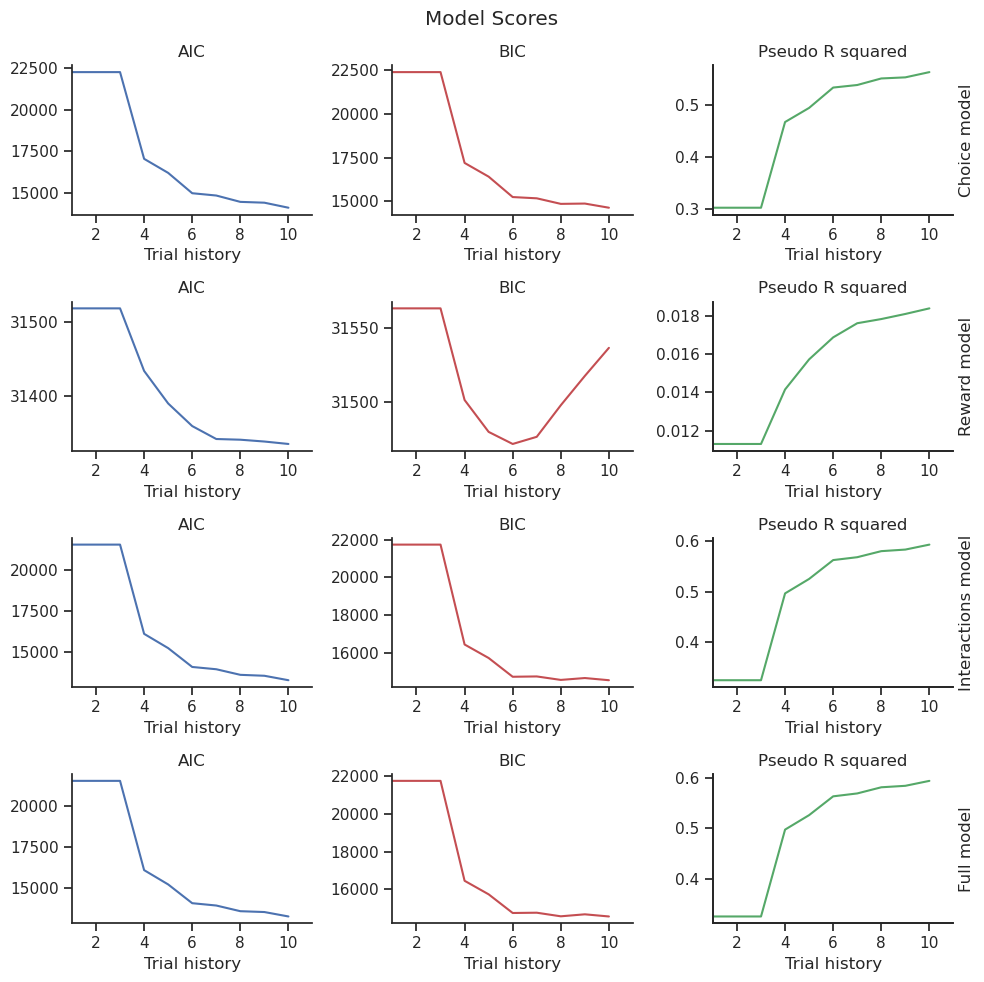

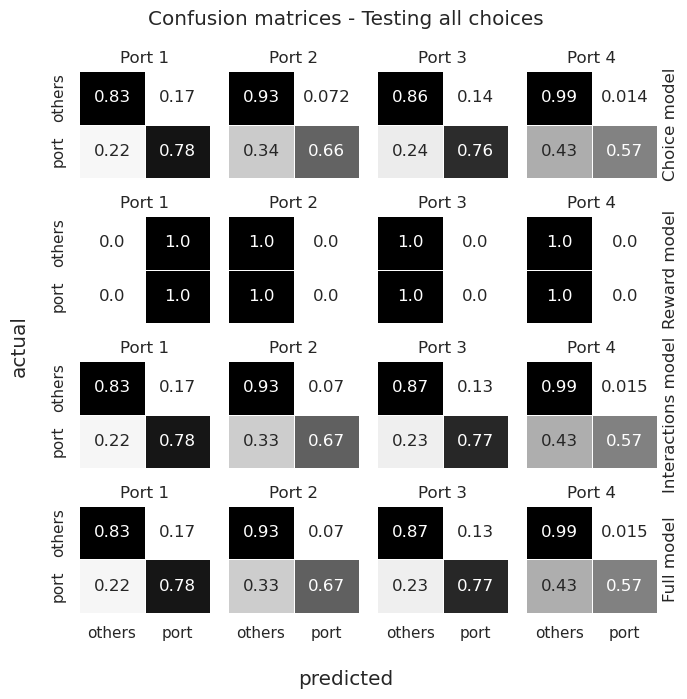

<Figure size 800x700 with 0 Axes>

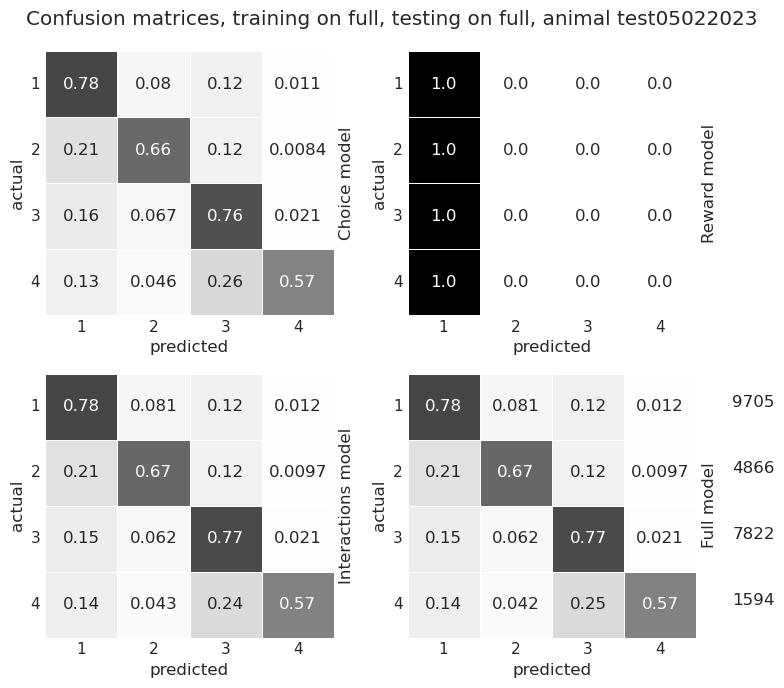

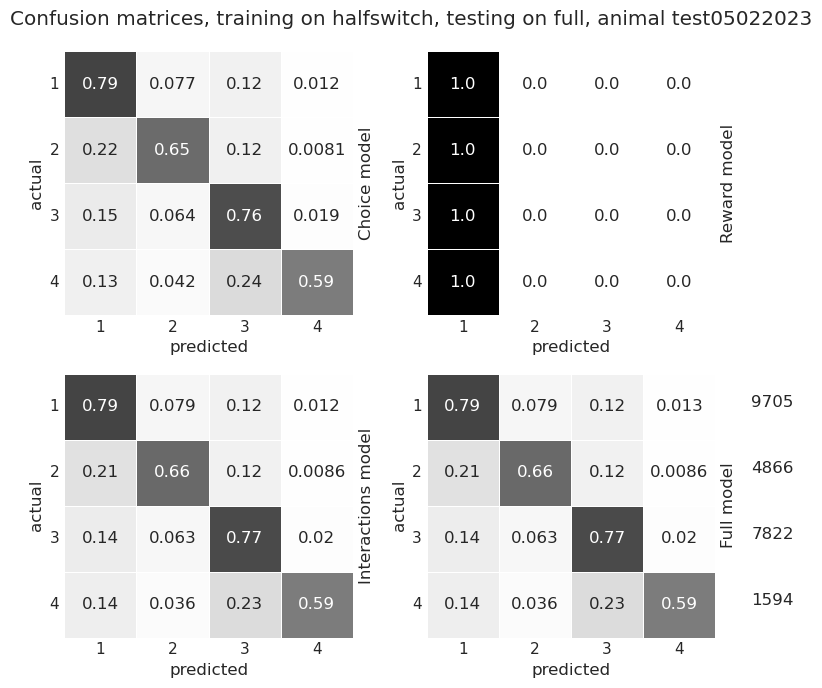

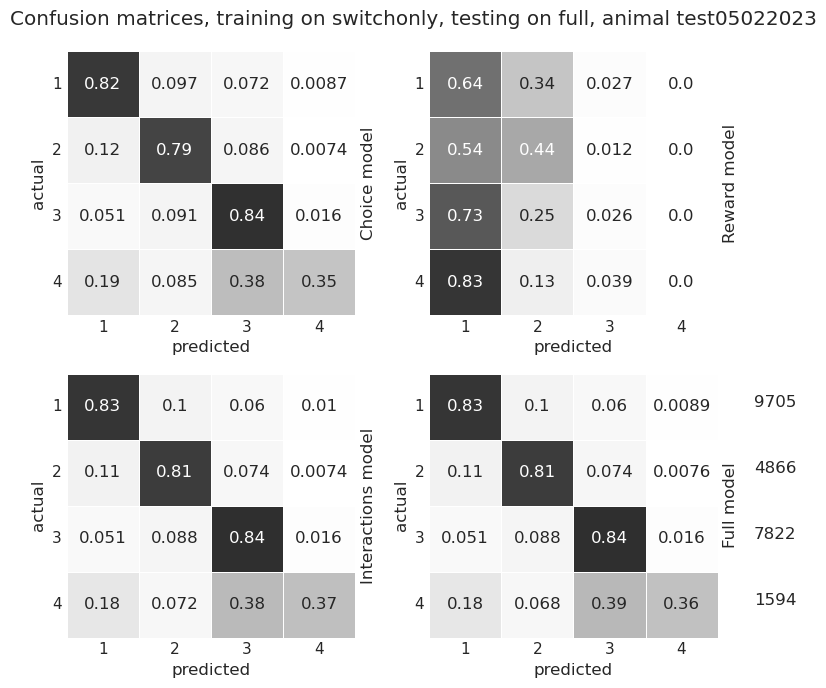

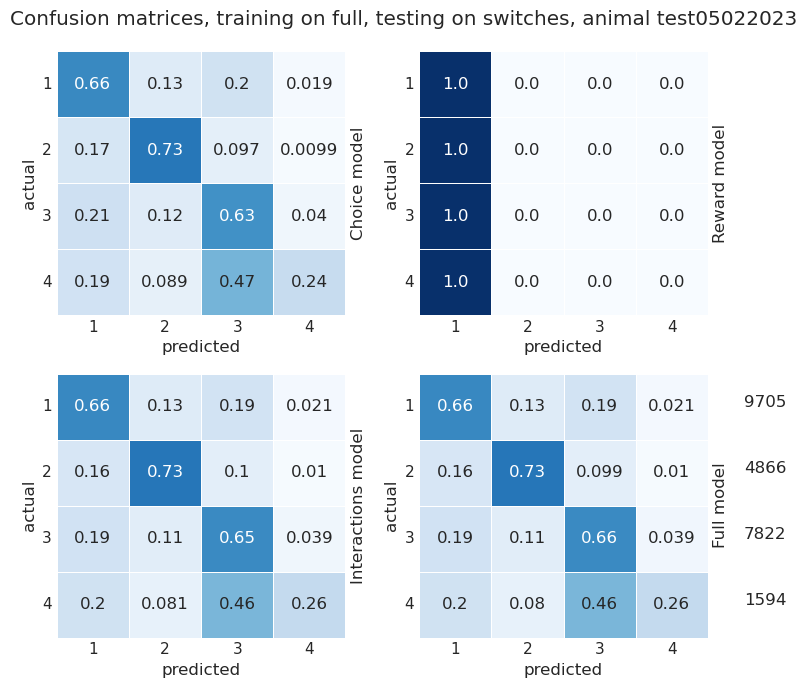

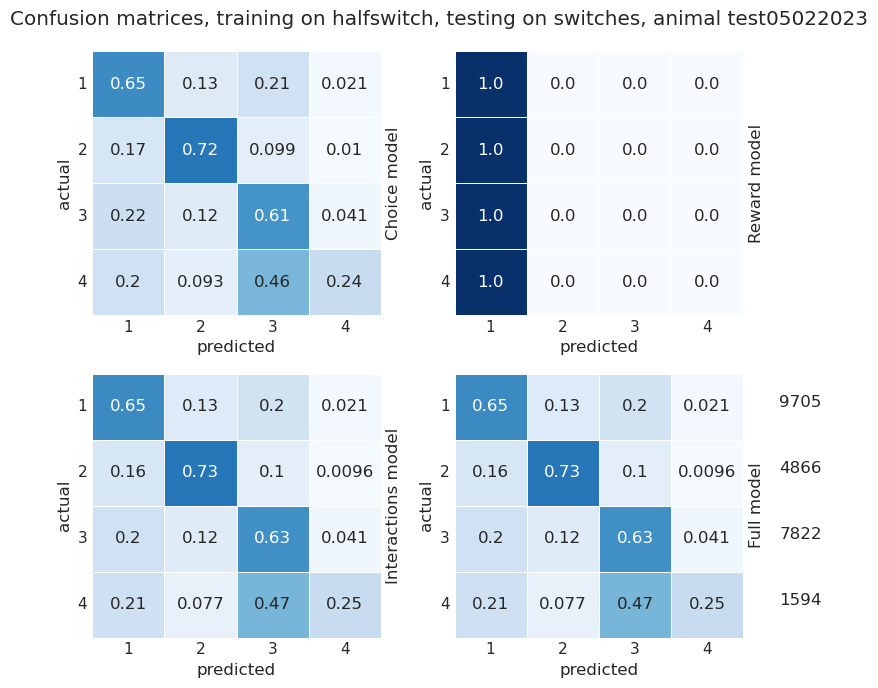

In [17]:
# multiclass log reg - trained and tested on full, halfswitch, switchonly
set_cwd('/home/rishika/sim')
hist = 10
mnlogitdf = pd.DataFrame()
pd.options.mode.chained_assignment = None

for animal, dataset in full_df.groupby('animal'):
    
    # generate models and scores of each trial history - train on 3 datasets - full, halfswitch and switchonly
#     animal = dataset.animal.unique()[0]
    halfswitch = dataset.groupby('shift_t0').sample(n = dataset.shift_t0.value_counts().min()).sort_values(by = 'trial#')
    switchonly = dataset[dataset.shift_t0==1]
    
    model_name = ['Choice', 'Reward', 'Interactions', 'Full']
    scores_full = np.array([mnlogit_runner(dataset, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_halfswitch = np.array([mnlogit_runner(halfswitch, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_switchonly = np.array([mnlogit_runner(switchonly, hist, i) for i in ['c', 'r', 'int', 'cr']])
    
    # scores plot
    all_scores = (scores_full, scores_halfswitch, scores_switchonly)
    train_dataset = ['full', 'halfswitch', 'switchonly']
    for ind, scores in enumerate(all_scores):
        fig, ax = plt.subplots(scores.shape[0], scores.shape[1], figsize = (10,10))
        
        title = ['AIC', 'BIC', 'Pseudo R squared']
        color = ['b', 'r', 'g']
        # returns score plot 
        for i in range(scores.shape[0]):
            for j in range(scores.shape[1]):
                ax[i, j].plot(np.arange(1, len(scores[i, j])+1), scores[i,j], c = color[j])
                ax[i, j].set_title(title[j])
                ax[i, j].set_xlabel('Trial history')
                ax[i, j].set_xlim(1,len(scores[i,j])+1)
        #             best_model = 1+np.where(scores[i,j]==min(scores[i,j]))[0][0]
        #         ax[i, j].axvline(best_model, color='r')
            ax2 = ax[i,j].twinx()
            ax2.set_ylabel(f'{model_name[i]} model')
            ax2.set_yticks([])

        sns.despine()
        plt.suptitle('Model Scores')
        plt.tight_layout()
        plt.savefig(f'plots/10102023_2/train_{train_dataset[ind]}_model_scores_{animal}.png', dpi = 300)
     

    # get the best trial history from bic scores
    best_ln = [score_plot(i) for i in scores_full]
    best_ln_switchonly = [score_plot(i) for i in scores_switchonly]
    best_ln_halfswitch = [score_plot(i) for i in scores_halfswitch]
    
    # store best trial history separately for each model
    best_len_c, best_len_r, best_len_int, best_len_cr = best_ln
    best_len_c_switchonly, best_len_r_switchonly, best_len_int_switchonly, best_len_cr_switchonly = best_ln_switchonly
    best_len_c_halfswitch, best_len_r_halfswitch, best_len_int_halfswitch, best_len_cr_halfswitch = best_ln_halfswitch
    
    # regenerate best model
    best_models = [gen_model(dataset, best_ln[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_switchonly = [gen_model(switchonly, best_ln_switchonly[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_halfswitch = [gen_model(halfswitch, best_ln_halfswitch[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    
    # unpack best models by category
    best_model_c, best_model_r, best_model_int, best_model_cr = best_models
    best_model_c_halfswitch, best_model_r_halfswitch, best_model_int_halfswitch, best_model_cr_halfswitch = best_models_halfswitch
    best_model_c_switchonly, best_model_r_switchonly, best_model_int_switchonly, best_model_cr_switchonly = best_models_switchonly

    # evaluate model on full dataset - model_eval(model, testing dataset)
    # training full, prediction full and plot full and switchonly
    cm_c, accuracy_c, full_cm_c, shift_cm_c = model_eval(best_model_c[0], dataset, return_shiftcm = True)
    cm_r, accuracy_r, full_cm_r, shift_cm_r = model_eval(best_model_r[0], dataset, return_shiftcm = True)
    cm_int, accuracy_int, full_cm_int, shift_cm_int = model_eval(best_model_int[0], dataset, return_shiftcm=True)
    cm_cr, accuracy_cr, full_cm_cr, shift_cm_cr = model_eval(best_model_cr[0], dataset, return_shiftcm = True)
    baccuracy_c = np.diag(full_cm_c).mean()
    baccuracy_r = np.diag(full_cm_r).mean()
    baccuracy_int = np.diag(full_cm_int).mean()
    baccuracy_cr = np.diag(full_cm_cr).mean()
    
    # training full, prediction switchonly
    _, accuracy_c_test_switchonly, full_cm_c_test_switchonly = model_eval(best_model_c[0], switchonly)
    _, accuracy_r_test_switchonly, full_cm_r_test_switchonly = model_eval(best_model_r[0], switchonly)
    _, accuracy_int_test_switchonly, full_cm_int_test_switchonly = model_eval(best_model_int[0], switchonly)
    _, accuracy_cr_test_switchonly, full_cm_cr_test_switchonly = model_eval(best_model_cr[0], switchonly)
    baccuracy_c_test_switchonly = np.diag(full_cm_c_test_switchonly).mean()
    baccuracy_r_test_switchonly = np.diag(full_cm_r_test_switchonly).mean()
    baccuracy_int_test_switchonly = np.diag(full_cm_int_test_switchonly).mean()
    baccuracy_cr_test_switchonly = np.diag(full_cm_cr_test_switchonly).mean()
    
    # training halfswitch, prediction full and plot full and switchonly
    _, accuracy_c_halfswitch, full_cm_c_halfswitch, shift_cm_c_halfswitch = model_eval(best_model_c_halfswitch[0], halfswitch, return_shiftcm = True)
    _, accuracy_r_halfswitch, full_cm_r_halfswitch, shift_cm_r_halfswitch = model_eval(best_model_r_halfswitch[0], halfswitch, return_shiftcm = True)
    _, accuracy_int_halfswitch, full_cm_int_halfswitch, shift_cm_int_halfswitch = model_eval(best_model_int_halfswitch[0], halfswitch, return_shiftcm=True)
    _, accuracy_cr_halfswitch, full_cm_cr_halfswitch, shift_cm_cr_halfswitch = model_eval(best_model_cr_halfswitch[0], halfswitch, return_shiftcm = True)
    baccuracy_c_halfswitch = np.diag(full_cm_c_halfswitch).mean()
    baccuracy_r_halfswitch = np.diag(full_cm_r_halfswitch).mean()
    baccuracy_int_halfswitch = np.diag(full_cm_int_halfswitch).mean()
    baccuracy_cr_halfswitch = np.diag(full_cm_cr_halfswitch).mean()
    
    # training halfswitch, prediction switchonly
    _, accuracy_c_halfswitch_test_switchonly, full_cm_c_halfswitch_test_switchonly = model_eval(best_model_c_halfswitch[0], switchonly)
    _, accuracy_r_halfswitch_test_switchonly, full_cm_r_halfswitch_test_switchonly = model_eval(best_model_r_halfswitch[0], switchonly)
    _, accuracy_int_halfswitch_test_switchonly, full_cm_int_halfswitch_test_switchonly = model_eval(best_model_int_halfswitch[0], switchonly)
    _, accuracy_cr_halfswitch_test_switchonly, full_cm_cr_halfswitch_test_switchonly = model_eval(best_model_cr_halfswitch[0], switchonly)
    baccuracy_c_halfswitch_test_switchonly = np.diag(full_cm_c_halfswitch_test_switchonly).mean()
    baccuracy_r_halfswitch_test_switchonly = np.diag(full_cm_r_halfswitch_test_switchonly).mean()
    baccuracy_int_halfswitch_test_switchonly = np.diag(full_cm_int_halfswitch_test_switchonly).mean()
    baccuracy_cr_halfswitch_test_switchonly = np.diag(full_cm_cr_halfswitch_test_switchonly).mean()
    
    # training switchonly, prediction full
    _, accuracy_c_switchonly, full_cm_c_switchonly = model_eval(best_model_c_switchonly[0], switchonly)
    _, accuracy_r_switchonly, full_cm_r_switchonly = model_eval(best_model_r_switchonly[0], switchonly)
    _, accuracy_int_switchonly, full_cm_int_switchonly = model_eval(best_model_int_switchonly[0], switchonly)
    _, accuracy_cr_switchonly, full_cm_cr_switchonly = model_eval(best_model_cr_switchonly[0], switchonly)
    baccuracy_c_switchonly = np.diag(full_cm_c_switchonly).mean()
    baccuracy_r_switchonly = np.diag(full_cm_r_switchonly).mean()
    baccuracy_int_switchonly = np.diag(full_cm_int_switchonly).mean()
    baccuracy_cr_switchonly = np.diag(full_cm_cr_switchonly).mean()
    
    # training switchonly, prediction switchonly
    _, accuracy_c_switchonly_test_switchonly, full_cm_c_switchonly_test_switchonly = model_eval(best_model_c_switchonly[0], switchonly)
    _, accuracy_r_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly = model_eval(best_model_r_switchonly[0], switchonly)
    _, accuracy_int_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly = model_eval(best_model_int_switchonly[0], switchonly)
    _, accuracy_cr_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly = model_eval(best_model_cr_switchonly[0], switchonly)
    baccuracy_c_switchonly_test_switchonly = np.diag(full_cm_c_switchonly_test_switchonly).mean()
    baccuracy_r_switchonly_test_switchonly = np.diag(full_cm_r_switchonly_test_switchonly).mean()
    baccuracy_int_switchonly_test_switchonly = np.diag(full_cm_int_switchonly_test_switchonly).mean()
    baccuracy_cr_switchonly_test_switchonly = np.diag(full_cm_cr_switchonly_test_switchonly).mean()
    
     # draw confusion matrices for testing on full dataset
    cms = np.array([cm_c, cm_r, cm_int, cm_cr])
    title = '- Testing all choices'
    fig, ax = plt.subplots(nrows = cms.shape[0], ncols = cms.shape[1], sharex = True, sharey = True, figsize = (7,7))
    row = 0

    for cm in cms:
        for i in range(len(cm)):
            sns.heatmap(row_norm(cm[i,:,:]), annot = True, cmap = 'Greys', fmt = '.2',
                        xticklabels = ['others', f'port'], linewidth = .5,
                        yticklabels = ['others', f'port'], cbar = False, ax = ax[row,i])
            ax[row,i].set_title(f'Port {i+1}')
            ax[row,i].tick_params(left=False, bottom=False, right = False)

        ax2 = ax[row,i].twinx()
        ax2.set_ylabel(f'{model_name[row]} model')
        ax2.set_yticks([])
        ax[row,i].tick_params(left = False)
        row+=1
    fig.supxlabel('predicted')
    fig.supylabel('actual')
    plt.suptitle(f'Confusion matrices {title}')
    sns.despine(fig = fig, bottom = True, left = True)
    plt.tight_layout()
    plt.savefig(f'plots/10102023_2/portwise_cm_{animal}_train_full_test_full.png', dpi = 300)
    
    # plot cm for testing on full dataset
    full_cm = [[full_cm_c, full_cm_r, full_cm_int, full_cm_cr],
              [full_cm_c_halfswitch, full_cm_r_halfswitch, full_cm_int_halfswitch, full_cm_cr_halfswitch],
              [full_cm_c_switchonly, full_cm_r_switchonly, full_cm_int_switchonly, full_cm_cr_switchonly]]
    train = ['full', 'halfswitch', 'switchonly']
    fig = plt.figure(figsize=(8,7))
    plotnum = 1
    for ind, train_data in enumerate(full_cm):
        fig = plt.figure(figsize=(8,7))
        plotnum = 1
        for cm in train_data:
            ax = plt.subplot(2,2,plotnum)
            sns.heatmap(cm, annot = True, cmap = 'Greys', fmt = '.2',
                        linewidth = .7,
                        cbar = False, vmin = 0, vmax = 1)
            ax.set_ylabel('actual')
            ax.set_xlabel('predicted')
            ax.tick_params(axis='both', which='both', length=0)
            plt.yticks(rotation = 0)

            ax2 = ax.twinx()
            ax2.set_ylabel(f'{model_name[plotnum-1]} model')
            ax2.set_yticks([])
            plotnum+=1
            sns.despine(left = True, bottom = True)

        plt.suptitle(f'Confusion matrices, training on {train[ind]}, testing on full, animal {animal}')

        counts = list(dataset.groupby('choice_t0').choice_t0.count())
        for i in range(len(counts)):
            ax.text(4.5, ax.get_yticks()[i], counts[i])
        plt.tight_layout()
        plt.savefig(f'plots/10102023_2/fullcm_train_{train[ind]}_test_full_{animal}.png', dpi= 300)
    
    # plot cm for testing on switchonly
    full_cm_test_switchonly = [[full_cm_c_test_switchonly, full_cm_r_test_switchonly, full_cm_int_test_switchonly, full_cm_cr_test_switchonly],
              [full_cm_c_halfswitch_test_switchonly, full_cm_r_halfswitch_test_switchonly, full_cm_int_halfswitch_test_switchonly, full_cm_cr_halfswitch_test_switchonly],
              [full_cm_c_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly]]
    train = ['full', 'halfswitch', 'switchonly']
    
    
    for ind, train_data in enumerate(full_cm_test_switchonly):
        fig = plt.figure(figsize=(8,7))
        plotnum = 1
        for cm in train_data:
            ax = plt.subplot(2,2,plotnum)
            sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.2',
                        linewidth = .7,
                        cbar = False, vmin = 0, vmax = 1)
            ax.set_ylabel('actual')
            ax.set_xlabel('predicted')
            ax.tick_params(axis='both', which='both', length=0)
            plt.yticks(rotation = 0)

            ax2 = ax.twinx()
            ax2.set_ylabel(f'{model_name[plotnum-1]} model')
            ax2.set_yticks([])
            plotnum+=1
            sns.despine(left = True, bottom = True)

        plt.suptitle(f'Confusion matrices, training on {train[ind]}, testing on switches, animal {animal}')

        counts = list(dataset.groupby('choice_t0').choice_t0.count())
        for i in range(len(counts)):
            ax.text(4.5, ax.get_yticks()[i], counts[i])
        plt.tight_layout()
        plt.savefig(f'plots/10102023_2/fullcm_train_{train[ind]}_test_switches_{animal}.png', dpi= 300)

    # store data in a df
    ddict = [
        {'model':'choice', 'animal':animal,'train_on':'full', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull, 'bal_accuracy':baccuracy_c},
    {'model':'reward', 'animal':animal,'train_on':'full', 'best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r,'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r},
    {'model':'interactions', 'animal':animal, 'train_on':'full','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull, 'bal_accuracy':baccuracy_int},
    {'model':'full', 'animal':animal, 'train_on':'full','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr},
    {'model':'choice', 'animal':animal, 'train_on':'full','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_test_switchonly, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull,'bal_accuracy':baccuracy_c_test_switchonly},
    {'model':'reward', 'animal':animal,'train_on':'full', 'best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_test_switchonly, 'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r_test_switchonly},
    {'model':'interactions', 'animal':animal,'train_on':'full', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_test_switchonly, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull,'bal_accuracy':baccuracy_int_test_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'full', 'best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_test_switchonly, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr_test_switchonly},
    {'model':'choice', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_halfswitch, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch},
    {'model':'reward', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_halfswitch, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull,'bal_accuracy':baccuracy_r_halfswitch},
    {'model':'interactions', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_halfswitch, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch},
    {'model':'full', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_halfswitch, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull, 'bal_accuracy':baccuracy_cr_halfswitch},
    {'model':'choice', 'animal':animal,'train_on':'halfswitch', 'best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_halfswitch_test_switchonly, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch_test_switchonly},
    {'model':'reward', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_halfswitch_test_switchonly, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull, 'bal_accuracy':baccuracy_r_halfswitch_test_switchonly},
    {'model':'interactions', 'animal':animal,'train_on':'halfswitch', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_halfswitch_test_switchonly, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch_test_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_halfswitch_test_switchonly, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull,'bal_accuracy':baccuracy_cr_halfswitch_test_switchonly},
    {'model':'choice', 'animal':animal, 'train_on':'switchonly', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly},
    {'model':'reward', 'animal':animal, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly},
    {'model':'interactions', 'animal':animal, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly},
    {'model':'choice', 'animal':animal, 'train_on':'switchonly','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_switchonly_test_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly_test_switchonly},
    {'model':'reward', 'animal':animal, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_switchonly_test_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly_test_switchonly},
    {'model':'interactions', 'animal':animal, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_switchonly_test_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly_test_switchonly},
    {'model':'full', 'animal':animal, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_switchonly_test_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly_test_switchonly}]

    mnlogitdf = pd.concat([mnlogitdf,pd.DataFrame(ddict)], ignore_index = True)
    plt.close()
pd.options.mode.chained_assignment = 'warn'

In [18]:
############################################# compute q value across datasets and get aic bic prsq
# info
arms = 4

# data saving
qldf = pd.DataFrame()

# go through the dataset dict
hist = 10
for task, dataset in full_df.groupby('animal'):
    
    # animal name
    animal = dataset.animal.unique()[0]

    # see bias - 
    bias1, bias2, bias3, bias4 = [i for i in dataset.port.value_counts(normalize = True).reindex([1,2,3,4])]

    # how to supply params for each model?
    params_v = (0.07, 0.2)      #alpha, tau
    params = (0.07, 0.2, bias1, bias2, bias3, bias4)    #alpha, tau, bias1, 2, 3, 4
    pd.options.mode.chained_assignment = None

    # q learning - use params to generate ll (?)
    dataset, v_ll, b_ll = gen_qvalues(dataset, params)
    vanilla = dataset.drop('all_p_qvalue_b', axis = 1)
    biased = dataset.drop('all_p_qvalue_v', axis = 1)
    v_aic = 2*len(params_v) - (2*v_ll)
    v_bic = len(params_v)*np.log(dataset.shape[0]) - (2*v_ll)

    # biased q learning
    b_aic = 2*len(params)-2*b_ll
    b_bic = len(params)*np.log(dataset.shape[0]) - (2*b_ll)
    pd.options.mode.chained_assignment = 'warn'

    # use q values to generate predictions (using max p value!!!) 
    # this could also be generated randomly from the probability values
    vanilla['max_p_predicted'] = vanilla.apply(lambda x: max(np.array(x.all_p_qvalue_v)), axis =1)
    vanilla['predicted'] = vanilla.apply(lambda x: np.argmax(np.array(x.all_p_qvalue_v))+1, axis =1)
    vanilla['predicted'] = pd.Categorical(vanilla.predicted, categories = [1,2,3,4])

    biased['max_p_predicted'] = biased.apply(lambda x: max(np.array(x.all_p_qvalue_b)), axis =1)
    biased['predicted'] = biased.apply(lambda x: np.argmax(np.array(x.all_p_qvalue_b))+1, axis =1)
    biased['predicted'] = pd.Categorical(biased.predicted, categories = [1,2,3,4])

    # compute llnull, pr squared
    # for now just get it from mnlogit df
    llnull = mnlogitdf[(mnlogitdf.train_on=='full') & (mnlogitdf.animal==animal)]['llnull'].iloc[0]
    v_prsq = 1 - (v_ll/llnull)
    b_prsq = 1 - (b_ll/llnull)

    # accuracy, confusion matrices
    vanilla['accuracy'] = vanilla['predicted']==vanilla['choice_t0']
    v_accuracy = vanilla['accuracy'].mean()
    full_cm_v = pd.crosstab(vanilla.choice_t0, vanilla.predicted, normalize = 'index', dropna = False)
    full_cm_shift_v = pd.crosstab(vanilla[vanilla.shift_t0==1].choice_t0,
                                  vanilla[vanilla.shift_t0==1].predicted,
                                  normalize = 'index', dropna = False)
    vanilla['predicted_t1'] = pd.Categorical(vanilla.predicted, categories = np.arange(1, 1+arms)).shift(1)
    vanilla['pred_shift_t0'] = (vanilla['predicted']==vanilla['predicted_t1']).replace({True: 0, False: 1})
    shift_cm_v = pd.crosstab(vanilla.shift_t0,
                          vanilla.pred_shift_t0,
                          normalize = 'index',
                          dropna = False)


    biased['accuracy'] = biased['predicted']==biased['choice_t0']
    b_accuracy = biased['accuracy'].mean()
    full_cm_b = pd.crosstab(biased.choice_t0, biased.predicted, normalize = 'index', dropna = False)
    full_cm_shift_b = pd.crosstab(biased[biased.shift_t0==1].choice_t0,
                                  biased[biased.shift_t0==1].predicted,
                                  normalize = 'index', dropna = False)
    biased['predicted_t1'] = pd.Categorical(biased.predicted, categories = np.arange(1, 1+arms)).shift(1)
    biased['pred_shift_t0'] = (biased['predicted']==biased['predicted_t1']).replace({True: 0, False: 1})
    shift_cm_b = pd.crosstab(biased.shift_t0,
                          biased.pred_shift_t0,
                          normalize = 'index',
                          dropna = False)

    # full cm accuracy plot
    model_name = ['vanilla', 'biased']
    full_cm = (full_cm_v, full_cm_b)
    fig = plt.figure(figsize=(7,4))
    plotnum = 1
    for cm in full_cm:
        ax = plt.subplot(1,2,plotnum)
        sns.heatmap(cm, annot = True, cmap = 'Greys', fmt = '.2',
                    linewidth = .7,
                    cbar = False, vmin = 0, vmax = 1)
        ax.set_ylabel('actual')
        ax.set_xlabel('predicted')
        ax.tick_params(axis='both', which='both', length=0)
        plt.yticks(rotation = 0)

        ax2 = ax.twinx()
        ax2.set_ylabel(f'{model_name[plotnum-1]} model')
        ax2.set_yticks([])
        plotnum+=1
        sns.despine(left = True, bottom = True)

    plt.suptitle('Confusion matrices for models')
    plt.tight_layout()
    plt.savefig(f'plots/10102023_2/{prefix}fullcm_{animal}_qlearn.png', dpi = 300)
    plt.close()

    # shifts in the full dataset conf matrix
    shift_cm = (shift_cm_v, shift_cm_b)
    fig = plt.figure(figsize=(7,4))
    plotnum = 1
    for cm in shift_cm:
        ax = plt.subplot(1,2,plotnum)
        sns.heatmap(cm, annot = True, cmap = 'Greys', fmt = '.2',
                    linewidth = .7, xticklabels = ['repeat', 'switch'], yticklabels = ['repeat', 'switch'],
                    cbar = False, vmin = 0, vmax = 1)
        ax.set_ylabel('actual')
        ax.set_xlabel('predicted')
        ax.tick_params(axis='both', which='both', length=0)
        plt.yticks(rotation = 0)

        ax2 = ax.twinx()
        ax2.set_ylabel(f'{model_name[plotnum-1]} model')
        ax2.set_yticks([])
        plotnum+=1
        sns.despine(left = True, bottom = True)

    plt.suptitle('Confusion matrices for models, shifts only')
    plt.tight_layout()
    plt.savefig(f'plots/10102023_2/{prefix}shiftcm_{animal}_qlearn.png', dpi = 300)
    plt.close()

    # shiftonly confusion matrix
    # shift dataset full confusion matrix
    full_cm_shift = (full_cm_shift_v, full_cm_shift_b)

    fig = plt.figure(figsize=(7,4))
    plotnum = 1
    for cm in full_cm_shift:
        ax = plt.subplot(1,2,plotnum)
        sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.2',
                    linewidth = .7,
                    cbar = False, vmin = 0, vmax = 1)
        ax.set_ylabel('actual')
        ax.set_xlabel('predicted')
        ax.tick_params(axis='both', which='both', length=0)
        plt.yticks(rotation = 0)

        ax2 = ax.twinx()
        ax2.set_ylabel(f'{model_name[plotnum-1]} model')
        ax2.set_yticks([])
        plotnum+=1
        sns.despine(left = True, bottom = True)

    plt.suptitle('Confusion matrices for models')
    plt.tight_layout()
    plt.savefig(f'plots/10102023_2/{prefix}_fullcm_{animal}_qlearn_shiftonly.png', dpi = 300)
    plt.close()

    # store values
    ddict = [{'model':'vanilla','animal':animal,'best_len':0,'pred_on':'full','pred_accuracy':v_accuracy,'aic':v_aic,'bic':v_bic,'prsq':v_prsq},
            {'model':'biased', 'animal':animal,'best_len':0,'pred_on':'full','pred_accuracy':b_accuracy,'aic':b_aic,'bic':b_bic,'prsq':b_prsq}]
    qldf = pd.concat([qldf,pd.DataFrame(ddict)], ignore_index = True)
    print('iter done', animal)

iter done Blissey
iter done Chikorita
iter done Darkrai
iter done Eevee
iter done test05022023


In [398]:
from sklearn.metrics import balanced_accuracy_score
# model.predict(dataset)
prediction_of = 'choice_t0'
predictions = model.predict(dataset)
predicted=[np.sort(dataset[prediction_of].unique())[np.asarray(predictions).argmax(1)[i]] for i in range(len(predictions))]
p = [predictions.loc[r,:][np.asarray(predictions).argmax(1)[ind]] for ind, r in enumerate(predictions.index)]

dataset['predicted'] = pd.Categorical(predicted, categories = np.arange(1, 1+arms))
dataset['p_predicted'] = p
dataset['predicted_t1'] = pd.Categorical(predicted, categories = np.arange(1, 1+arms)).shift(1)
dataset['pred_shift_t0'] = (dataset['predicted']==dataset['predicted_t1']).replace({True: 0, False: 1})
accuracy = accuracy_score(dataset[prediction_of], dataset.predicted)
b_accuracy = balanced_accuracy_score(dataset[prediction_of], dataset.predicted)
full_cm_c = pd.crosstab(dataset.choice_t0, dataset.predicted, normalize = 'index', dropna = False)
print(accuracy, b_accuracy)

In [399]:
np.diag(full_cm_c).mean()

In [417]:
mnlogitdf.groupby(['model', 'train_on']).prsq.mean()

In [20]:
mnlogitdf.to_csv('mnlogitdf.csv')

In [21]:
qldf.to_csv('qldf.csv')

In [419]:
mnlogitdf.groupby(['model', 'train_on','test_on']).pred_accuracy.mean()

In [192]:
################################## simulated q learning
# info
arms = 4

# reward prob generator
def fxn_str(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75/2
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
    return gx

def fxn_unstr(mean, arms):
    x = np.linspace(1, arms, arms)
    sig = 1.75/2
    amp = 0.7
    vo = 0.1
    gx = (amp*np.exp(-0.5*((x-mean)**2)/(sig**2)))+vo
    gx = np.random.permutation(gx)
    return gx

def rewarding(prob, reward_val):
    temp = reward_val
    rand = np.random.uniform(0, 1)
    return temp if rand <= prob else 0

# pairs of params 
alphas = [0.05, 0.1, 0.5, 0.2]
taus = [0.05, 0.1, 0.5, 2]
params = np.array(np.meshgrid(alphas, taus)).T.reshape(-1,2)
hist = 10
sim_qldf_list = []
# sim_qldf = pd.DataFrame(columns = ['animal','task', 'alpha', 'tau', 'sessnum', 'rewprob', 'trial',
#                                    'action', 'reward', 'qvalue'])

for paramset in params:  
    alpha, tau = paramset
    
    for (animal, task), dataset in full_df.groupby(['animal','task']):
        
        if 'unstr' in task:
            
            for sessnum, group in dataset.groupby('session#'):
                q = np.zeros(arms)
                rp = fxn_unstr(np.random.choice(np.arange(1,5)), arms)

                for ind, trial in group.iterrows():
                    # softmax prob of choosing actions
                    invtemp=1/tau
                    P = np.exp(invtemp*(q))
                    P = P/ np.sum(P)

                    # which action on this trial
                    a_ind = np.random.multinomial(1, P)
                    a = range(arms)[a_ind.nonzero()[0][0]]

                    # probability of each action on this trial
                    p = P[a]

                    # rewarded?
                    r = rewarding(rp[a], 1)

                    # compute q value
                    q[a] = q[a] + alpha*(r - q[a])
                    
                    # store everything
                    sim_qldf_list.append([animal, task, alpha, tau, sessnum, rp[a], ind, a + 1, r, q[a]])
                    
        else:
            
            for sessnum, group in dataset.groupby('session#'):
                q = np.zeros(arms)
                p = np.zeros(group.shape[0])
                rp = fxn_str(np.random.choice(np.arange(1,5)), arms)

                for ind, trial in group.iterrows():
                    # softmax prob of choosing actions
                    invtemp=1/tau
                    P = np.exp(invtemp*(q))
                    P = P/ np.sum(P)

                    # which action on this trial
                    a_ind = np.random.multinomial(1, P)
                    a = range(arms)[a_ind.nonzero()[0][0]]

                    # probability of each action on this trial
                    p = P[a]

                    # rewarded?
                    r = rewarding(rp[a], 1)

                    # compute q value
                    q[a] = q[a] + alpha*(r - q[a])
                    
                    # store everything
                    sim_qldf_list.append([animal, task, alpha, tau, sessnum, rp[a], ind, a + 1, r, q[a]])
    
        print('iter done,', paramset, task, animal)
sim_qldf = pd.DataFrame(sim_qldf_list, columns=['animal', 'task', 'alpha',
                                                'tau', 'session#', 'rewprob',
                                                'trial#', 'port', 'reward', 'qvalue'])

iter done, [0.05 0.05] new_unstr Blissey
iter done, [0.05 0.05] old_unstr Blissey
iter done, [0.05 0.05] str Blissey
iter done, [0.05 0.05] new_unstr Chikorita
iter done, [0.05 0.05] old_unstr Chikorita
iter done, [0.05 0.05] str Chikorita
iter done, [0.05 0.05] new_unstr Darkrai
iter done, [0.05 0.05] old_unstr Darkrai
iter done, [0.05 0.05] str Darkrai
iter done, [0.05 0.05] new_unstr Eevee
iter done, [0.05 0.05] old_unstr Eevee
iter done, [0.05 0.05] str Eevee
iter done, [0.05 0.05] new_unstr test05022023
iter done, [0.05 0.05] old_unstr test05022023
iter done, [0.05 0.05] str test05022023
iter done, [0.05 0.1 ] new_unstr Blissey
iter done, [0.05 0.1 ] old_unstr Blissey
iter done, [0.05 0.1 ] str Blissey
iter done, [0.05 0.1 ] new_unstr Chikorita
iter done, [0.05 0.1 ] old_unstr Chikorita
iter done, [0.05 0.1 ] str Chikorita
iter done, [0.05 0.1 ] new_unstr Darkrai
iter done, [0.05 0.1 ] old_unstr Darkrai
iter done, [0.05 0.1 ] str Darkrai
iter done, [0.05 0.1 ] new_unstr Eevee
iter

iter done, [0.2 0.5] old_unstr Blissey
iter done, [0.2 0.5] str Blissey
iter done, [0.2 0.5] new_unstr Chikorita
iter done, [0.2 0.5] old_unstr Chikorita
iter done, [0.2 0.5] str Chikorita
iter done, [0.2 0.5] new_unstr Darkrai
iter done, [0.2 0.5] old_unstr Darkrai
iter done, [0.2 0.5] str Darkrai
iter done, [0.2 0.5] new_unstr Eevee
iter done, [0.2 0.5] old_unstr Eevee
iter done, [0.2 0.5] str Eevee
iter done, [0.2 0.5] new_unstr test05022023
iter done, [0.2 0.5] old_unstr test05022023
iter done, [0.2 0.5] str test05022023
iter done, [0.2 2. ] new_unstr Blissey
iter done, [0.2 2. ] old_unstr Blissey
iter done, [0.2 2. ] str Blissey
iter done, [0.2 2. ] new_unstr Chikorita
iter done, [0.2 2. ] old_unstr Chikorita
iter done, [0.2 2. ] str Chikorita
iter done, [0.2 2. ] new_unstr Darkrai
iter done, [0.2 2. ] old_unstr Darkrai
iter done, [0.2 2. ] str Darkrai
iter done, [0.2 2. ] new_unstr Eevee
iter done, [0.2 2. ] old_unstr Eevee
iter done, [0.2 2. ] str Eevee
iter done, [0.2 2. ] new_

In [194]:
sim_qldf.to_csv('/home/rishika/sim/sim_qldf.csv')

In [24]:
sim_qldf

animal       task  alpha   tau  session#   rewprob  trial#  \
0             Blissey  new_unstr   0.05  0.05       0.0  0.800000   63654   
1             Blissey  new_unstr   0.05  0.05       0.0  0.151359   63655   
2             Blissey  new_unstr   0.05  0.05       0.0  0.800000   63656   
3             Blissey  new_unstr   0.05  0.05       0.0  0.464315   63657   
4             Blissey  new_unstr   0.05  0.05       0.0  0.464315   63658   
...               ...        ...    ...   ...       ...       ...     ...   
1101946  test05022023        str   0.50  0.50     206.0  0.800000    9585   
1101947  test05022023        str   0.50  0.50     206.0  0.464315    9586   
1101948  test05022023        str   0.50  0.50     206.0  0.464315    9587   
1101949  test05022023        str   0.50  0.50     206.0  0.464315    9588   
1101950  test05022023        str   0.50  0.50     206.0  0.151359    9589   

         port  reward    qvalue  
0           2       1  0.050000  
1           1       0  0.000000  
2           2       1  0.097500  
3           3       0  0.000000  
4           3       1  0.050000  
...       ...     ...       ...  
1101946     2       0  0.372980  
1101947     3       0  0.314382  
1101948     1       1  0.500366  
1101949     1       1  0.750183  
1101950     4       0  0.000000  

[1101951 rows x 10 columns]

In [ ]:
# multiclass log reg - on simulated dataset

hist = 10
sim_mnlogitdf = pd.DataFrame()
pd.options.mode.chained_assignment = None

for (animal, alpha, tau), dataset in sim_qldf.groupby(['animal', 'alpha', 'tau']):
    dataset = data_prep(dataset, hist = 10, trialsinsess = 75, head = True)
    
    # generate models and scores of each trial history - train on 3 datasets - full, halfswitch and switchonly
    animal = dataset.animal.unique()[0]
    halfswitch = dataset.groupby('shift_t0').sample(n = dataset.shift_t0.value_counts().min()).sort_values(by = 'trial#')
    switchonly = dataset[dataset.shift_t0==1]
    
    model_name = ['Choice', 'Reward', 'Interactions', 'Full']
    scores_full = np.array([mnlogit_runner(dataset, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_halfswitch = np.array([mnlogit_runner(halfswitch, hist, i) for i in ['c', 'r', 'int', 'cr']])
    scores_switchonly = np.array([mnlogit_runner(switchonly, hist, i) for i in ['c', 'r', 'int', 'cr']])
    
    # scores plot
    all_scores = (scores_full, scores_halfswitch, scores_switchonly)
    train_dataset = ['full', 'halfswitch', 'switchonly']
    for ind, scores in enumerate(all_scores):
        fig, ax = plt.subplots(scores.shape[0], scores.shape[1], figsize = (10,10))
        
        title = ['AIC', 'BIC', 'Pseudo R squared']
        color = ['b', 'r', 'g']
        # returns score plot 
        for i in range(scores.shape[0]):
            for j in range(scores.shape[1]):
                ax[i, j].plot(np.arange(1, len(scores[i, j])+1), scores[i,j], c = color[j])
                ax[i, j].set_title(title[j])
                ax[i, j].set_xlabel('Trial history')
                ax[i, j].set_xlim(1,len(scores[i,j])+1)
        #             best_model = 1+np.where(scores[i,j]==min(scores[i,j]))[0][0]
        #         ax[i, j].axvline(best_model, color='r')
            ax2 = ax[i,j].twinx()
            ax2.set_ylabel(f'{model_name[i]} model')
            ax2.set_yticks([])

        sns.despine()
        plt.suptitle('Model Scores')
        plt.tight_layout()
        plt.savefig(f'plots/10102023_2/sim{alpha}_{tau}_train_{train_dataset[ind]}_model_scores_{animal}.png', dpi = 300)
     

    # get the best trial history from bic scores
    best_ln = [score_plot(i) for i in scores_full]
    best_ln_switchonly = [score_plot(i) for i in scores_switchonly]
    best_ln_halfswitch = [score_plot(i) for i in scores_halfswitch]
    
    # store best trial history separately for each model
    best_len_c, best_len_r, best_len_int, best_len_cr = best_ln
    best_len_c_switchonly, best_len_r_switchonly, best_len_int_switchonly, best_len_cr_switchonly = best_ln_switchonly
    best_len_c_halfswitch, best_len_r_halfswitch, best_len_int_halfswitch, best_len_cr_halfswitch = best_ln_halfswitch
    
    # regenerate best model
    best_models = [gen_model(dataset, best_ln[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_switchonly = [gen_model(switchonly, best_ln_switchonly[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    best_models_halfswitch = [gen_model(halfswitch, best_ln_halfswitch[i], f) for i, f in enumerate(['c', 'r', 'int', 'cr'])]
    
    # unpack best models by category
    best_model_c, best_model_r, best_model_int, best_model_cr = best_models
    best_model_c_halfswitch, best_model_r_halfswitch, best_model_int_halfswitch, best_model_cr_halfswitch = best_models_halfswitch
    best_model_c_switchonly, best_model_r_switchonly, best_model_int_switchonly, best_model_cr_switchonly = best_models_switchonly

    # evaluate model on full dataset - model_eval(model, testing dataset)
    # training full, prediction full and plot full and switchonly
    cm_c, accuracy_c, full_cm_c, shift_cm_c = model_eval(best_model_c[0], dataset, return_shiftcm = True)
    cm_r, accuracy_r, full_cm_r, shift_cm_r = model_eval(best_model_r[0], dataset, return_shiftcm = True)
    cm_int, accuracy_int, full_cm_int, shift_cm_int = model_eval(best_model_int[0], dataset, return_shiftcm=True)
    cm_cr, accuracy_cr, full_cm_cr, shift_cm_cr = model_eval(best_model_cr[0], dataset, return_shiftcm = True)
    baccuracy_c = np.diag(full_cm_c).mean()
    baccuracy_r = np.diag(full_cm_r).mean()
    baccuracy_int = np.diag(full_cm_int).mean()
    baccuracy_cr = np.diag(full_cm_cr).mean()
    
    # training full, prediction switchonly
    _, accuracy_c_test_switchonly, full_cm_c_test_switchonly = model_eval(best_model_c[0], switchonly)
    _, accuracy_r_test_switchonly, full_cm_r_test_switchonly = model_eval(best_model_r[0], switchonly)
    _, accuracy_int_test_switchonly, full_cm_int_test_switchonly = model_eval(best_model_int[0], switchonly)
    _, accuracy_cr_test_switchonly, full_cm_cr_test_switchonly = model_eval(best_model_cr[0], switchonly)
    baccuracy_c_test_switchonly = np.diag(full_cm_c_test_switchonly).mean()
    baccuracy_r_test_switchonly = np.diag(full_cm_r_test_switchonly).mean()
    baccuracy_int_test_switchonly = np.diag(full_cm_int_test_switchonly).mean()
    baccuracy_cr_test_switchonly = np.diag(full_cm_cr_test_switchonly).mean()
    
    # training halfswitch, prediction full and plot full and switchonly
    _, accuracy_c_halfswitch, full_cm_c_halfswitch, shift_cm_c_halfswitch = model_eval(best_model_c_halfswitch[0], halfswitch, return_shiftcm = True)
    _, accuracy_r_halfswitch, full_cm_r_halfswitch, shift_cm_r_halfswitch = model_eval(best_model_r_halfswitch[0], halfswitch, return_shiftcm = True)
    _, accuracy_int_halfswitch, full_cm_int_halfswitch, shift_cm_int_halfswitch = model_eval(best_model_int_halfswitch[0], halfswitch, return_shiftcm=True)
    _, accuracy_cr_halfswitch, full_cm_cr_halfswitch, shift_cm_cr_halfswitch = model_eval(best_model_cr_halfswitch[0], halfswitch, return_shiftcm = True)
    baccuracy_c_halfswitch = np.diag(full_cm_c_halfswitch).mean()
    baccuracy_r_halfswitch = np.diag(full_cm_r_halfswitch).mean()
    baccuracy_int_halfswitch = np.diag(full_cm_int_halfswitch).mean()
    baccuracy_cr_halfswitch = np.diag(full_cm_cr_halfswitch).mean()
    
    # training halfswitch, prediction switchonly
    _, accuracy_c_halfswitch_test_switchonly, full_cm_c_halfswitch_test_switchonly = model_eval(best_model_c_halfswitch[0], switchonly)
    _, accuracy_r_halfswitch_test_switchonly, full_cm_r_halfswitch_test_switchonly = model_eval(best_model_r_halfswitch[0], switchonly)
    _, accuracy_int_halfswitch_test_switchonly, full_cm_int_halfswitch_test_switchonly = model_eval(best_model_int_halfswitch[0], switchonly)
    _, accuracy_cr_halfswitch_test_switchonly, full_cm_cr_halfswitch_test_switchonly = model_eval(best_model_cr_halfswitch[0], switchonly)
    baccuracy_c_halfswitch_test_switchonly = np.diag(full_cm_c_halfswitch_test_switchonly).mean()
    baccuracy_r_halfswitch_test_switchonly = np.diag(full_cm_r_halfswitch_test_switchonly).mean()
    baccuracy_int_halfswitch_test_switchonly = np.diag(full_cm_int_halfswitch_test_switchonly).mean()
    baccuracy_cr_halfswitch_test_switchonly = np.diag(full_cm_cr_halfswitch_test_switchonly).mean()
    
    # training switchonly, prediction full
    _, accuracy_c_switchonly, full_cm_c_switchonly = model_eval(best_model_c_switchonly[0], switchonly)
    _, accuracy_r_switchonly, full_cm_r_switchonly = model_eval(best_model_r_switchonly[0], switchonly)
    _, accuracy_int_switchonly, full_cm_int_switchonly = model_eval(best_model_int_switchonly[0], switchonly)
    _, accuracy_cr_switchonly, full_cm_cr_switchonly = model_eval(best_model_cr_switchonly[0], switchonly)
    baccuracy_c_switchonly = np.diag(full_cm_c_switchonly).mean()
    baccuracy_r_switchonly = np.diag(full_cm_r_switchonly).mean()
    baccuracy_int_switchonly = np.diag(full_cm_int_switchonly).mean()
    baccuracy_cr_switchonly = np.diag(full_cm_cr_switchonly).mean()
    
    # training switchonly, prediction switchonly
    _, accuracy_c_switchonly_test_switchonly, full_cm_c_switchonly_test_switchonly = model_eval(best_model_c_switchonly[0], switchonly)
    _, accuracy_r_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly = model_eval(best_model_r_switchonly[0], switchonly)
    _, accuracy_int_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly = model_eval(best_model_int_switchonly[0], switchonly)
    _, accuracy_cr_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly = model_eval(best_model_cr_switchonly[0], switchonly)
    baccuracy_c_switchonly_test_switchonly = np.diag(full_cm_c_switchonly_test_switchonly).mean()
    baccuracy_r_switchonly_test_switchonly = np.diag(full_cm_r_switchonly_test_switchonly).mean()
    baccuracy_int_switchonly_test_switchonly = np.diag(full_cm_int_switchonly_test_switchonly).mean()
    baccuracy_cr_switchonly_test_switchonly = np.diag(full_cm_cr_switchonly_test_switchonly).mean()
    
     # draw confusion matrices for testing on full dataset
    cms = np.array([cm_c, cm_r, cm_int, cm_cr])
    title = '- Testing all choices'
    fig, ax = plt.subplots(nrows = cms.shape[0], ncols = cms.shape[1], sharex = True, sharey = True, figsize = (7,7))
    row = 0

    for cm in cms:
        for i in range(len(cm)):
            sns.heatmap(row_norm(cm[i,:,:]), annot = True, cmap = 'Greys', fmt = '.2',
                        xticklabels = ['others', f'port'], linewidth = .5,
                        yticklabels = ['others', f'port'], cbar = False, ax = ax[row,i])
            ax[row,i].set_title(f'Port {i+1}')
            ax[row,i].tick_params(left=False, bottom=False, right = False)

        ax2 = ax[row,i].twinx()
        ax2.set_ylabel(f'{model_name[row]} model')
        ax2.set_yticks([])
        ax[row,i].tick_params(left = False)
        row+=1
    fig.supxlabel('predicted')
    fig.supylabel('actual')
    plt.suptitle(f'Confusion matrices {title}')
    sns.despine(fig = fig, bottom = True, left = True)
    plt.tight_layout()
    plt.savefig(f'plots/10102023_2/sim{alpha}_{tau}_portwise_cm_{animal}_train_full_test_full.png', dpi = 300)
    
        # plot cm for testing on full dataset
    full_cm = [[full_cm_c, full_cm_r, full_cm_int, full_cm_cr],
              [full_cm_c_halfswitch, full_cm_r_halfswitch, full_cm_int_halfswitch, full_cm_cr_halfswitch],
              [full_cm_c_switchonly, full_cm_r_switchonly, full_cm_int_switchonly, full_cm_cr_switchonly]]
    train = ['full', 'halfswitch', 'switchonly']
    fig = plt.figure(figsize=(8,7))
    plotnum = 1
    for ind, train_data in enumerate(full_cm):
        plotnum = 1
        fig = plt.figure(figsize=(8,7))
        for cm in train_data:
            ax = plt.subplot(2,2,plotnum)
            sns.heatmap(cm, annot = True, cmap = 'Greys', fmt = '.2',
                        linewidth = .7,
                        cbar = False, vmin = 0, vmax = 1)
            ax.set_ylabel('actual')
            ax.set_xlabel('predicted')
            ax.tick_params(axis='both', which='both', length=0)
            plt.yticks(rotation = 0)

            ax2 = ax.twinx()
            ax2.set_ylabel(f'{model_name[plotnum-1]} model')
            ax2.set_yticks([])
            plotnum+=1
            sns.despine(left = True, bottom = True)

        plt.suptitle(f'Confusion matrices, training on sim{train[ind]}, testing on full, animal {animal}')

        counts = list(dataset.groupby('choice_t0').choice_t0.count())
        for i in range(len(counts)):
            ax.text(4.5, ax.get_yticks()[i], counts[i])
        plt.tight_layout()
        plt.savefig(f'plots/10102023_2/sim{alpha}_{tau}_fullcm_train_{train[ind]}_test_full_{animal}.png', dpi= 300)
    
    # plot cm for testing on switchonly
    full_cm_test_switchonly = [[full_cm_c_test_switchonly, full_cm_r_test_switchonly, full_cm_int_test_switchonly, full_cm_cr_test_switchonly],
              [full_cm_c_halfswitch_test_switchonly, full_cm_r_halfswitch_test_switchonly, full_cm_int_halfswitch_test_switchonly, full_cm_cr_halfswitch_test_switchonly],
              [full_cm_c_switchonly_test_switchonly, full_cm_r_switchonly_test_switchonly, full_cm_int_switchonly_test_switchonly, full_cm_cr_switchonly_test_switchonly]]
    train = ['full', 'halfswitch', 'switchonly']
    fig = plt.figure(figsize=(8,7))
    plotnum = 1
    for ind, train_data in enumerate(full_cm_test_switchonly):
        plotnum = 1
        fig = plt.figure(figsize=(8,7))
        for cm in train_data:
            ax = plt.subplot(2,2,plotnum)
            sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.2',
                        linewidth = .7,
                        cbar = False, vmin = 0, vmax = 1)
            ax.set_ylabel('actual')
            ax.set_xlabel('predicted')
            ax.tick_params(axis='both', which='both', length=0)
            plt.yticks(rotation = 0)

            ax2 = ax.twinx()
            ax2.set_ylabel(f'{model_name[plotnum-1]} model')
            ax2.set_yticks([])
            plotnum+=1
            sns.despine(left = True, bottom = True)

        plt.suptitle(f'Confusion matrices, training on sim{train[ind]}, testing on switches, animal {animal}')

        counts = list(dataset.groupby('choice_t0').choice_t0.count())
        for i in range(len(counts)):
            ax.text(4.5, ax.get_yticks()[i], counts[i])
        plt.tight_layout()
        plt.savefig(f'plots/10102023_2/sim{alpha}_{tau}_fullcm_train_{train[ind]}_test_switches_{animal}.png', dpi= 300)

    # store data in a df
    ddict = [
        {'model':'choice', 'animal':animal,'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull, 'bal_accuracy':baccuracy_c},
    {'model':'reward', 'animal':animal,'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r,'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r},
    {'model':'interactions', 'animal':animal,'alpha':alpha, 'tau':tau,  'train_on':'full','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull, 'bal_accuracy':baccuracy_int},
    {'model':'full', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'full','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr},
    {'model':'choice', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'full','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_test_switchonly, 'aic':best_model_c[1][0], 'bic':best_model_c[1][1], 'prsq':best_model_c[1][2], 'llnull':best_model_c[0].llnull,'bal_accuracy':baccuracy_c_test_switchonly},
    {'model':'reward', 'animal':animal,'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_test_switchonly, 'aic':best_model_r[1][0], 'bic':best_model_r[1][1], 'prsq':best_model_r[1][2], 'llnull':best_model_r[0].llnull,'bal_accuracy':baccuracy_r_test_switchonly},
    {'model':'interactions', 'animal':animal,'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_test_switchonly, 'aic':best_model_int[1][0], 'bic':best_model_int[1][1], 'prsq':best_model_int[1][2], 'llnull':best_model_int[0].llnull,'bal_accuracy':baccuracy_int_test_switchonly},
    {'model':'full', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'full', 'best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_test_switchonly, 'aic':best_model_cr[1][0], 'bic':best_model_cr[1][1], 'prsq':best_model_cr[1][2], 'llnull':best_model_cr[0].llnull,'bal_accuracy':baccuracy_cr_test_switchonly},
    {'model':'choice', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'halfswitch','best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_halfswitch, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch},
    {'model':'reward', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_halfswitch, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull,'bal_accuracy':baccuracy_r_halfswitch},
    {'model':'interactions', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'halfswitch','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_halfswitch, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch},
    {'model':'full', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_halfswitch, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull, 'bal_accuracy':baccuracy_cr_halfswitch},
    {'model':'choice', 'animal':animal,'alpha':alpha, 'tau':tau, 'train_on':'halfswitch', 'best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_halfswitch_test_switchonly, 'aic':best_model_c_halfswitch[1][0], 'bic':best_model_c_halfswitch[1][1], 'prsq':best_model_c_halfswitch[1][2], 'llnull':best_model_c_halfswitch[0].llnull,'bal_accuracy':baccuracy_c_halfswitch_test_switchonly},
    {'model':'reward', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'halfswitch','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_halfswitch_test_switchonly, 'aic':best_model_r_halfswitch[1][0], 'bic':best_model_r_halfswitch[1][1], 'prsq':best_model_r_halfswitch[1][2], 'llnull':best_model_r_halfswitch[0].llnull, 'bal_accuracy':baccuracy_r_halfswitch_test_switchonly},
    {'model':'interactions', 'animal':animal,'alpha':alpha, 'tau':tau, 'train_on':'halfswitch', 'best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_halfswitch_test_switchonly, 'aic':best_model_int_halfswitch[1][0], 'bic':best_model_int_halfswitch[1][1], 'prsq':best_model_int_halfswitch[1][2], 'llnull':best_model_int_halfswitch[0].llnull,'bal_accuracy':baccuracy_int_halfswitch_test_switchonly},
    {'model':'full', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'halfswitch','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_halfswitch_test_switchonly, 'aic':best_model_cr_halfswitch[1][0], 'bic':best_model_cr_halfswitch[1][1], 'prsq':best_model_cr_halfswitch[1][2], 'llnull':best_model_cr_halfswitch[0].llnull,'bal_accuracy':baccuracy_cr_halfswitch_test_switchonly},
    {'model':'choice', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly', 'best_len':best_len_c, 'test_on':'full', 'pred_accuracy':accuracy_c_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly},
    {'model':'reward', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'full', 'pred_accuracy':accuracy_r_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly},
    {'model':'interactions', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'full', 'pred_accuracy':accuracy_int_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly},
    {'model':'full', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'full', 'pred_accuracy':accuracy_cr_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly},
    {'model':'choice', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_c, 'test_on':'switchonly', 'pred_accuracy':accuracy_c_switchonly_test_switchonly, 'aic':best_model_c_switchonly[1][0], 'bic':best_model_c_switchonly[1][1], 'prsq':best_model_c_switchonly[1][2], 'llnull':best_model_c_switchonly[0].llnull, 'bal_accuracy':baccuracy_c_switchonly_test_switchonly},
    {'model':'reward', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_r, 'test_on':'switchonly', 'pred_accuracy':accuracy_r_switchonly_test_switchonly, 'aic':best_model_r_switchonly[1][0], 'bic':best_model_r_switchonly[1][1], 'prsq':best_model_r_switchonly[1][2], 'llnull':best_model_r_switchonly[0].llnull, 'bal_accuracy':baccuracy_r_switchonly_test_switchonly},
    {'model':'interactions', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_int, 'test_on':'switchonly', 'pred_accuracy':accuracy_int_switchonly_test_switchonly, 'aic':best_model_int_switchonly[1][0], 'bic':best_model_int_switchonly[1][1], 'prsq':best_model_int_switchonly[1][2], 'llnull':best_model_int_switchonly[0].llnull, 'bal_accuracy':baccuracy_int_switchonly_test_switchonly},
    {'model':'full', 'animal':animal, 'alpha':alpha, 'tau':tau, 'train_on':'switchonly','best_len':best_len_cr, 'test_on':'switchonly', 'pred_accuracy':accuracy_cr_switchonly_test_switchonly, 'aic':best_model_cr_switchonly[1][0], 'bic':best_model_cr_switchonly[1][1], 'prsq':best_model_cr_switchonly[1][2], 'llnull':best_model_cr_switchonly[0].llnull, 'bal_accuracy':baccuracy_cr_switchonly_test_switchonly}]

    sim_mnlogitdf = pd.concat([sim_mnlogitdf,pd.DataFrame(ddict)], ignore_index = True)
    plt.close()
pd.options.mode.chained_assignment = 'warn'

In [479]:
from scipy.stats import mannwhitneyu
mannwhitneyu(mnlogitdf[mnlogitdf.model=='reward'].pred_accuracy,
          sim_mnlogitdf[sim_mnlogitdf.model=='reward'].pred_accuracy)

In [584]:
sns.catplot(data = sim_mnlogitdf, x ='model', y = 'prsq',
            row = 'alpha', col = 'tau', jitter = False, kind = 'strip')
sns.despine()

In [578]:
sns.catplot(data = mnlogitdf, x ='model', y = 'bal_accuracy', hue = 'animal', jitter = False,
            palette = 'crest', kind = 'strip', col = 'train_on', row = 'test_on')
# plt.suptitle('Pseudo-$R^2$')
sns.despine()

In [576]:
sns.catplot(data = sim_mnlogitdf[(sim_mnlogitdf.train_on=='full') & (sim_mnlogitdf.test_on=='full')],
            x ='model', y = 'pred_accuracy', jitter = False,
            col = 'tau', row = 'alpha', hue = 'animal', palette = 'crest', kind = 'strip')
plt.suptitle('Prediction accuracy')
sns.despine()
plt.tight_layout()

In [575]:
sns.catplot(data = sim_mnlogitdf[(sim_mnlogitdf.train_on=='switchonly') & (sim_mnlogitdf.test_on=='switchonly')], x ='model', y = 'pred_accuracy',
            col = 'tau', row = 'alpha', jitter = False,
            hue = 'animal', palette = 'crest', kind = 'strip')
plt.suptitle('Prediction accuracy')
sns.despine()
plt.tight_layout()

In [573]:
sns.catplot(data = mnlogitdf[mnlogitdf.train_on!='halfswitch'], x = 'model', y = 'pred_accuracy',
            hue = 'animal', jitter = False,
            palette = 'crest', kind = 'strip', col = 'test_on', row = 'train_on')
# plt.suptitle('Prediction accuracy')
sns.despine()

In [571]:
sns.catplot(data = dmsmnlogitdf[dmsmnlogitdf.train_on!='halfswitch'], x = 'model', y = 'pred_accuracy',
            hue = 'animal', jitter = False,
            palette = 'crest', kind = 'strip', col = 'test_on', row = 'train_on')
# plt.suptitle('Prediction accuracy')
sns.despine()

In [570]:
sns.catplot(data = switchglmdf, x = 'model', y = 'pred_accuracy', hue = 'animal',
            palette = 'crest', kind = 'strip', col = 'test_on', row = 'train_on', jitter = False)
# plt.suptitle('Prediction accuracy')
sns.despine()

----
['Eevee-2023-09-20-14-40-20.dat', 'Eevee-2023-09-22-14-40-20.dat', 'Eevee-2023-09-23-14-40-20.dat', 'Eevee-2023-09-24-14-40-20.dat', 'Eevee-2023-09-25-14-40-20.dat', 'Eevee-2023-09-26-14-40-20.dat', 'Eevee-2023-09-26-18-08-56.dat', 'Eevee-2023-09-27-18-08-56.dat', 'Eevee-2023-09-28-15-52-37.dat', 'Eevee-2023-09-29-15-52-37.dat', 'Eevee-2023-09-30-15-52-37.dat', 'Eevee-2023-10-01-15-52-37.dat', 'Eevee-2023-10-02-15-52-37.dat', 'Eevee-2023-10-03-15-52-37.dat', 'Eevee-2023-10-04-15-52-37.dat', 'Eevee-2023-10-05-15-52-37.dat', 'Eevee-2023-10-06-15-52-37.dat', 'Eevee-2023-10-07-15-52-37.dat', 'Eevee-2023-10-08-15-52-37.dat', 'Eevee-2023-10-09-15-52-37.dat', 'Eevee-2023-10-10-15-52-37.dat', 'Eevee-2023-10-11-15-52-37.dat', 'Eevee-2023-10-12-15-52-37.dat', 'Eevee-2023-10-13-15-52-37.dat']
----
['Chikorita-2023-09-19-09-59-46.dat', 'Chikorita-2023-09-19-14-05-25.dat', 'Chikorita-2023-09-19-17-07-32.dat', 'Chikorita-2023-09-20-17-07-32.dat', 'Chikorita-2023-09-21-17-07-32.dat', 'Chikorita-

In [136]:
%%capture
from tqdm.notebook import tqdm as tqdm
tqdm().pandas()

In [159]:
arms = 4
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score

hist = 10
dmskfolddf = pd.DataFrame()
kf = []
model_name = ['Choice', 'Reward', 'Interactions', 'Full']
shorts = ['c', 'r', 'int', 'cr']
prediction_of = 'choice_t0'

with tqdm(total=len(shorts)) as pbar:
    for animal, dataset in dms_df.groupby('animal'):
        
        switchonly = dataset[dataset.shift_t0==1]

        # generate train-test split using grouped session data - for different session histories
        dataset_type = 'full'
        y = dataset.choice_t0
        groups = np.array(dataset['session#'].to_list())
        kfolder = GroupKFold(n_splits = 8)

        for n, abbrev in enumerate(shorts):
            pbar.update(1)
            for ln in range(1,hist):
                X = dataset[get_regressors(ln, abbrev)]

                for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):

                    # separate regressors into train and test
                    train_data = dataset.iloc[train_ind]
                    test_data = X.iloc[test_ind]

                    # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                    model, scores = gen_model(train_data, ln, abbrev)
                    model.set_null_options(attach_results = True)
                    llnull = model.llnull
                    nullmodel = model.res_null

                    # generate predictions
                    predictions = model.predict(test_data)
                    predicted =[np.sort(dataset[prediction_of].unique())[np.asarray(predictions).argmax(1)[i]] for i in range(len(predictions))]
                    p = [predictions.loc[r,:][np.asarray(predictions).argmax(1)[ind]] for ind, r in enumerate(predictions.index)]

                    # calc llfit
                    llfit = np.nansum(np.log(p))

                    # calc accuracy
                    accuracy = accuracy_score(y.iloc[test_ind], predicted)
                    b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)

                    # calc llnull on test data
                    nullpredictions = pd.DataFrame(np.vstack([np.unique(nullmodel.predict()) for i in range(len(test_data))]))
                    nullpredicted =[np.sort(dataset[prediction_of].unique())[np.asarray(nullpredictions).argmax(1)[i]] for i in range(len(nullpredictions))]
                    nullp = [nullpredictions.loc[r,:][np.asarray(nullpredictions).argmax(1)[ind]] for ind, r in enumerate(nullpredictions.index)]
                    testllnull = np.nansum(np.log(nullp))
                    testprsq = 1-(llfit/testllnull) 

                    # store scores, model details
                    kf.append([animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                               llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])

        # generate train-test split using grouped session data - for different session histories
        dataset_type = 'switchonly'
        y = switchonly.choice_t0
        groups = np.array(switchonly['session#'].to_list())
        kfolder = GroupKFold(n_splits = 8)

        for n, abbrev in enumerate(shorts):
            pbar.update(1)
            for ln in range(1,hist):
                X = switchonly[get_regressors(ln, abbrev)]

                for nfold, (train_ind, test_ind) in enumerate(kfolder.split(X, y, groups=groups)):

                    # separate regressors into train and test
                    train_data = switchonly.iloc[train_ind]
                    test_data = X.iloc[test_ind]

                    # generate 'abbrev' model with 'ln' trial history and 'train_data' dataset
                    model, scores = gen_model(train_data, ln, abbrev)
                    model.set_null_options(attach_results = True)
                    llnull = model.llnull
                    nullmodel = model.res_null

                    # generate predictions
                    predictions = model.predict(test_data)
                    predicted =[np.sort(dataset[prediction_of].unique())[np.asarray(predictions).argmax(1)[i]] for i in range(len(predictions))]
                    p = [predictions.loc[r,:][np.asarray(predictions).argmax(1)[ind]] for ind, r in enumerate(predictions.index)]

                    # calc prsq
                    llfit = np.nansum(np.log(p))

                    # calc accuracy
                    accuracy = accuracy_score(y.iloc[test_ind], predicted)
                    b_accuracy = balanced_accuracy_score(y.iloc[test_ind], predicted)

                    # calc llnull on test data
                    nullpredictions = pd.DataFrame(np.vstack([np.unique(nullmodel.predict()) for i in range(len(test_data))]))
                    nullpredicted =[np.sort(dataset[prediction_of].unique())[np.asarray(nullpredictions).argmax(1)[i]] for i in range(len(nullpredictions))]
                    nullp = [nullpredictions.loc[r,:][np.asarray(nullpredictions).argmax(1)[ind]] for ind, r in enumerate(nullpredictions.index)]
                    testllnull = np.nansum(np.log(nullp))
                    testprsq = 1-(llfit/testllnull) 

                    # store scores, model details
                    kf.append([animal, dataset_type, model_name[n], ln, nfold, scores[0], scores[1], scores[2],
                               llnull, llfit, testllnull, testprsq, accuracy, b_accuracy])

    dmskfolddf = pd.DataFrame(kf,
                           columns=['animal', 'dataset', 'model', 'len', 'nfold', 'aic', 'bic', 'train_prsq',
                                    'llnull', 'llfit', 'test_llnull','test_prsq', 'accuracy', 'b_accuracy'])

  0%|          | 0/4 [00:00<?, ?it/s]

/home/rishika/miniconda3/envs/fresh/lib/python3.11/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
